# Challenge Devinnova

<a href='#1'>1 - Filtrage du signal</a><br>
<a href='#2'>2 - Détéction de l'onde R</a><br>
<a href='#3'>3 - Mesure de la VFC </a><br>
<a href='#4'>4 - Densité spectrale</a><br>
<a href='#5'>5 - Mesure VF, LF et HF et LF/HF</a><br>

In [1]:
import pandas as pd
import numpy as np
import codecs
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pywt
from matplotlib.patches import Ellipse
from math import sqrt, log2
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15,12)})

1) Filtrer le signal par la méthode des ondelettes<br>
2) Isoler l’onde R<br>
3) mesurer la variabilité de la fréquence cardiaque (VFC ou HRV en anglais) par minutes, en faire un tableau et mettre en évidence les périodes pouvant faire l’objet d’une anomalies (il suffit d’avoir juste les références de la VFC normal et de la comparer à chaque valeur mesurée)
4) à partir du signal RR (VFC continue), faire une densité spectrale (c’est transformer les variables temporels en variables fréquencielles)<br>
5) Mesurer VF, LF et HF (Very Low Frequencecy, Low Frequency, High Frequency) c’est chacun des pics dans l’espace des fréquences en fonction des normes VFC dans l’espace des fréquences (vous trouverez cela facilement sur internet)<br>
6) calculer LF/HF<br>

source des markdowns : 
https://tel.archives-ouvertes.fr/tel-01299801/file/these_A_CASSIRAME_Johan_2015.pdf

Ces hommes sont des héros : 
https://blog.orikami.nl/exploring-heart-rate-variability-using-python-483a7037c64d <br>
https://medium.com/@andrewtan_36013/electrocardiograms-qrs-detection-using-wavelet-analysis-a1070505efee

### Charger les données

In [2]:
df_ecg0 = pd.read_csv("ECG0.txt", skiprows=9, sep='     ', engine='python', names=['time', 'heartrate']) 
df_ecg1 = pd.read_csv("ECG1.txt", skiprows=9, sep='     ', engine='python', names=['time', 'heartrate']) 
df_ecg2 = pd.read_csv("ECG2.txt", skiprows=9, sep='     ', engine='python', names=['time', 'heartrate']) 
df_ecg3 = pd.read_csv("ECG3.txt", skiprows=9, sep='     ', engine='python', names=['time', 'heartrate']) 
df_ecg4 = pd.read_csv("ECG4.txt", skiprows=9, sep='     ', engine='python', names=['time', 'heartrate']) 
df_ecg5 = pd.read_csv("ECG5.txt", skiprows=9, sep='     ', engine='python', names=['time', 'heartrate']) 

ECGs_dic = [{'patient :' : '0', 'ECG ' : df_ecg0}, 
            {'patient :' : '1', 'ECG ' : df_ecg1}, 
            {'patient :' : '2', 'ECG ' : df_ecg2}, 
            {'patient :' : '3', 'ECG ' : df_ecg3}, 
            {'patient :' : '4', 'ECG ' : df_ecg4}, 
            {'patient :' : '5', 'ECG ' : df_ecg5}]

### Fonctions

In [3]:
def QRS_detection(signal, sample_rate=300, max_bpm=200):
    
    '''
    Cet algorithme utilisé pour la détéction de l'onde R a été développé par Andrew Tan (lien en bas de page). 
    Il utilise la technique "windows slider" qui définie une fenêtre qui passe le long du signal transformé en ondelettes
    pour identifier les valeurs max, puis les pics du complèxe QRS.
    '''

    ## Stationary Wavelet Transform
    coeffs = pywt.swt(signal, wavelet = "haar", level=2, start_level=0, axis=-1)
    d2 = coeffs[1][1] ##2nd level detail coefficients
    
    
    ## Threhold the detail coefficients
    avg = np.mean(d2)
    std = np.std(d2)
    sig_thres = [abs(i) if abs(i)>2.0*std else 0 for i in d2-avg]
    
    ## Find the maximum modulus in each window
    window = int((60.0/max_bpm)*sample_rate)
    sig_len = len(signal)
    n_windows = int(sig_len/window)
    modulus,qrs = [],[]
    
    ##Loop through windows and find max modulus
    for i in range(n_windows):
        start = i*window
        end = min([(i+1)*window,sig_len])
        mx = max(sig_thres[start:end])
        if mx>0:
            modulus.append((start + np.argmax(sig_thres[start:end]),mx))
    
    
    ## Merge if within max bpm
    merge_width = int((0.2)*sample_rate)
    i=0
    while i < len(modulus)-1:
        ann = modulus[i][0]
        if modulus[i+1][0]-modulus[i][0] < merge_width:
            if modulus[i+1][1]>modulus[i][1]: # Take larger modulus
                ann = modulus[i+1][0]
            i+=1
                
        qrs.append(ann)
        i+=1 
        
    ## Pin point exact qrs peak
    window_check = int(sample_rate/6)
    #signal_normed = np.absolute((signal-np.mean(signal))/(max(signal)-min(signal)))
    r_peaks = [0]*len(qrs)
    
    for i,loc in enumerate(qrs):
        start = max(0,loc-window_check)
        end = min(sig_len,loc+window_check)
        wdw = np.absolute(signal[start:end] - np.mean(signal[start:end]))
        pk = np.argmax(wdw)
        r_peaks[i] = start+pk
        
    return r_peaks

In [24]:
def wavelet_transform(df):
    
    ''' Filtrage du signal avec les ondelettes '''
    
    signal = df.heartrate   
    coeffs = pywt.swt(signal, wavelet = "haar", level=2, start_level=0, axis=-1)
    d2 = coeffs[1][1]
    
    return d2

### Explorer les données

In [5]:
# Ajout d'une colonne ms
ms = [i for i in range(0, 15000, 2)]

for i in ECGs_dic :
    i['ECG ']['ms'] = ms

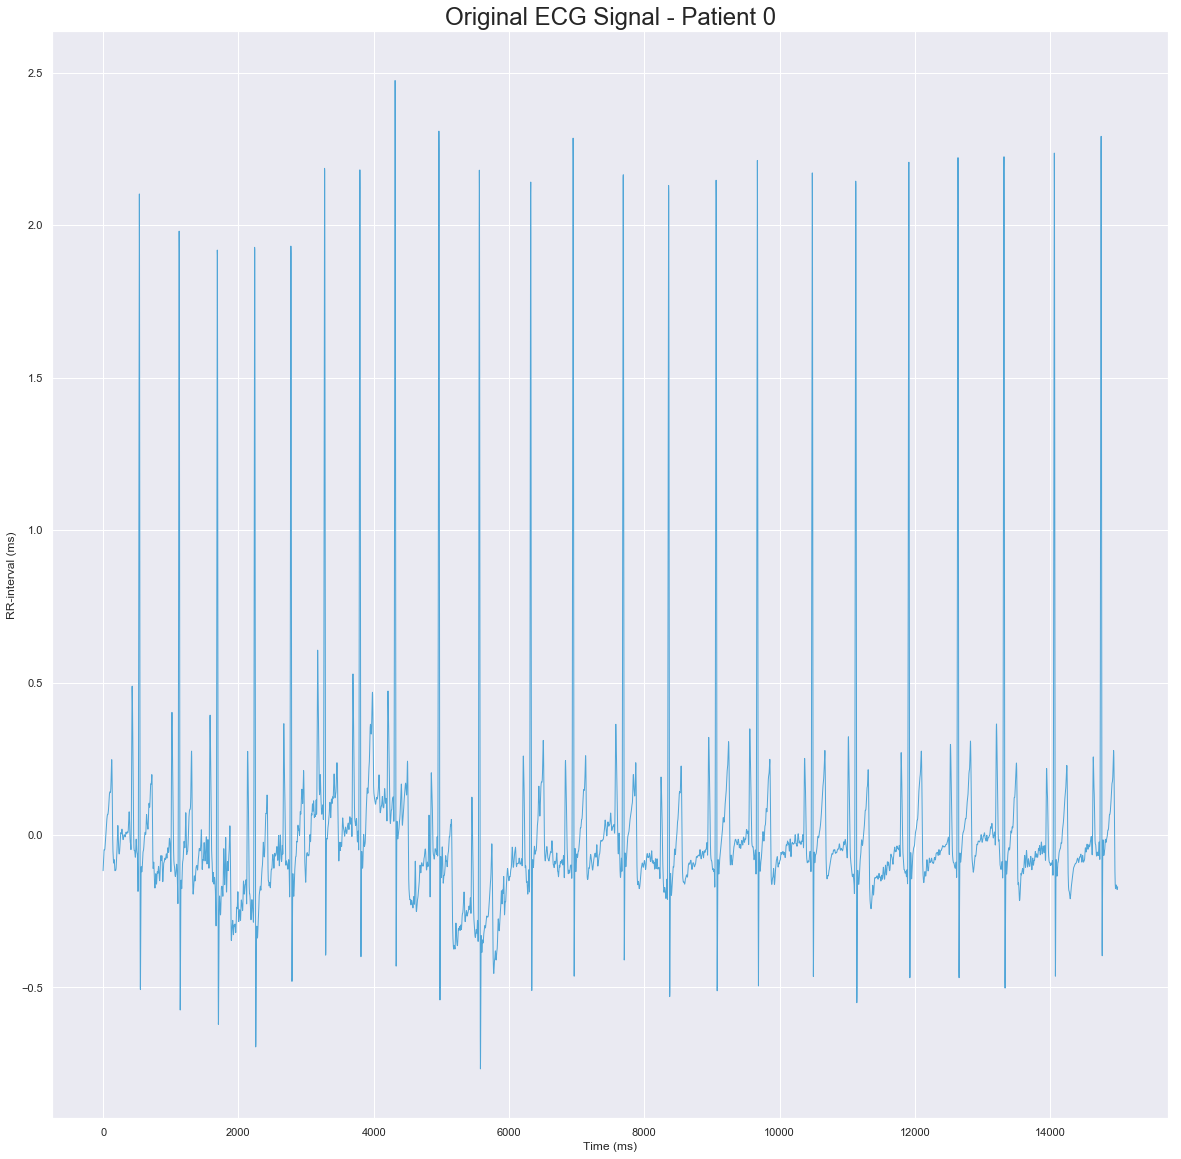

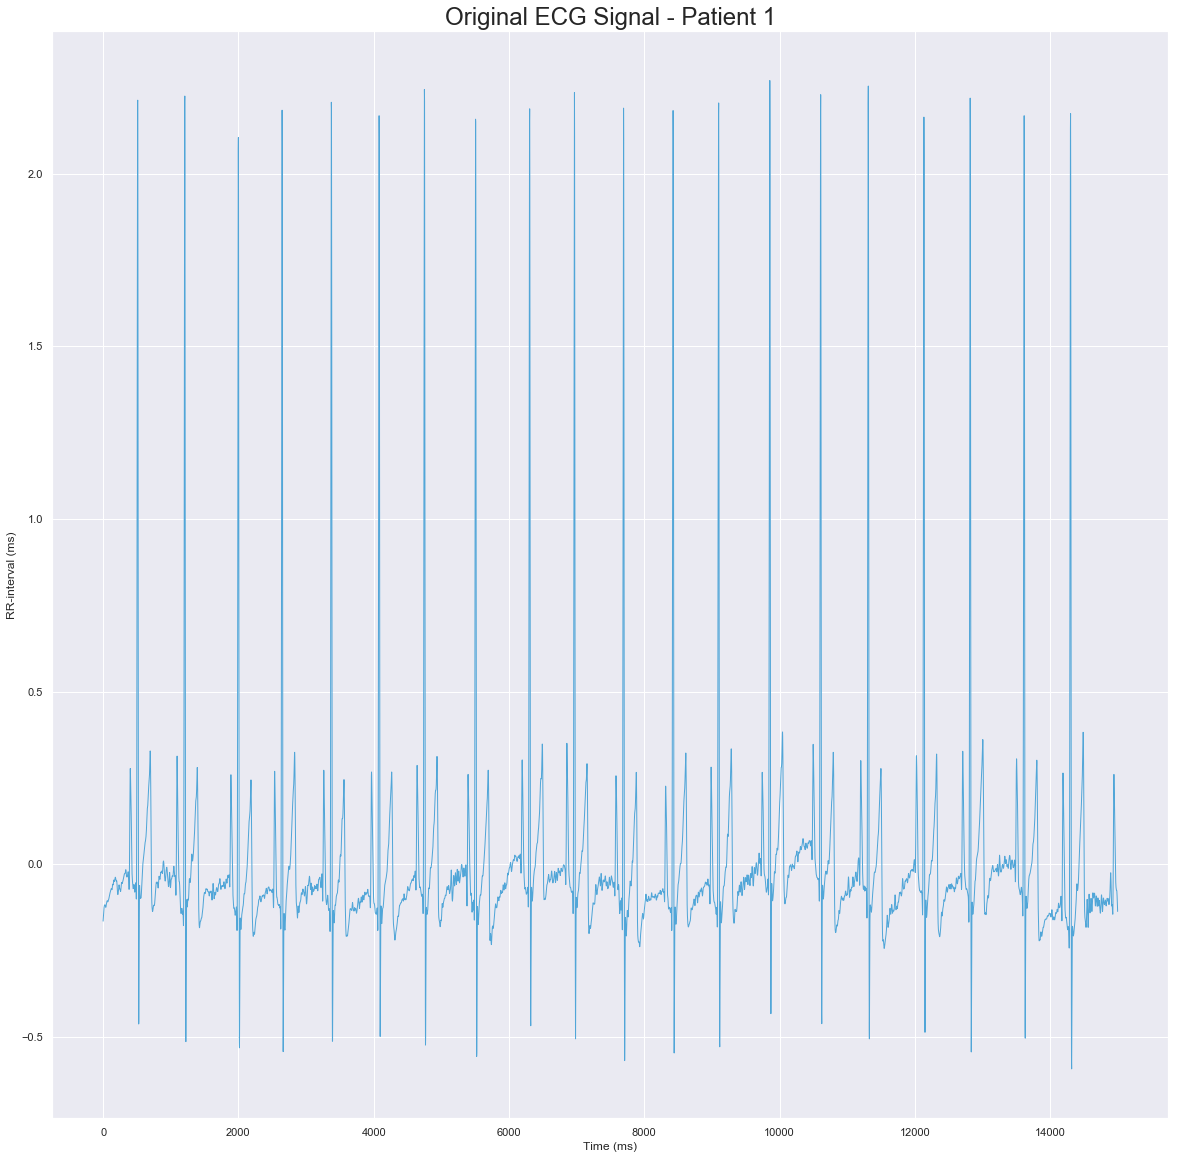

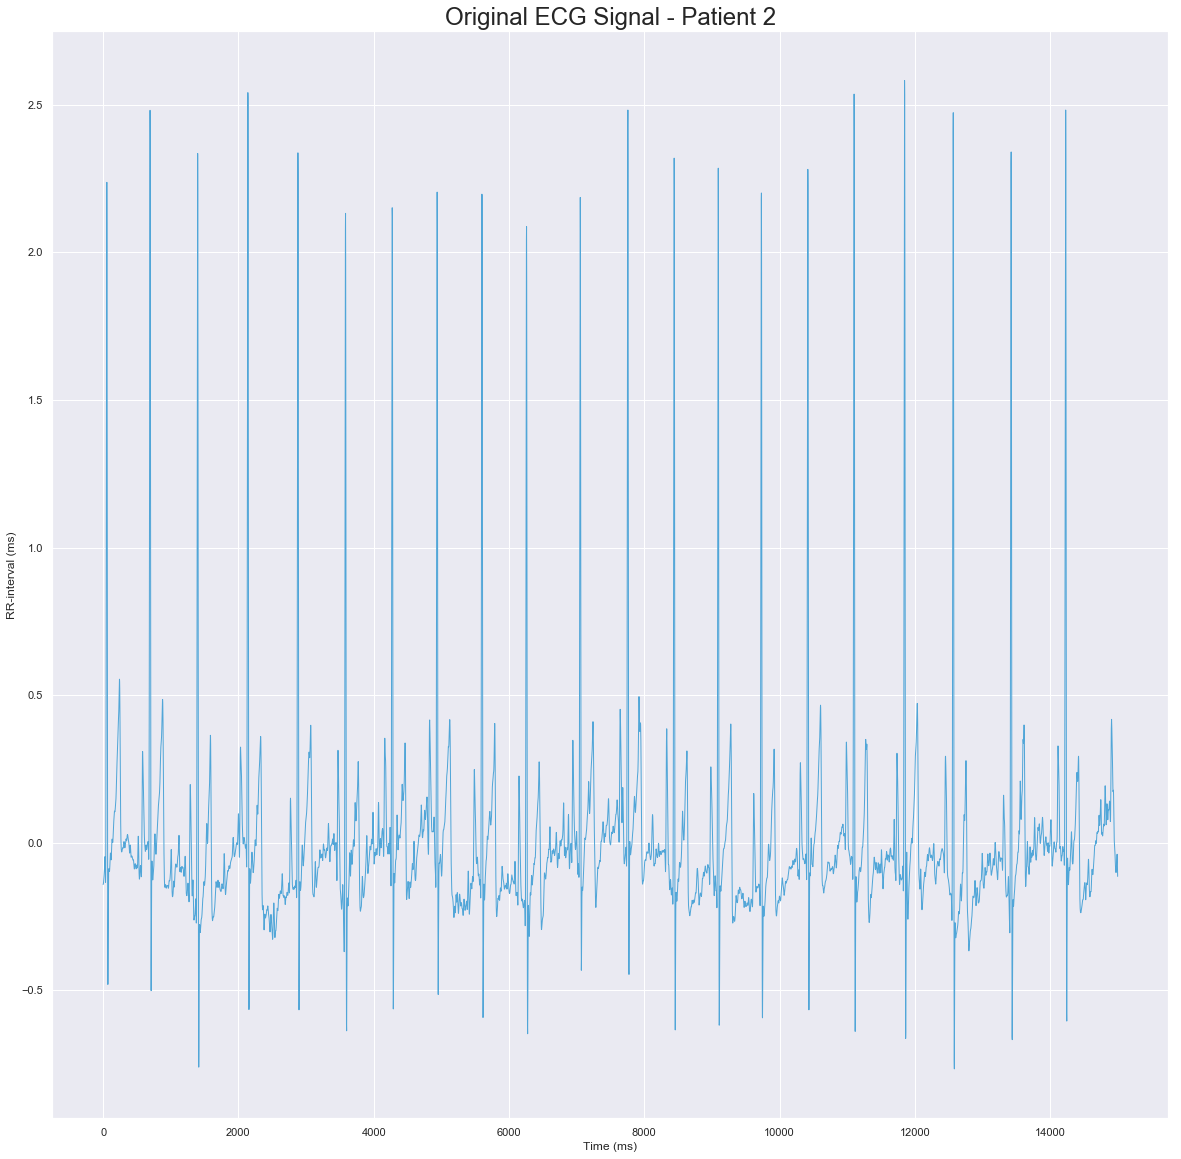

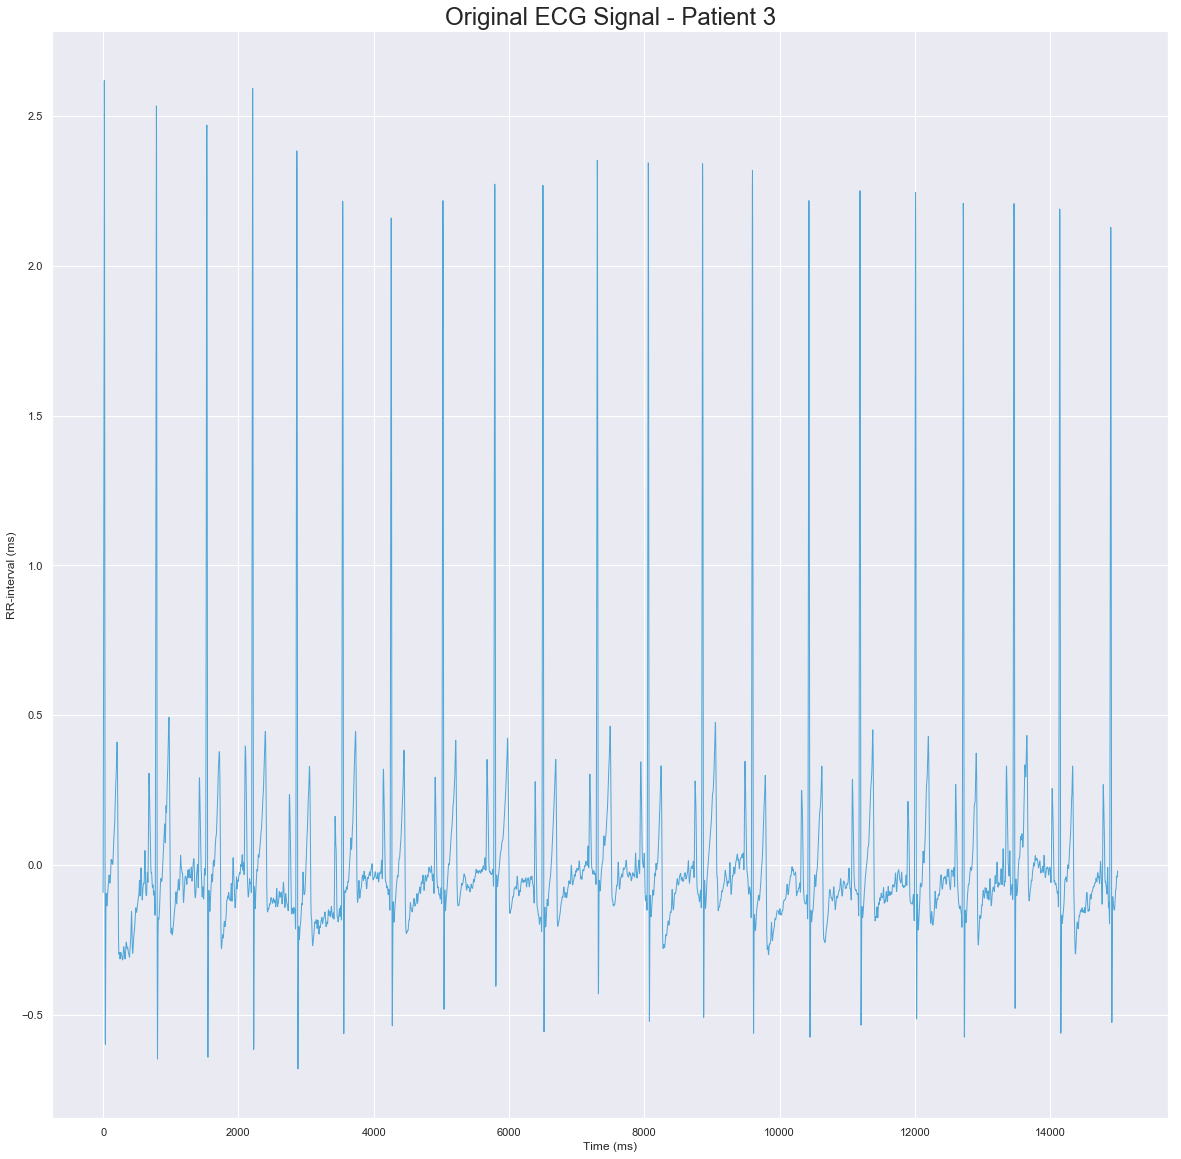

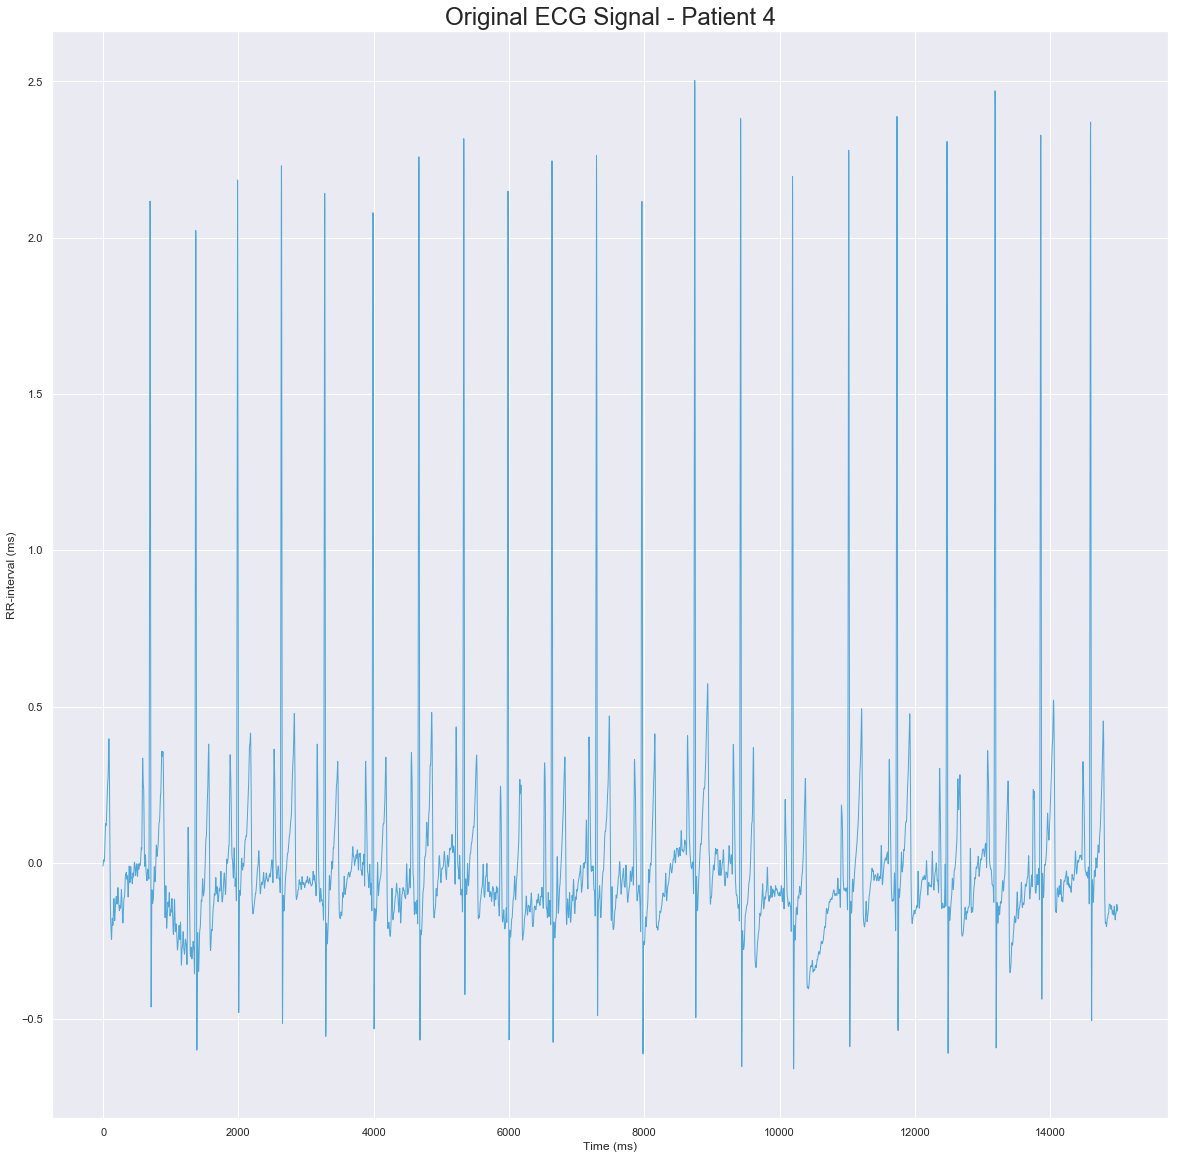

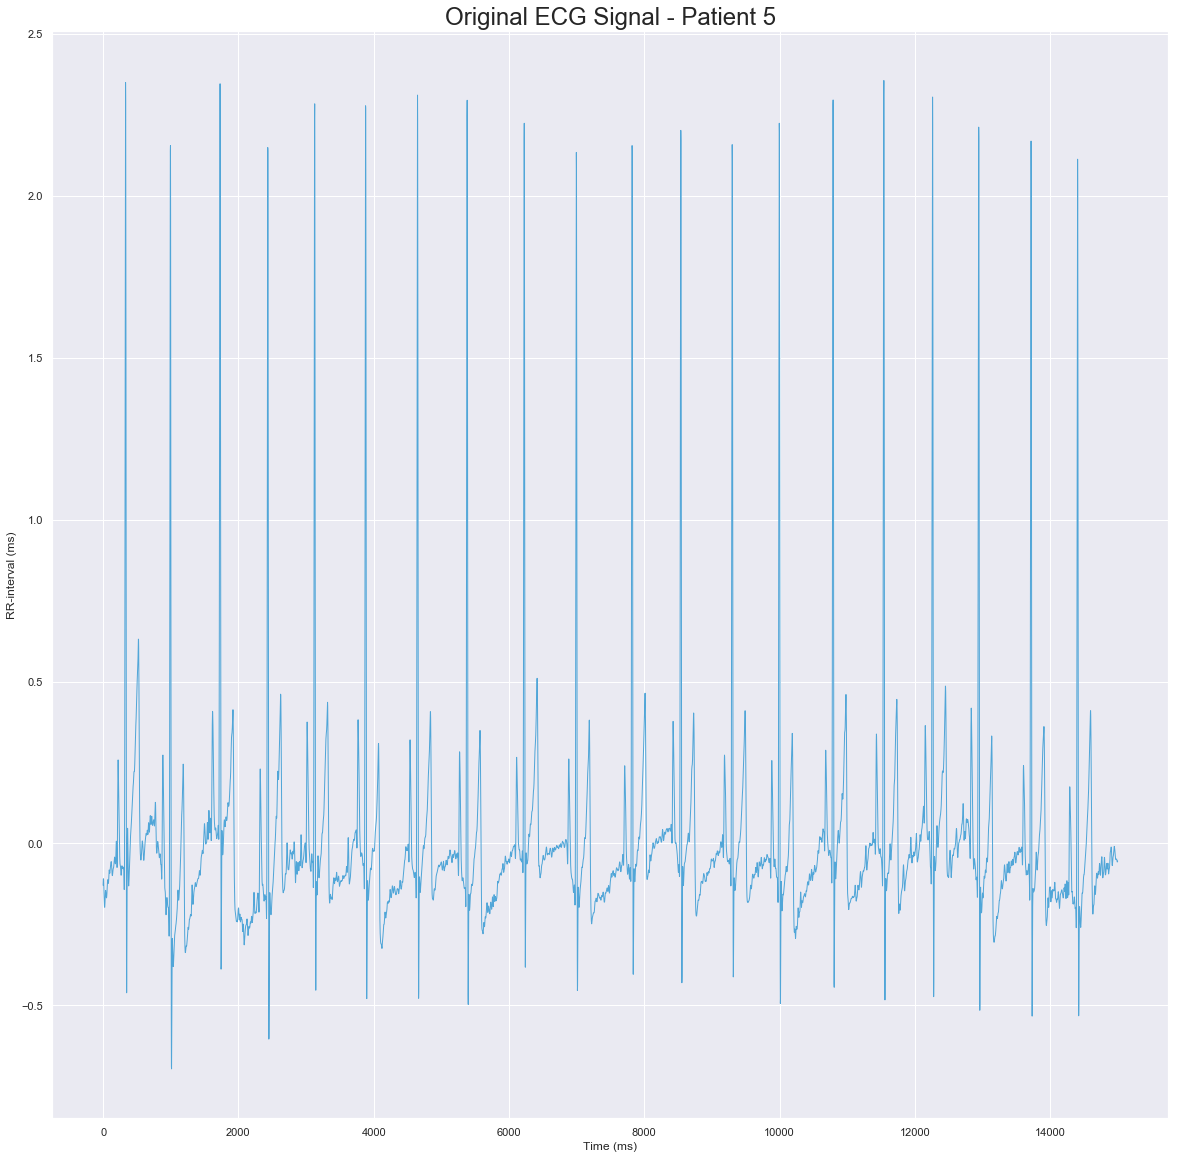

In [6]:
# Affichage des signaux ECG brut
for i in ECGs_dic :
    
    plt.figure(figsize=(20, 20)) 
    plt.title("Original ECG Signal - Patient {}".format(i['patient :']), fontsize=24)
    plt.plot(i['ECG '].ms, i['ECG '].heartrate, label="ECG", color="#51A6D8", linewidth=1)
    plt.xlabel("Time (ms)") 
    plt.ylabel("RR-interval (ms)")  

<a id='1'></a>

# Filtrage du signal

Le filtrage du signal à l'aide de la méthode des ondelettes nous permet de capturer des informations spatiales et temporelles très importantes pour la détection d'anomalie et donc pour la mission de Devinnova.

La transformée en ondelette ressemble à une transformée de Fourier, à la différence que la transformée de Fourier donne une information en fréquence et non pas en temps.

Différents algorithmes existent, ici nous appliquerons une transformation discrète en ondelette au signal brut.

<a id='1.1'></a>
### Stationary Wavelet Transform

La transformation décompose le signal en plusieurs coefficients correspondants à différentes échelles de l'ondelette. Chaque coefficient a une paire approximation/détail. Ici nous utilisons les coefficients de détail de niveau 2.

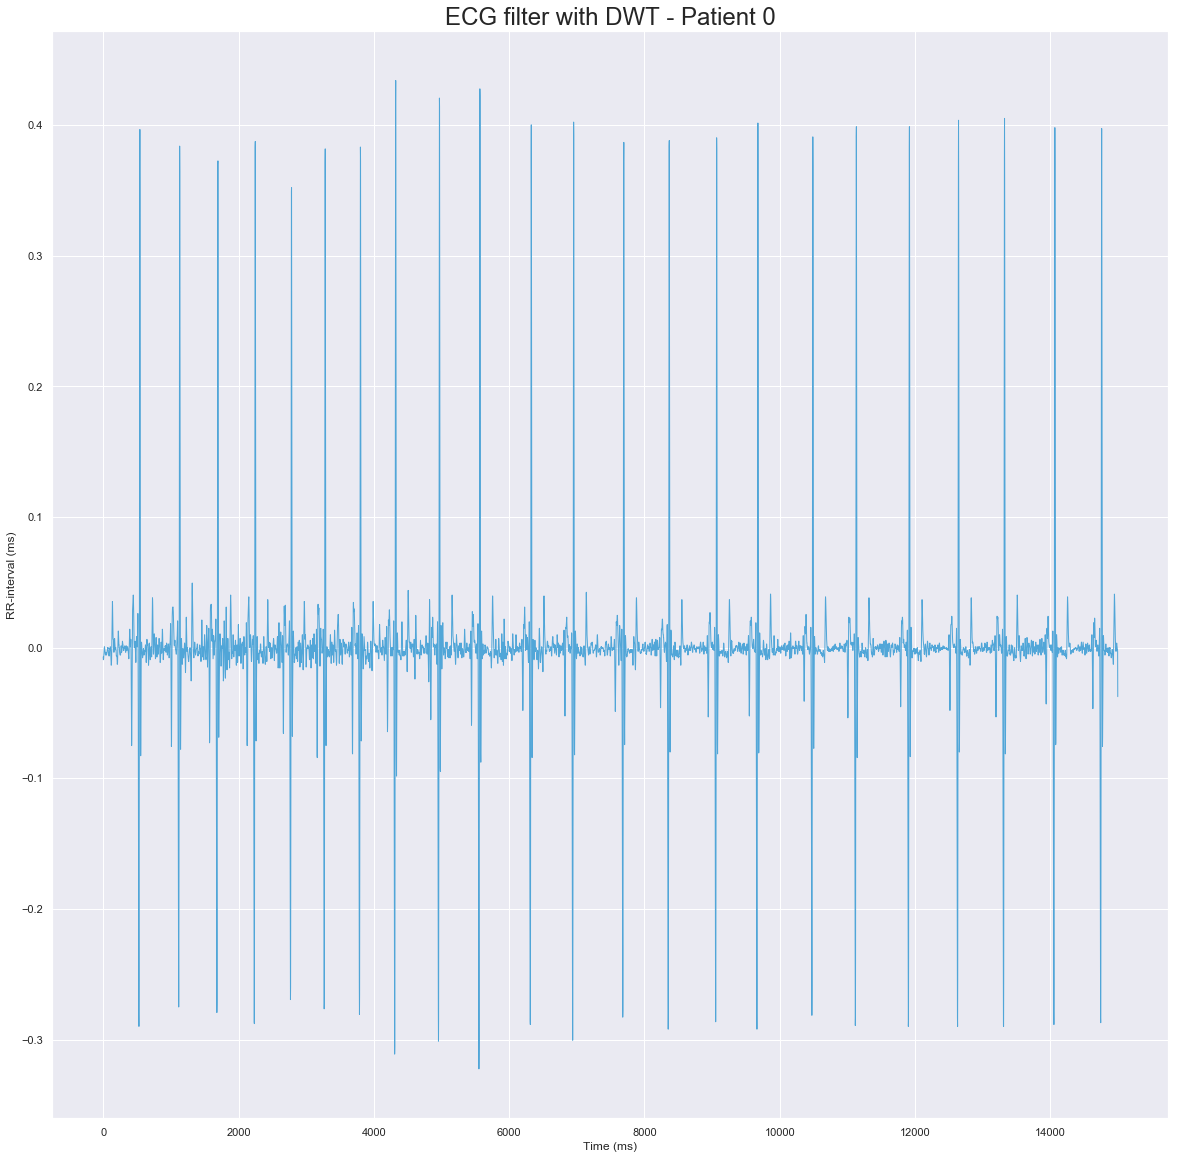

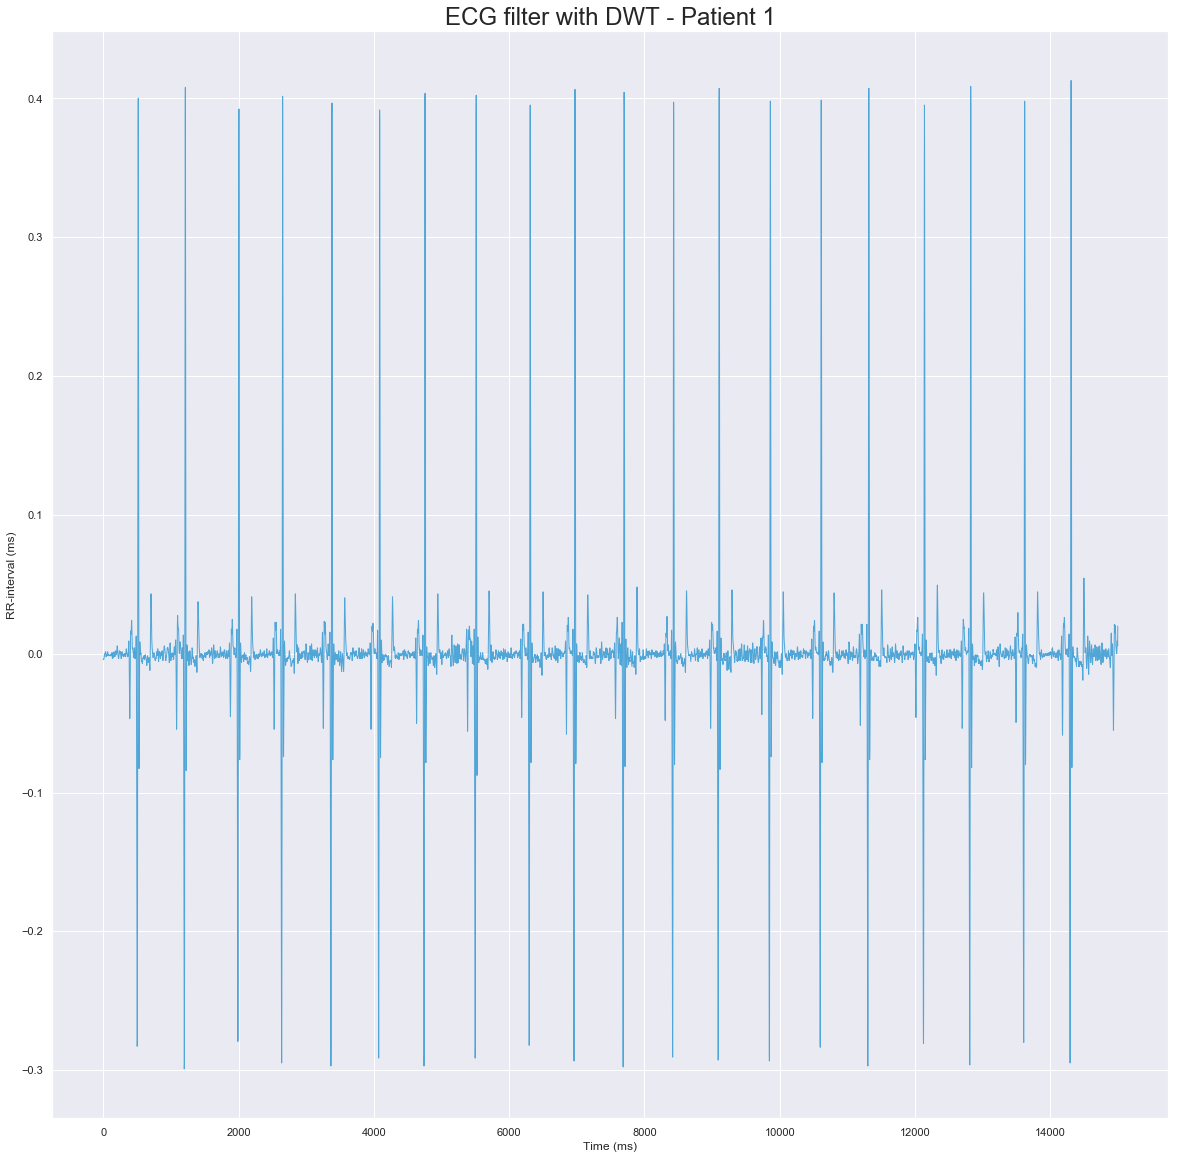

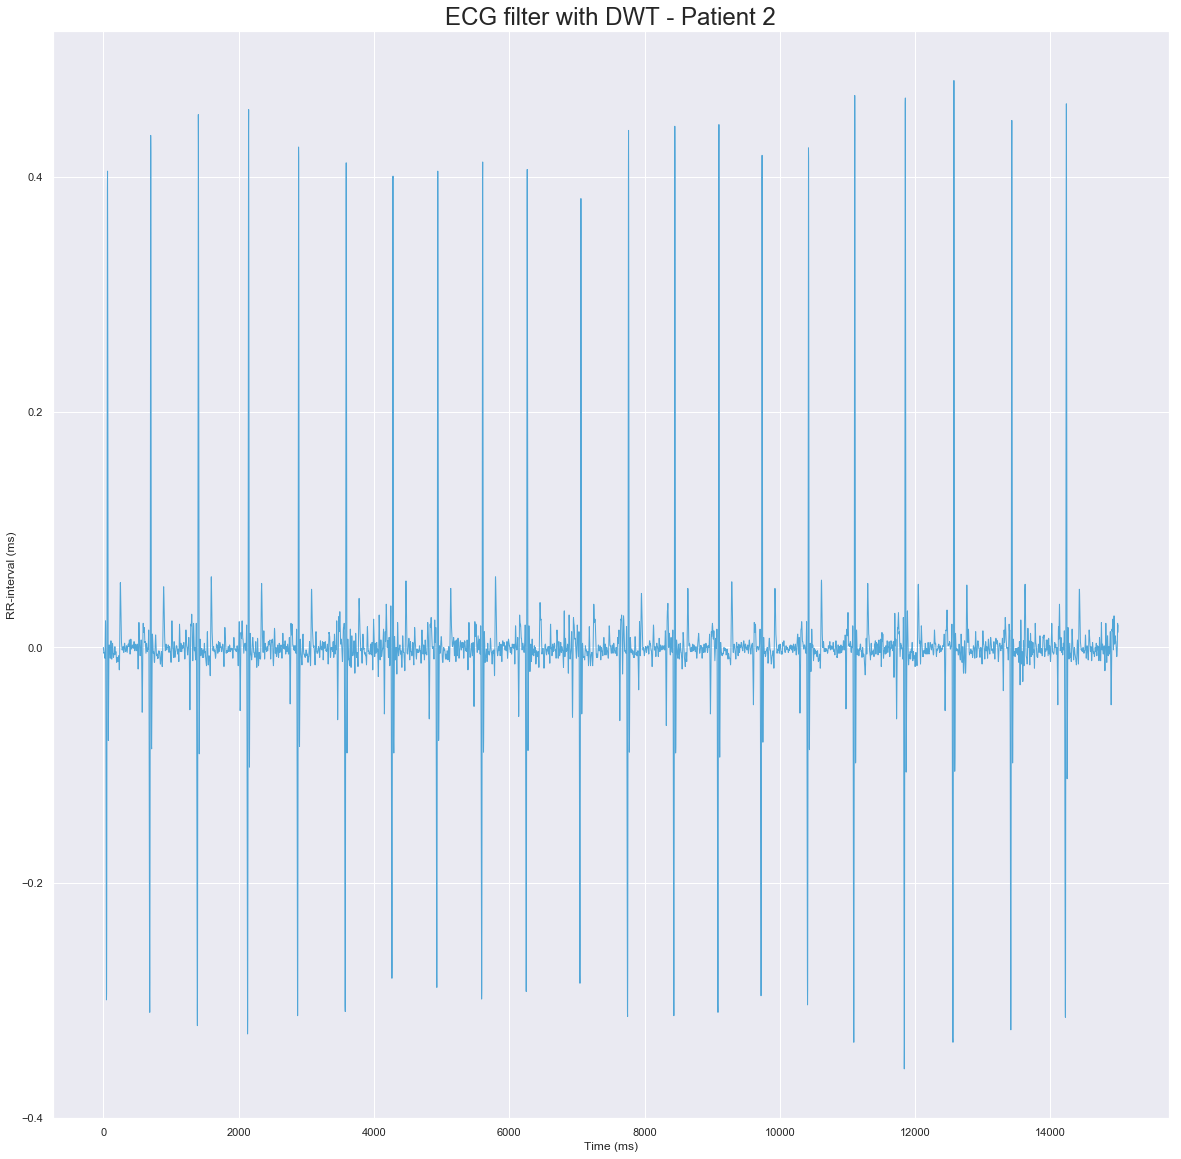

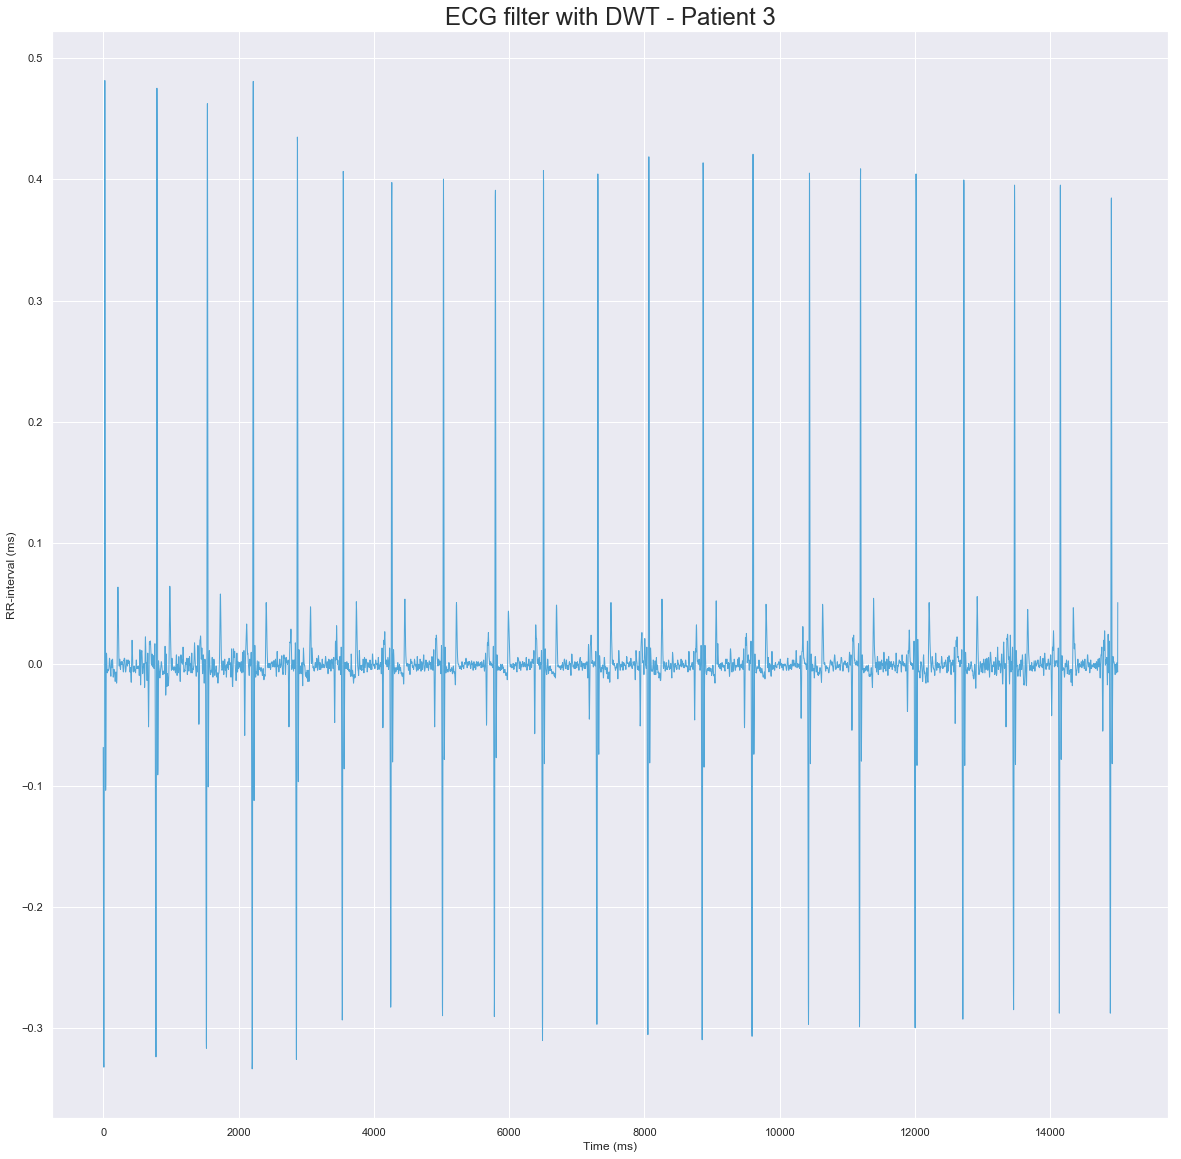

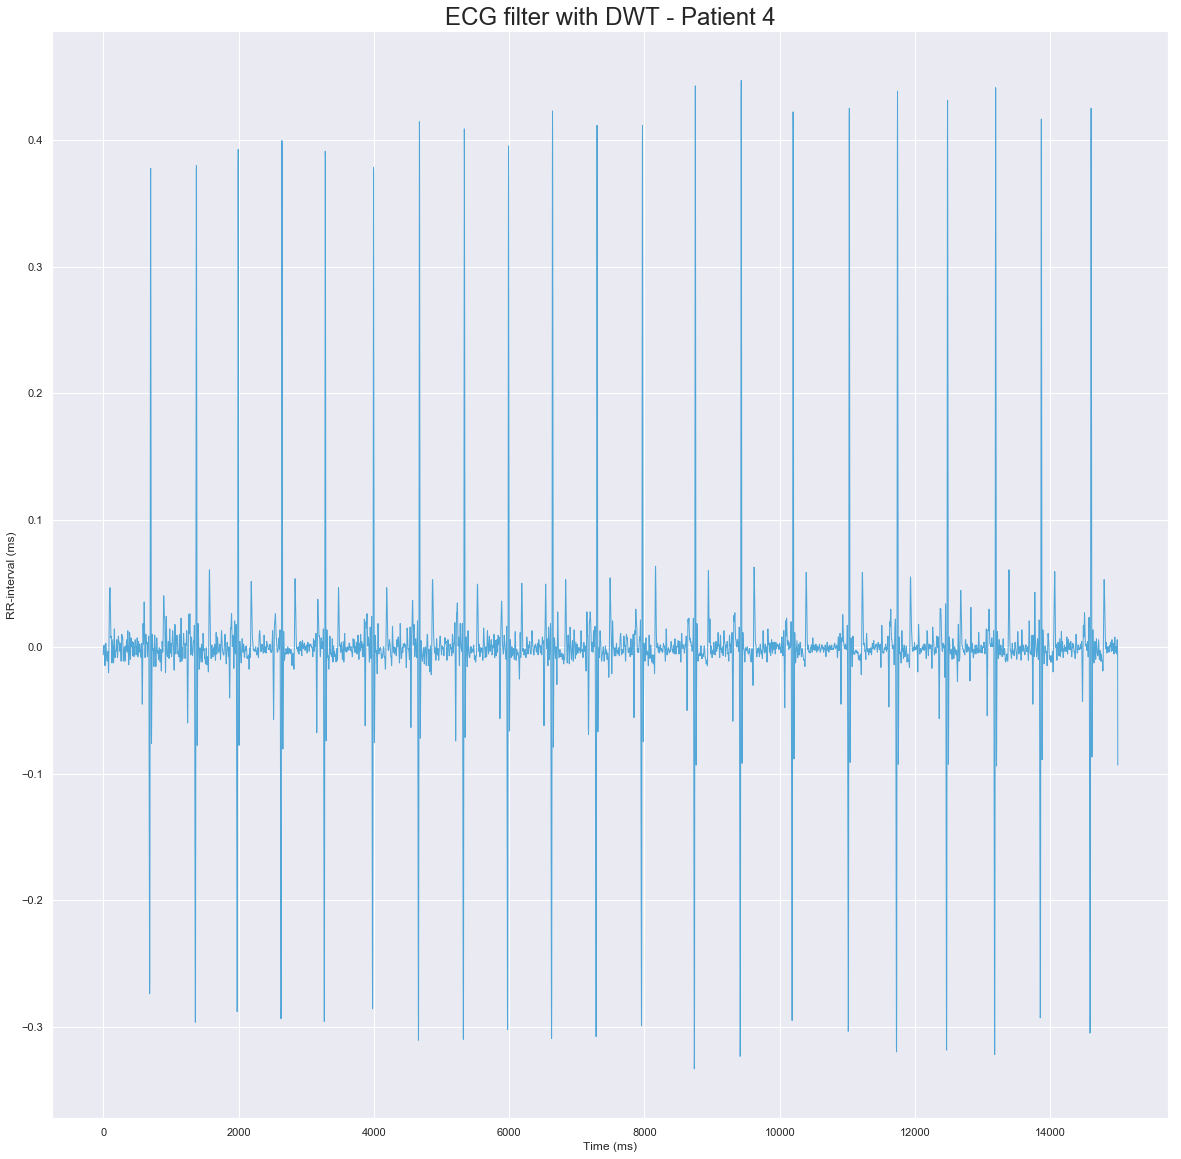

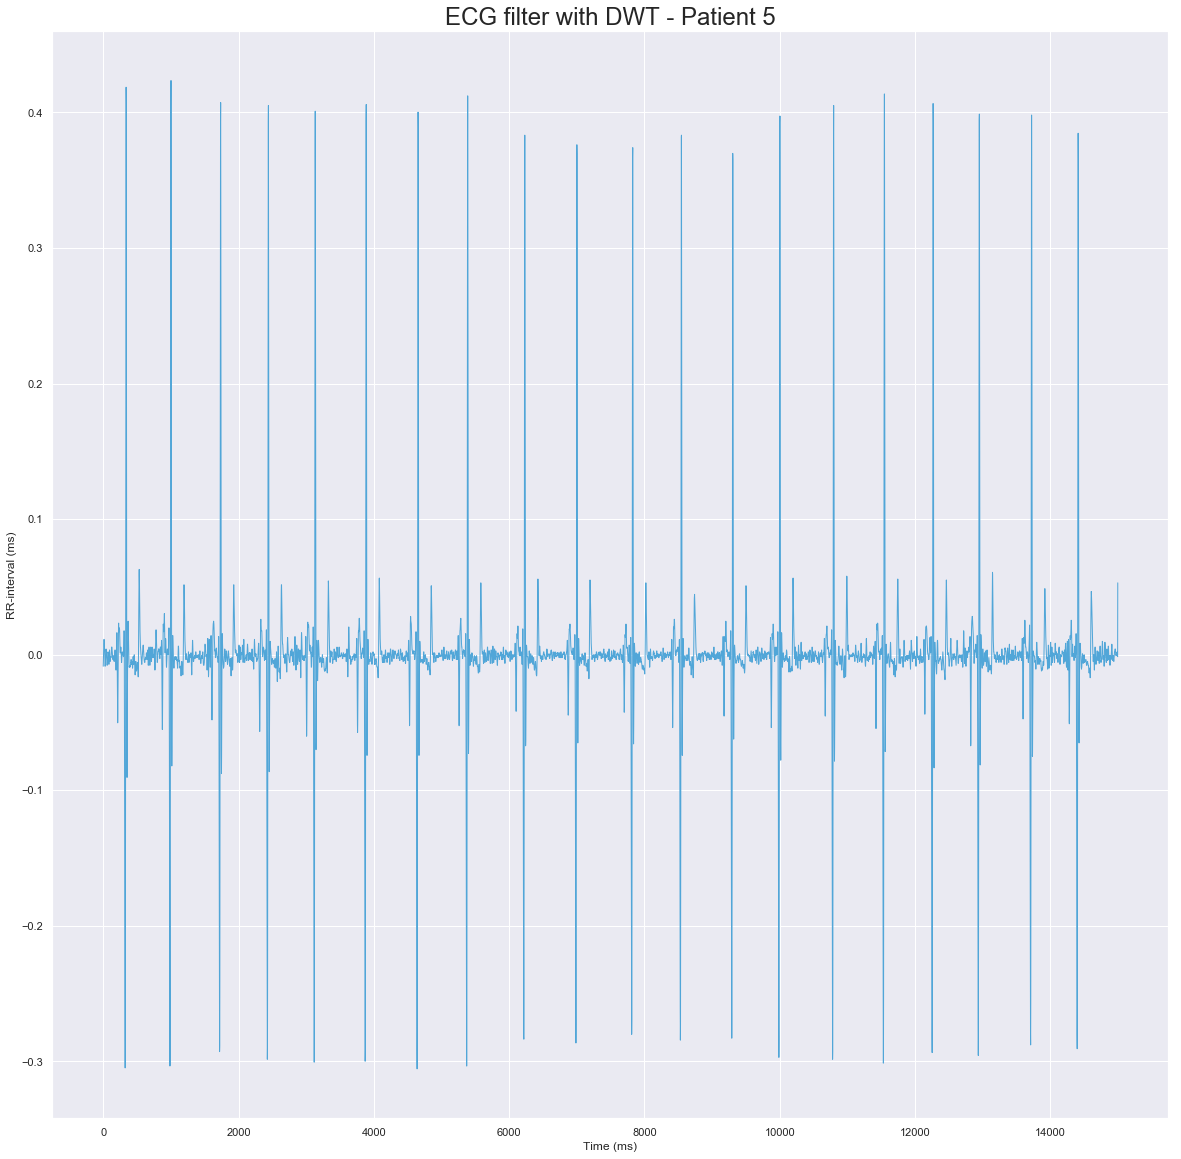

In [7]:
# Affichage du signal filtré
for i in ECGs_dic :
     
    dwt_signal = wavelet_transform(i['ECG ']) # Le signal est transfomé 
    plt.figure(figsize=(20, 20)) 
    plt.title("ECG filter with DWT - Patient {}".format(i['patient :']), fontsize=24) 
    plt.plot(i['ECG '].ms, dwt_signal, label="ECG", color="#51A6D8", linewidth=1) 
    plt.xlabel("Time (ms)")  
    plt.ylabel("RR-interval (ms)")

<a id='2'></a>

# Isoler onde R (systole auriculaire)

<a id='2.1'></a>
### Thresholding

Une fois le signal filtré, nous utilisons une valeur seuil (threshold) sur les coefficients de transformation pour détecter les pics. Si le coefficient comparé est 2 fois supérieur à la dérivation standard, sa valeur absolue est conservée.

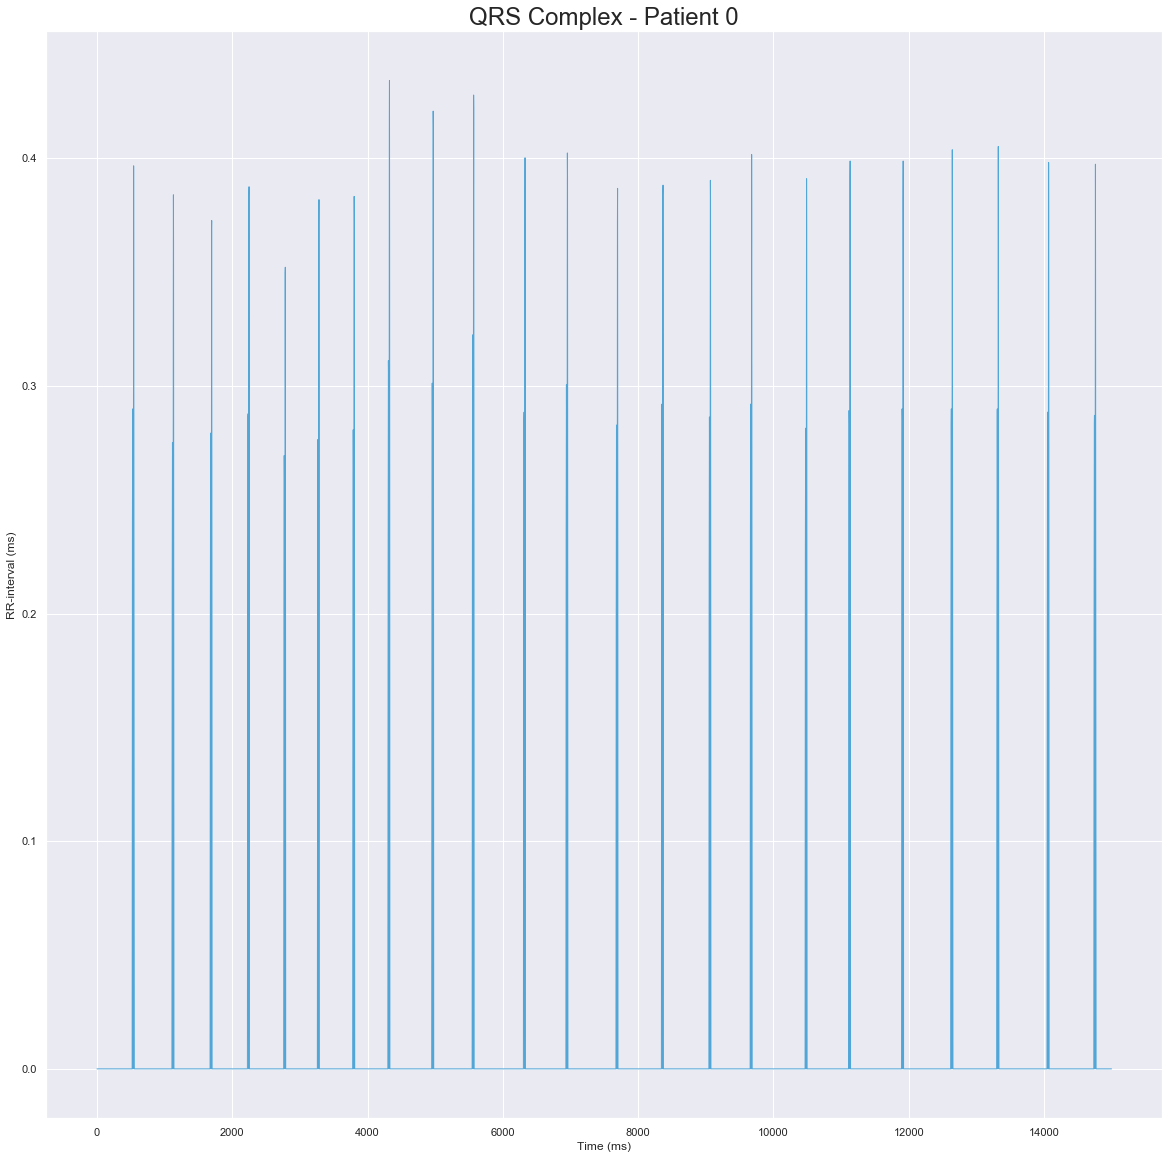

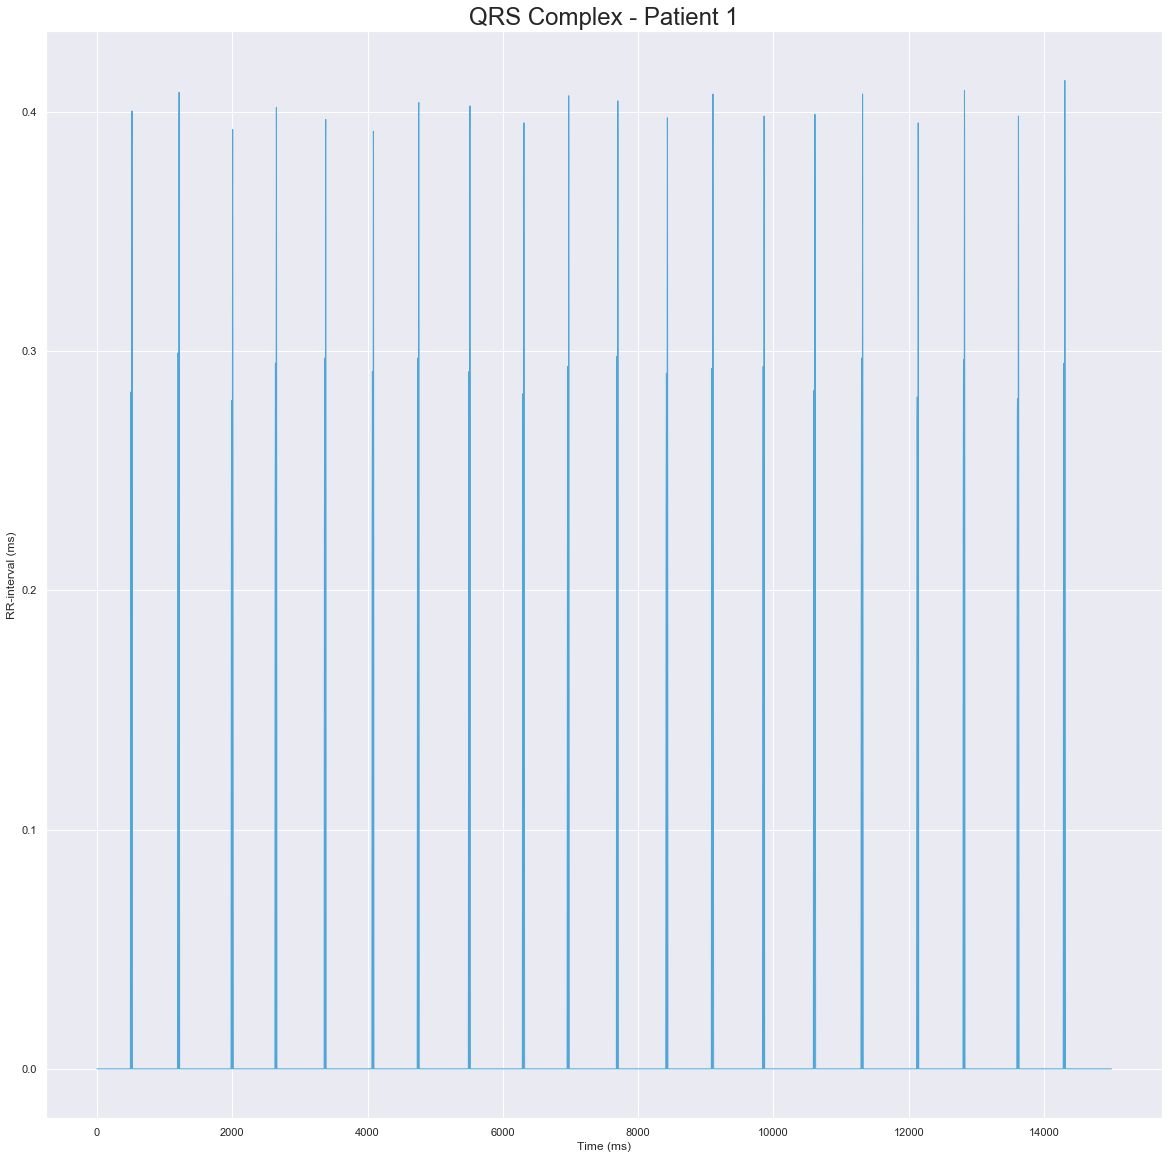

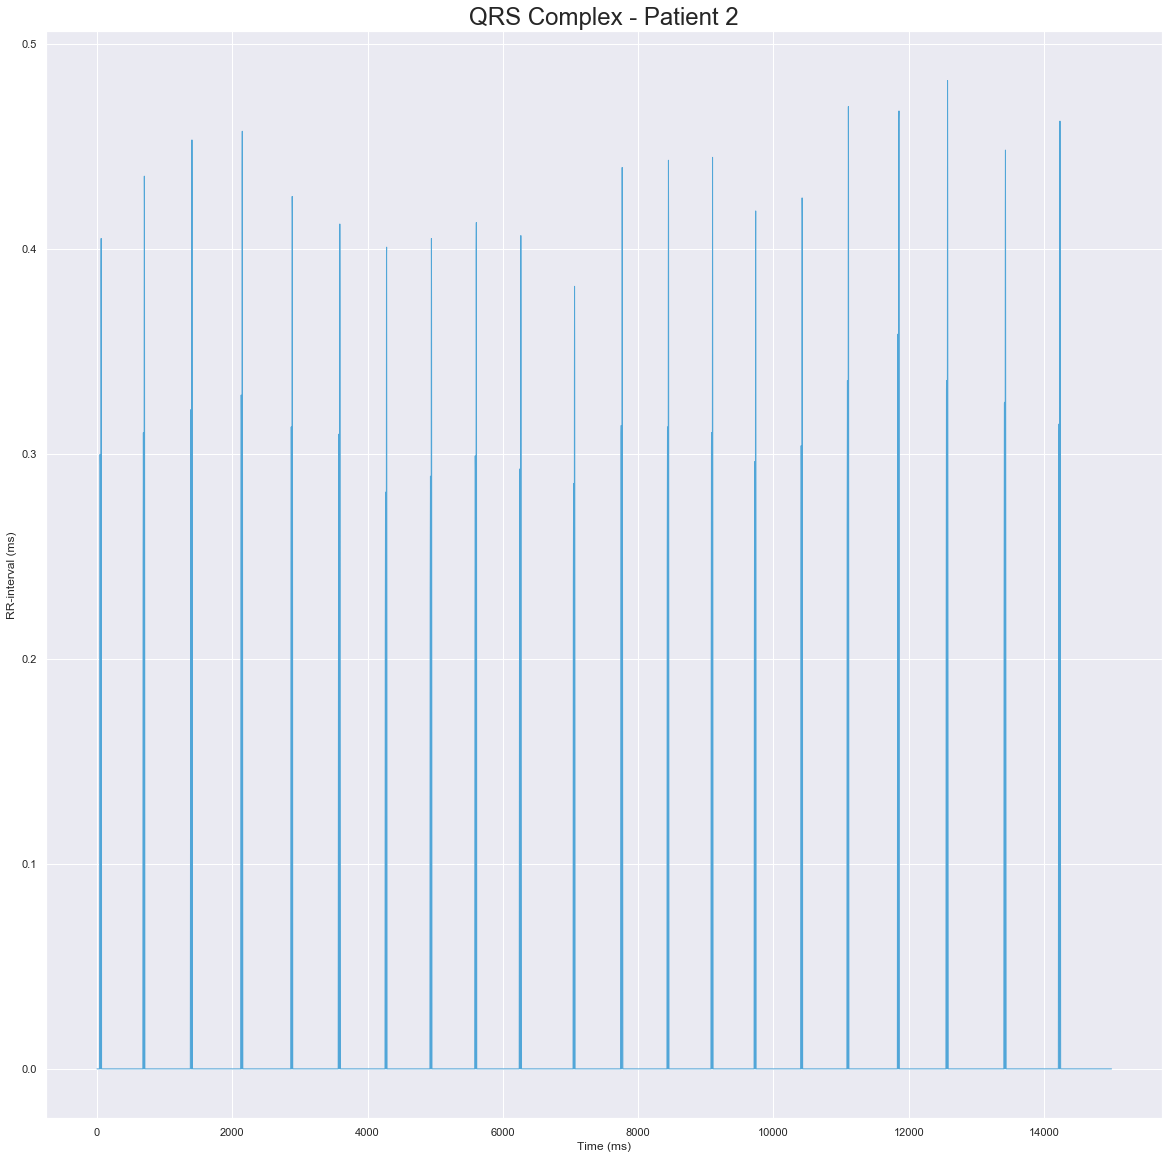

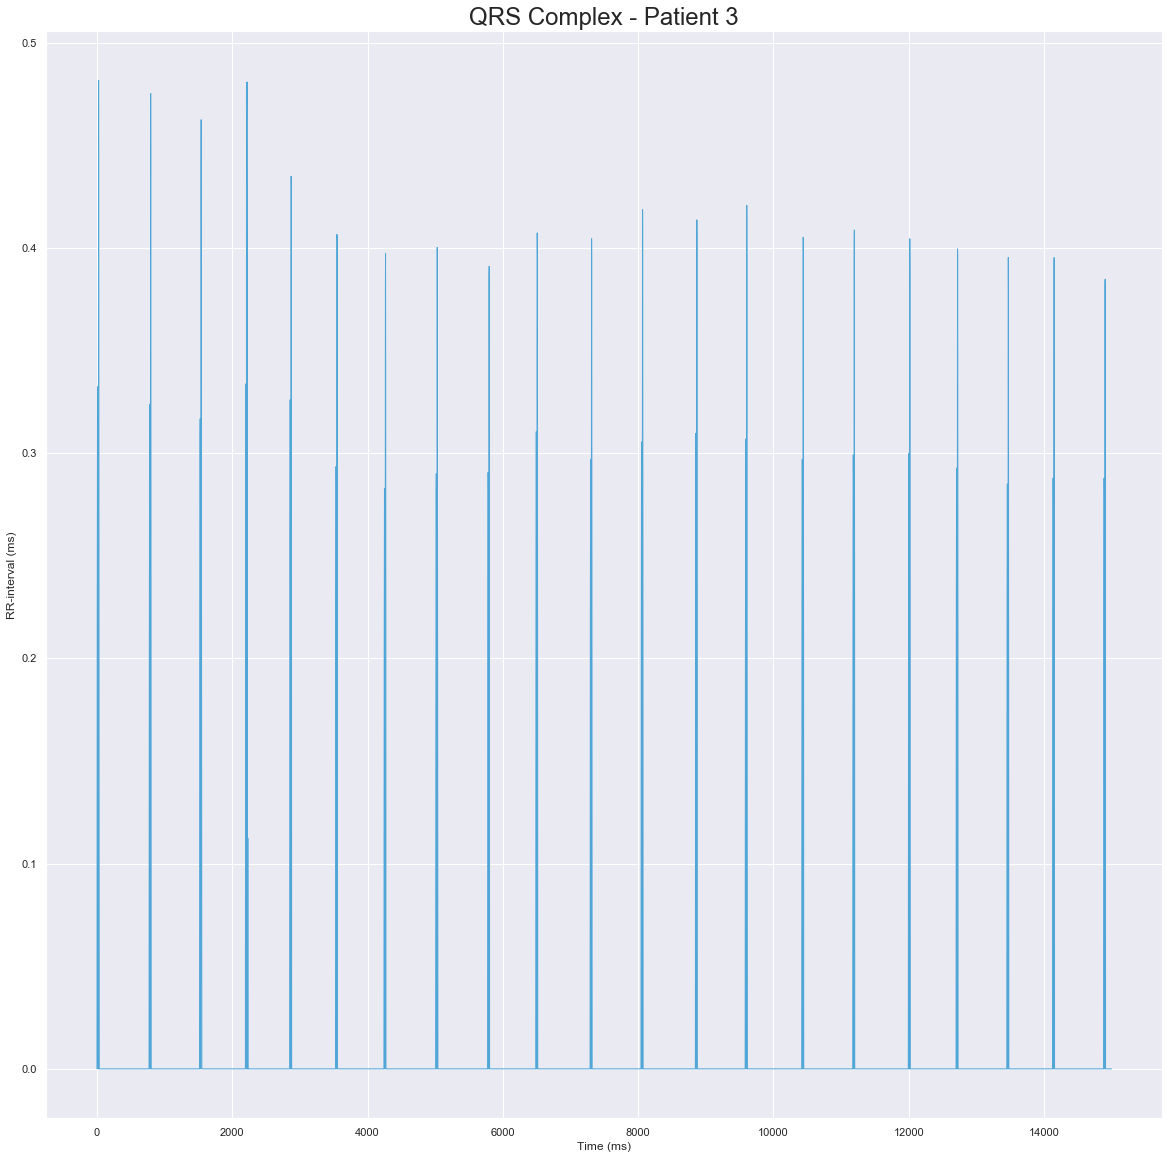

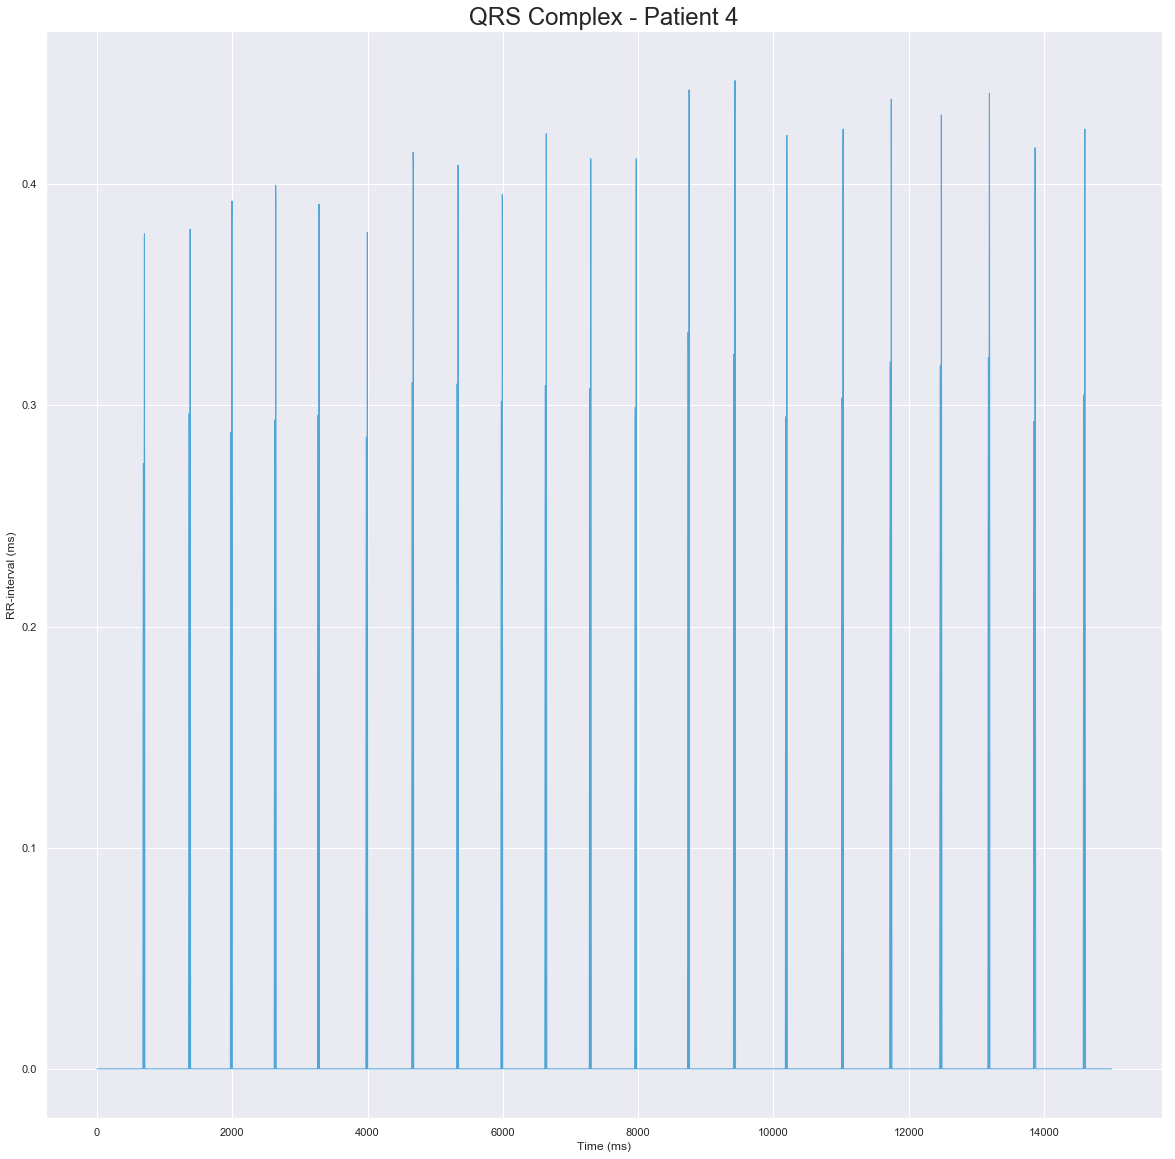

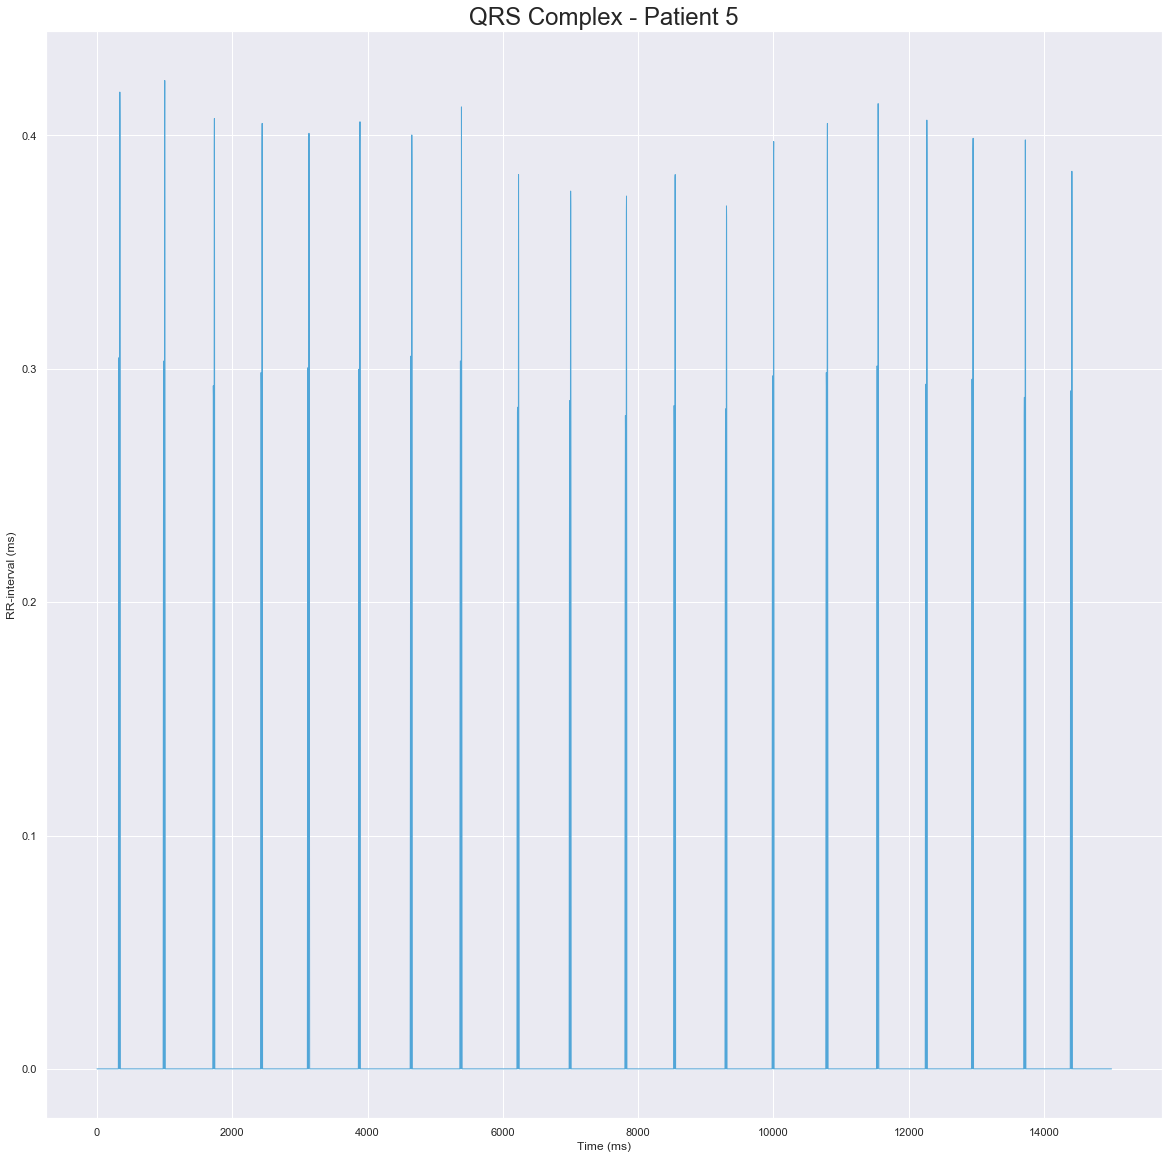

In [8]:
def thr_signal(d2):
    
    avg = np.mean(d2)
    std = np.std(d2)
    sig_thres = [abs(i) if abs(i) > 2.0 * std else 0 for i in d2-avg]
    
    return sig_thres

for i in ECGs_dic :
    
    d2 = wavelet_transform(i['ECG ']) 
    th_s = thr_signal(d2) 
    plt.figure(figsize=(20, 20)) 
    plt.title("QRS Complex - Patient {}".format(i['patient :']), fontsize=24) 
    plt.plot(i['ECG '].ms, th_s, label="ECG", color="#51A6D8", linewidth=1) 
    plt.xlabel("Time (ms)")  
    plt.ylabel("RR-interval (ms)")

<a id='2.2'></a>
### Détéction des complexes QRS

Le complexe QRS est l'activité la plus visible sur un ECG. Il correspond à la propagation d'un sitmulus à travers les ventricules (les deux grandes cavités situées au bas du coeur) qui provoque la contraction (systose). Le temps separrant deux pics donne une indication sur la fréquence cardiaque. 

L'onde R est la première onde positive du complexe QRS.

In [25]:
for i in range(len(ECGs_dic)) :
    
    if i < 4 :
        sr = 60 # sample rate déduit manuellement
    else :
        sr = 80 # sample rate déduit manuellement

    ECGs_dic[i]['r_peaks'] = [ i for i in QRS_detection(ECGs_dic[i]['ECG '].heartrate, sample_rate=sr)]

Le complexe QRS est l'activité la plus visible sur un ECG. Il correspond à la propagation d'un stimulus à travers les ventricules (les deux grandes cavités situées au bas du coeur) qui provoque la contraction (systole). Le temps séparant deux pics donne une indication sur la fréquence cardiaque.

L'onde R est la première onde positive du complexe QRS.

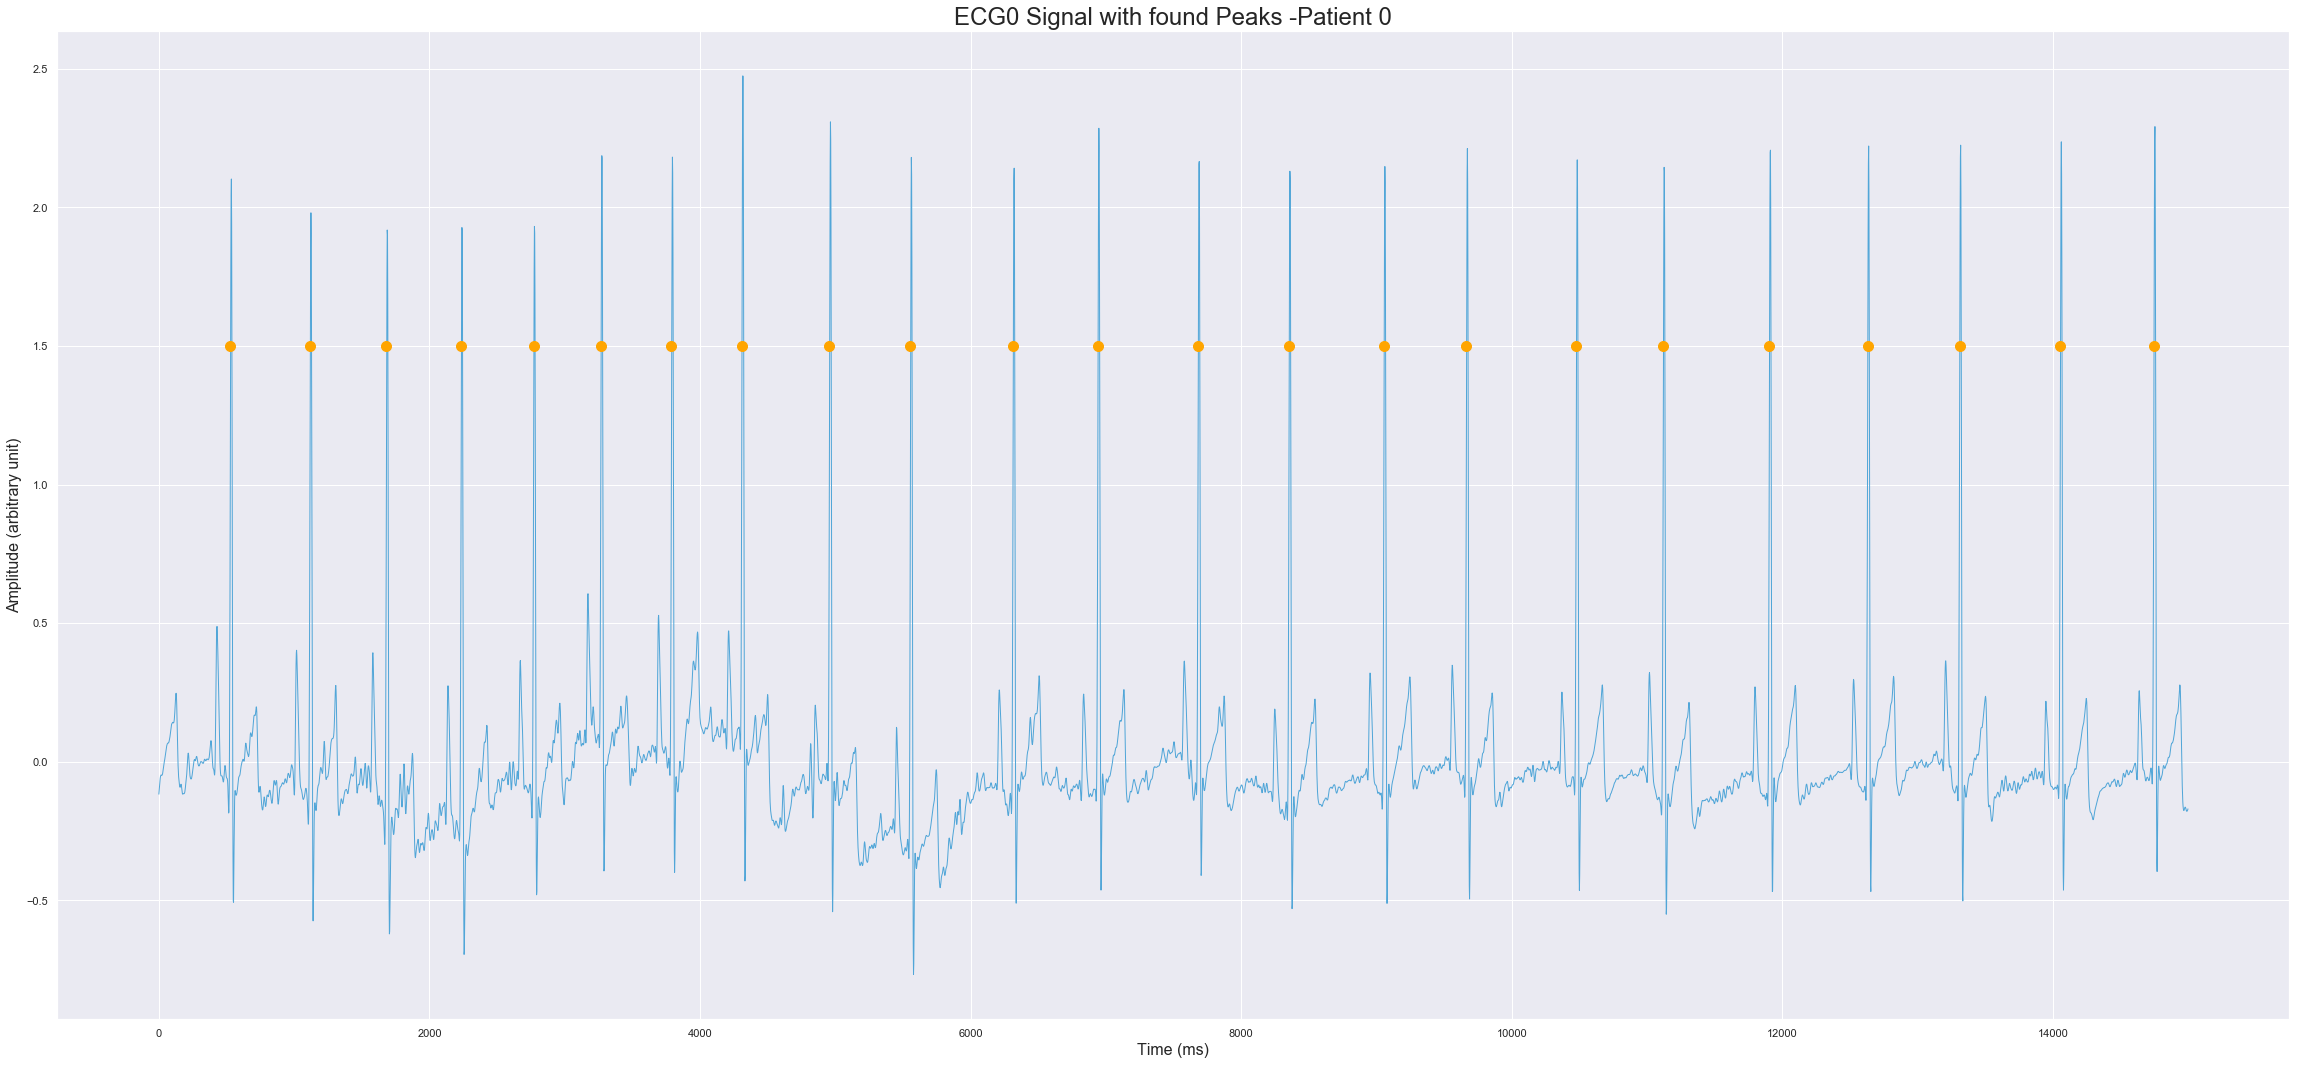

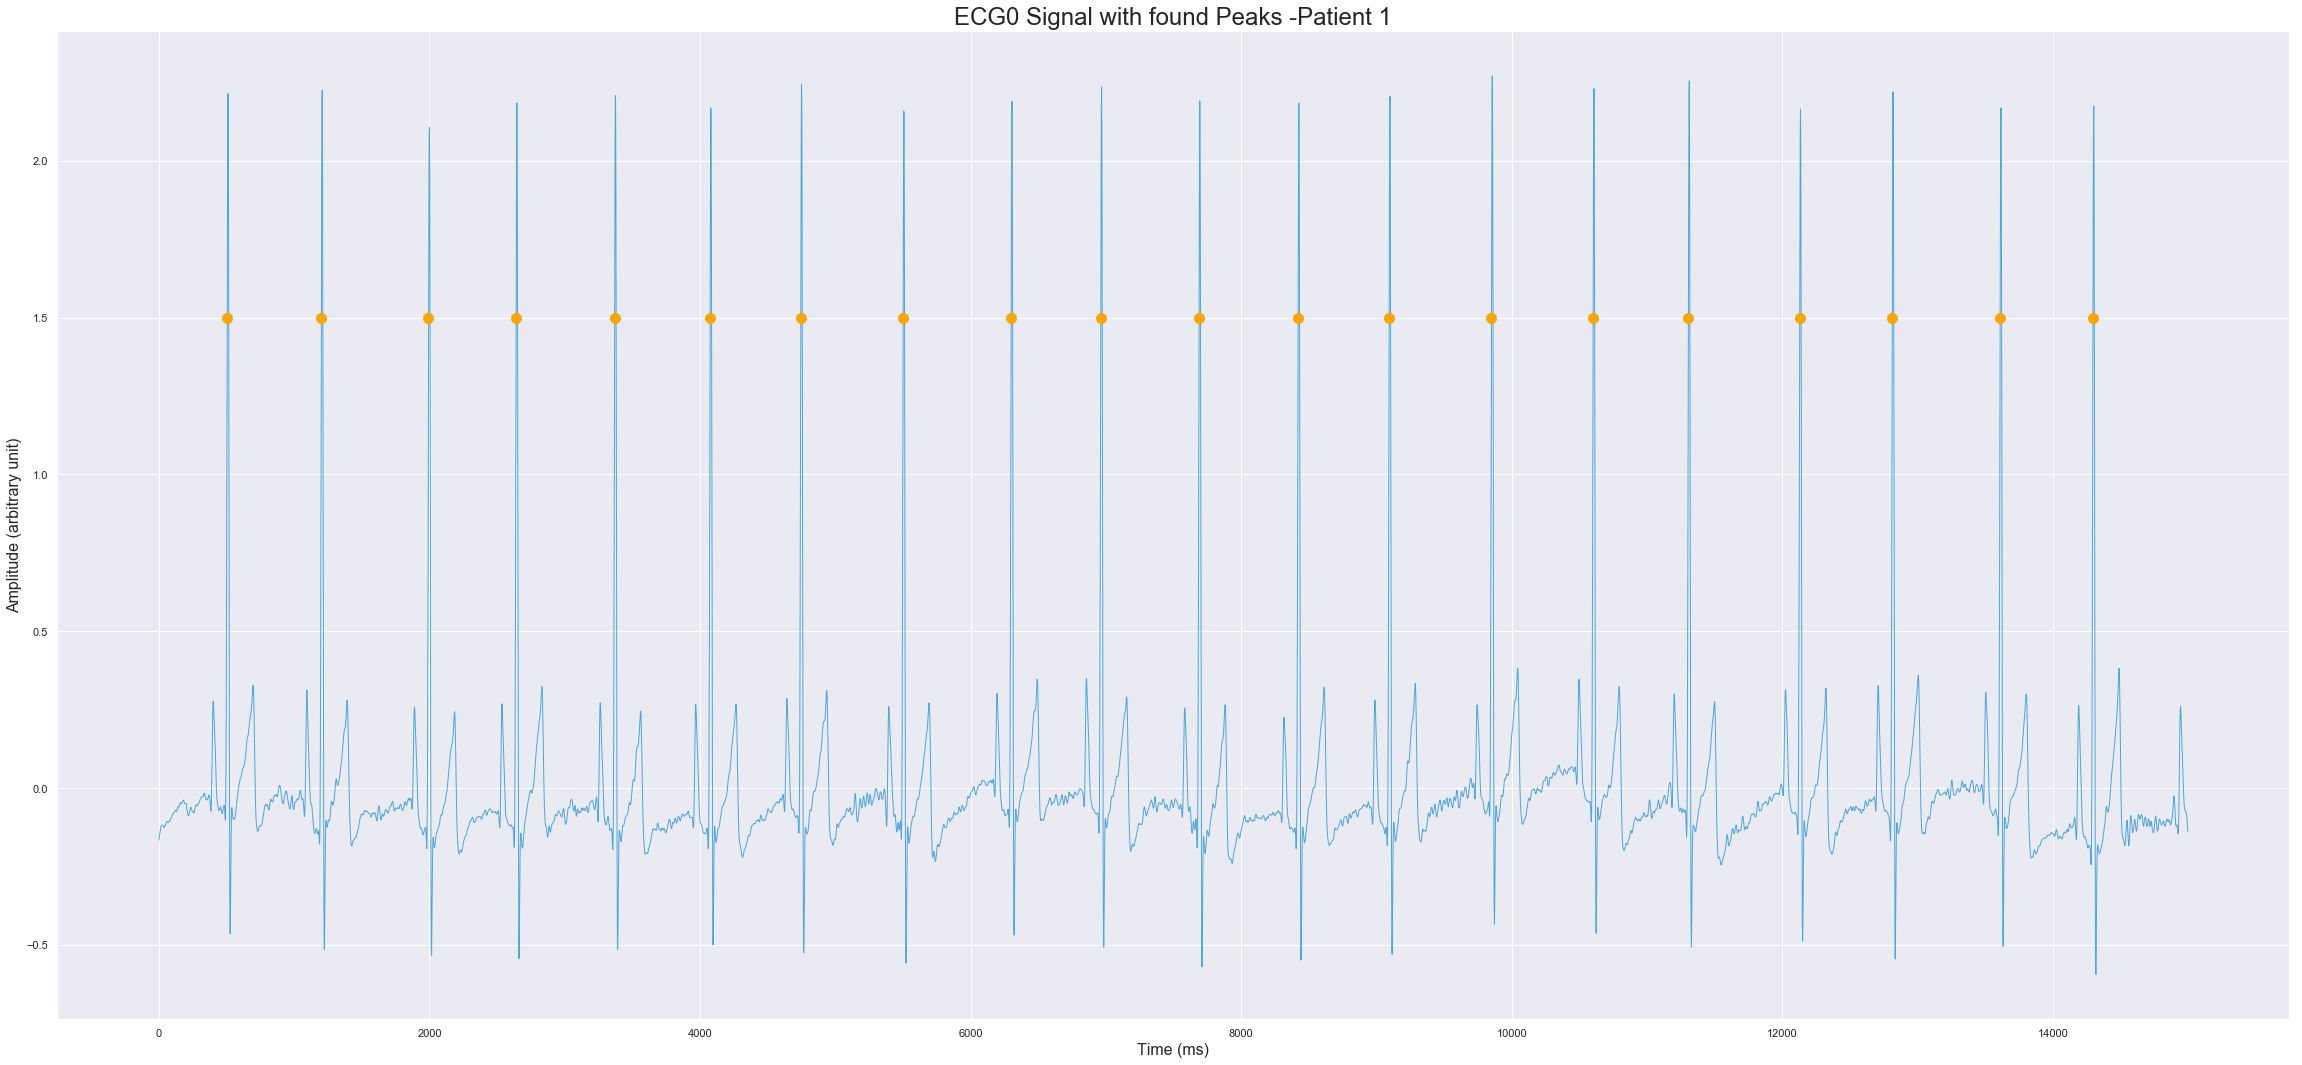

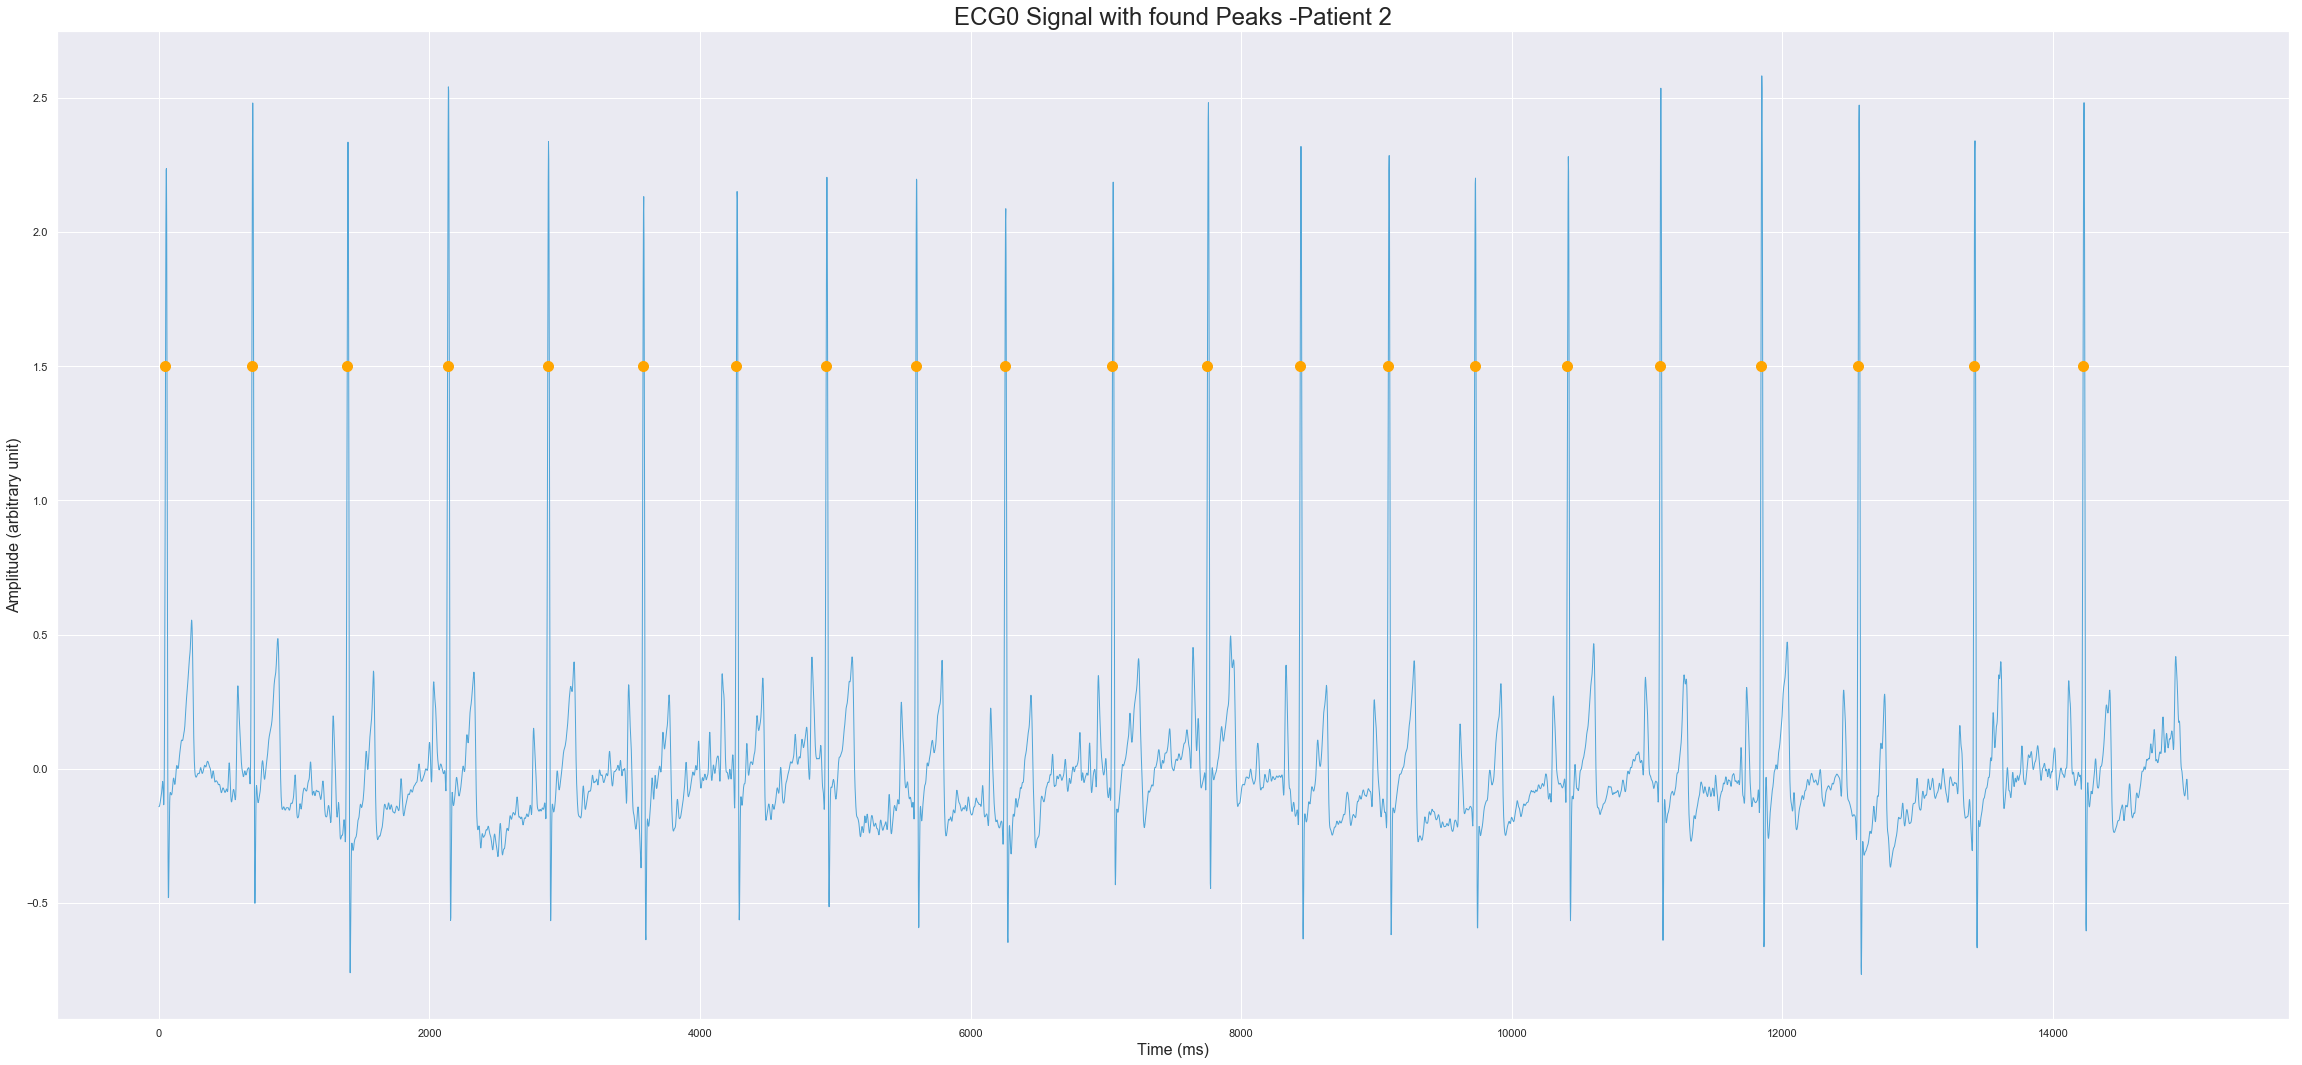

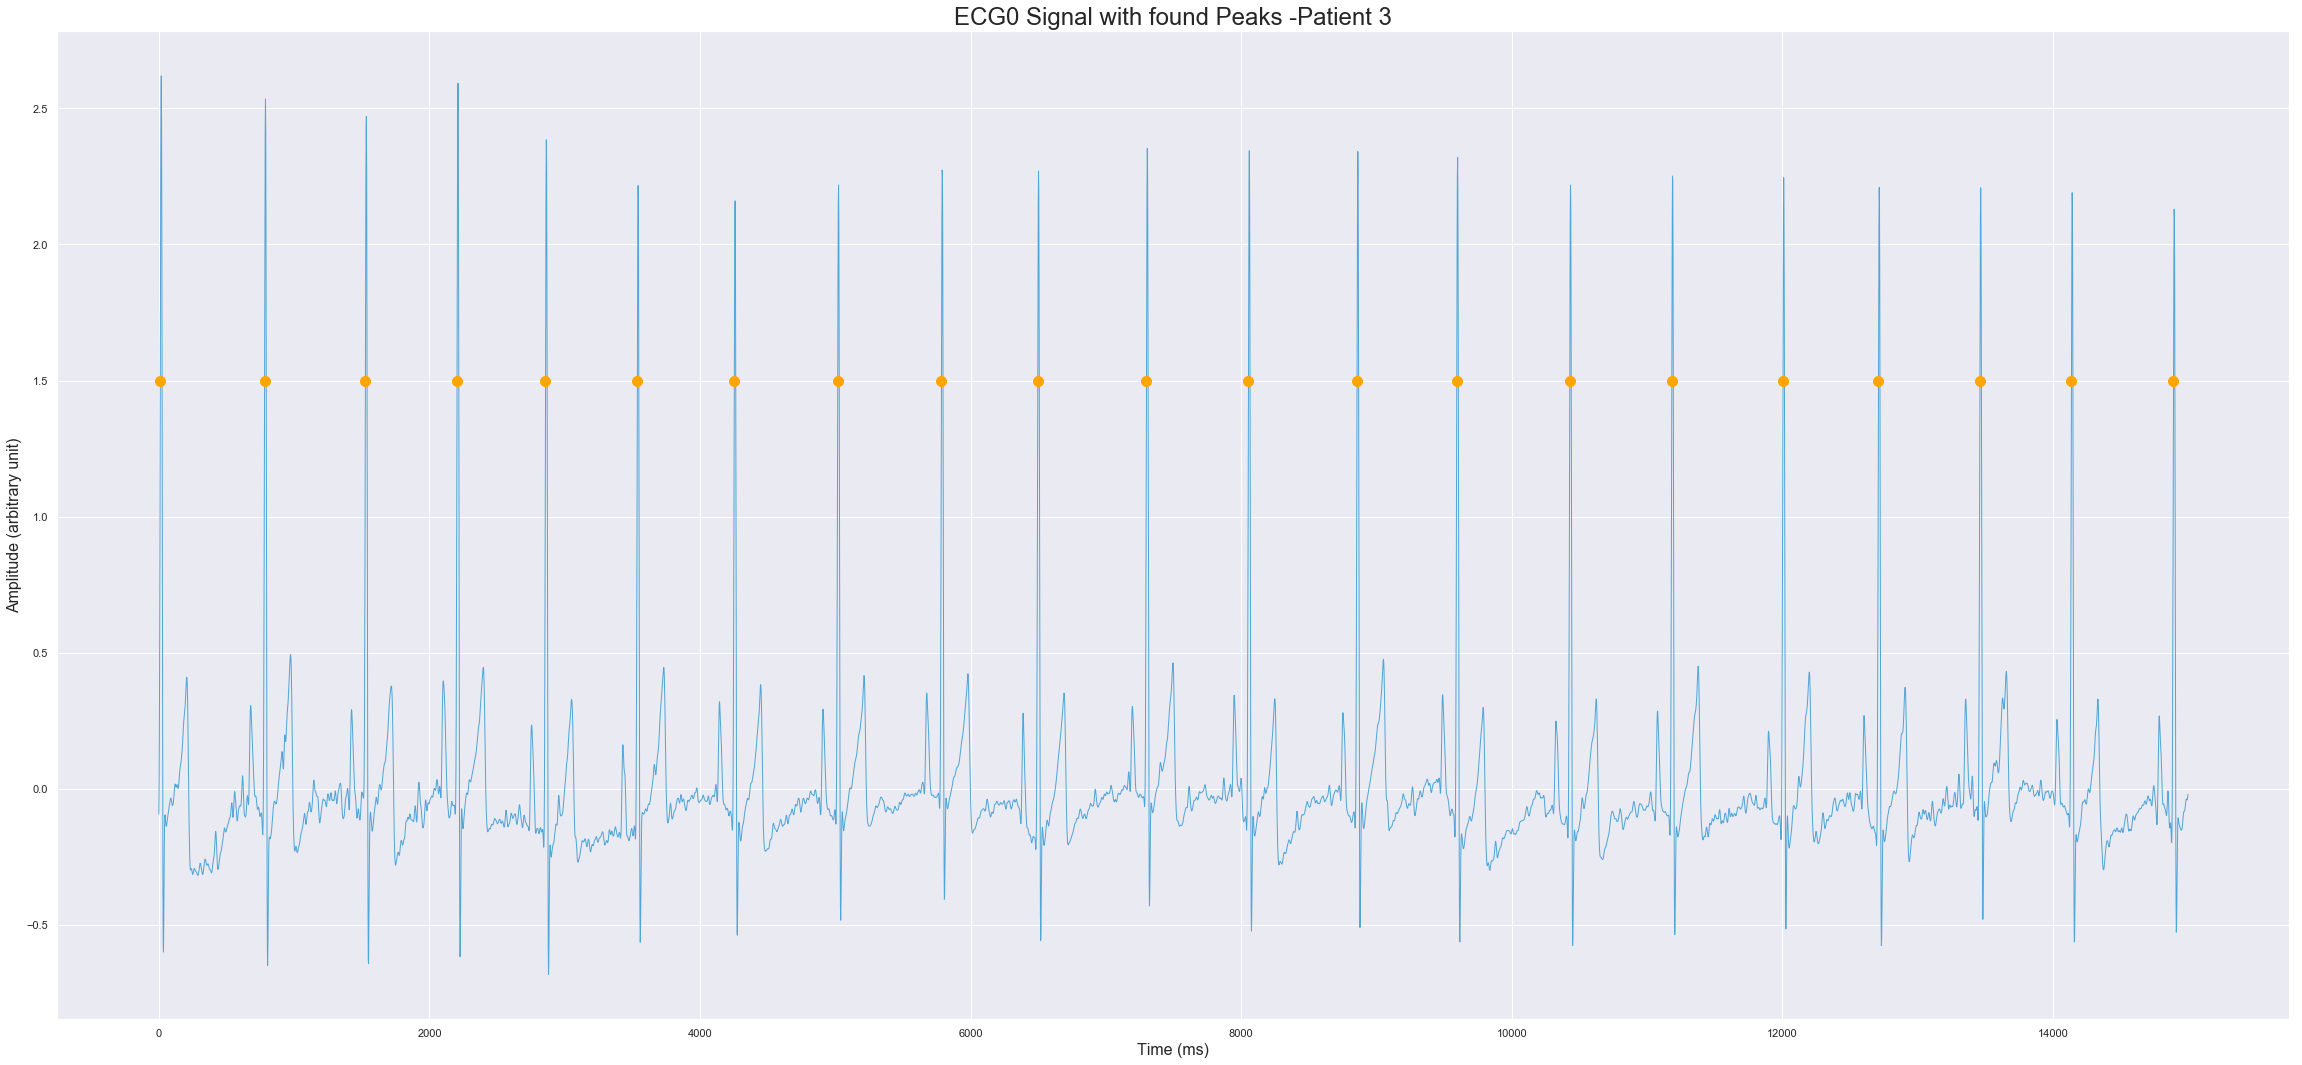

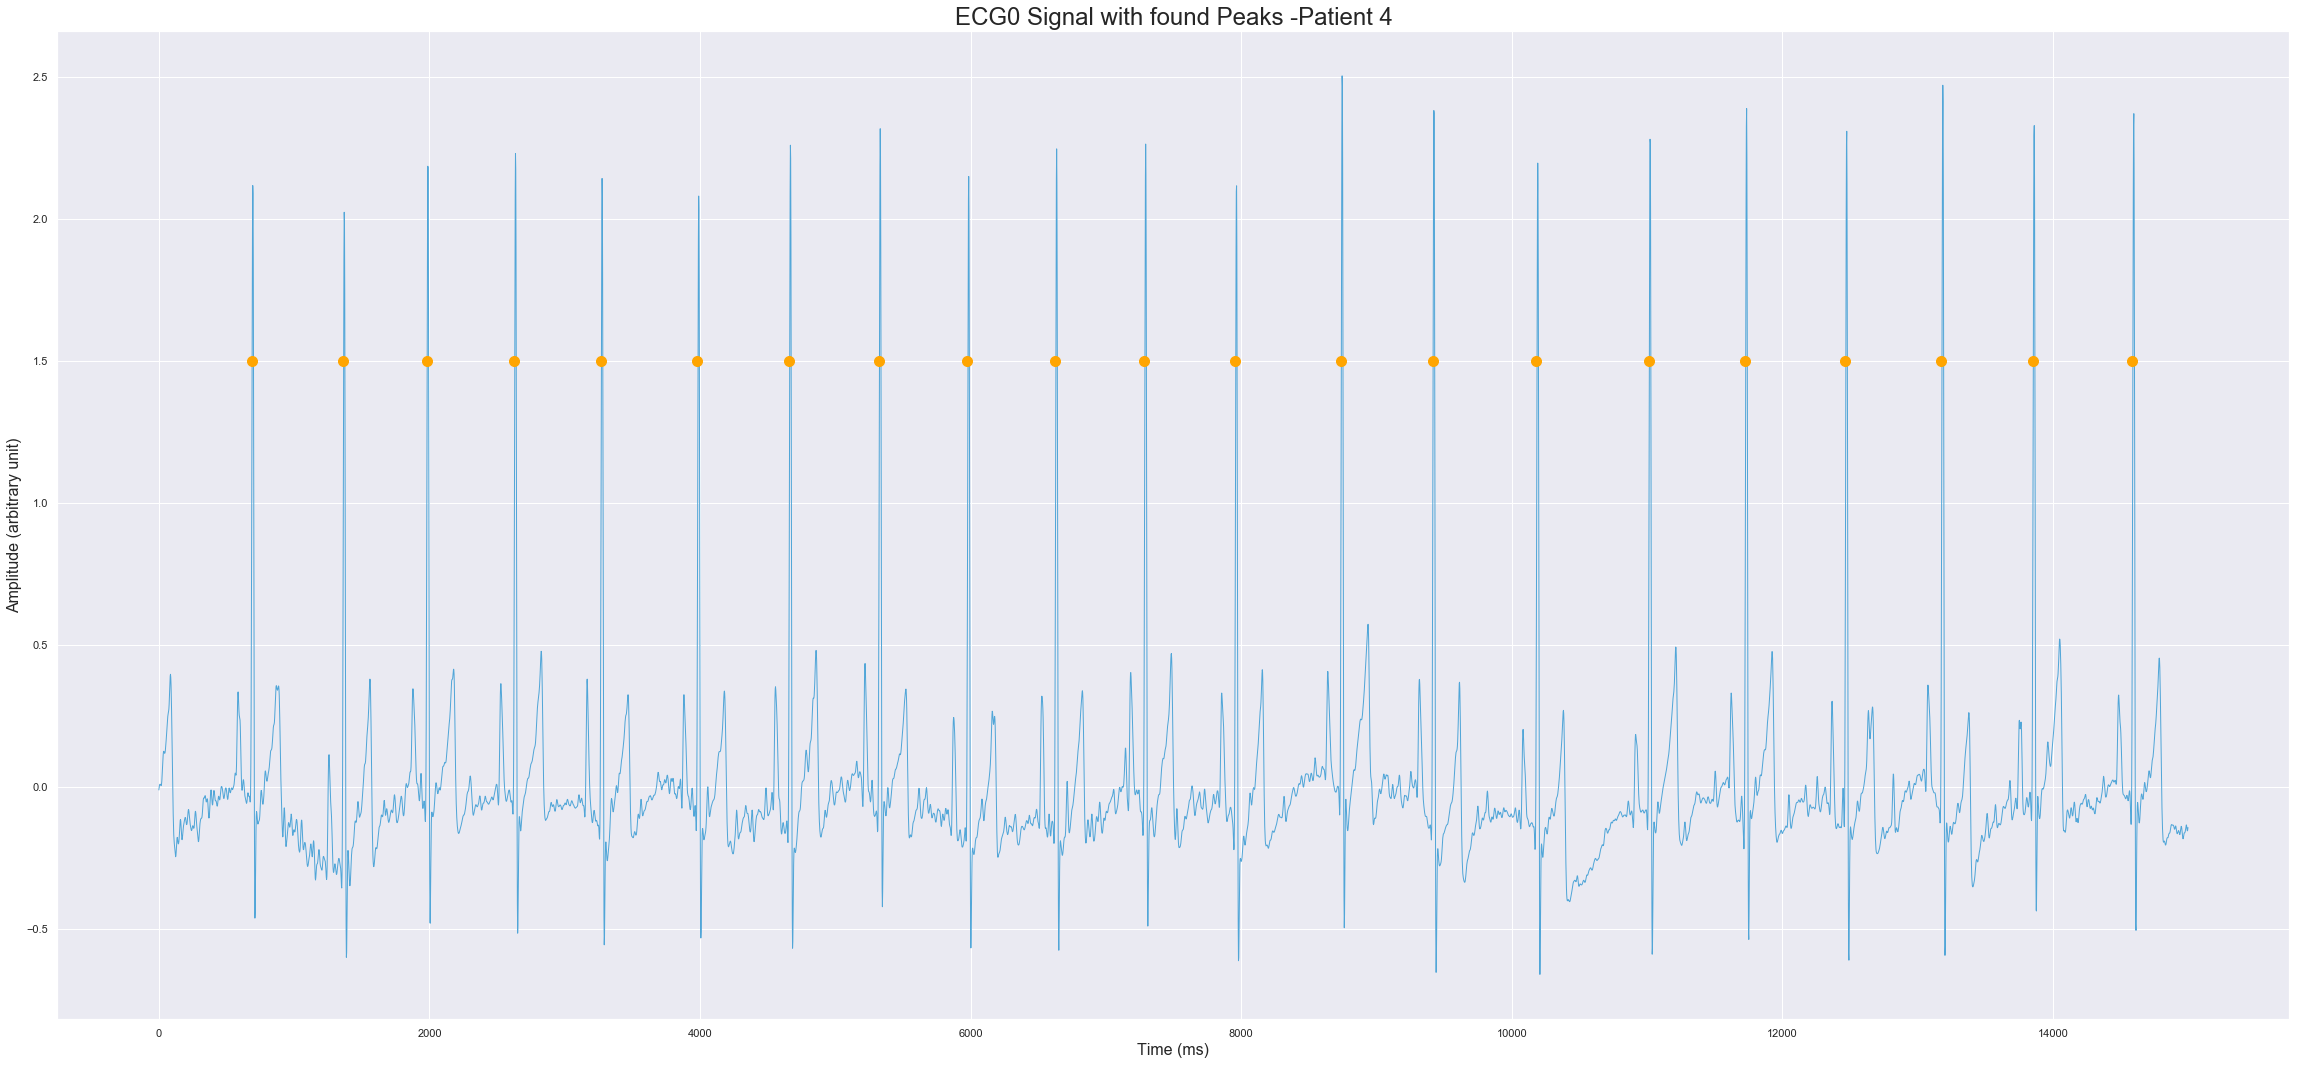

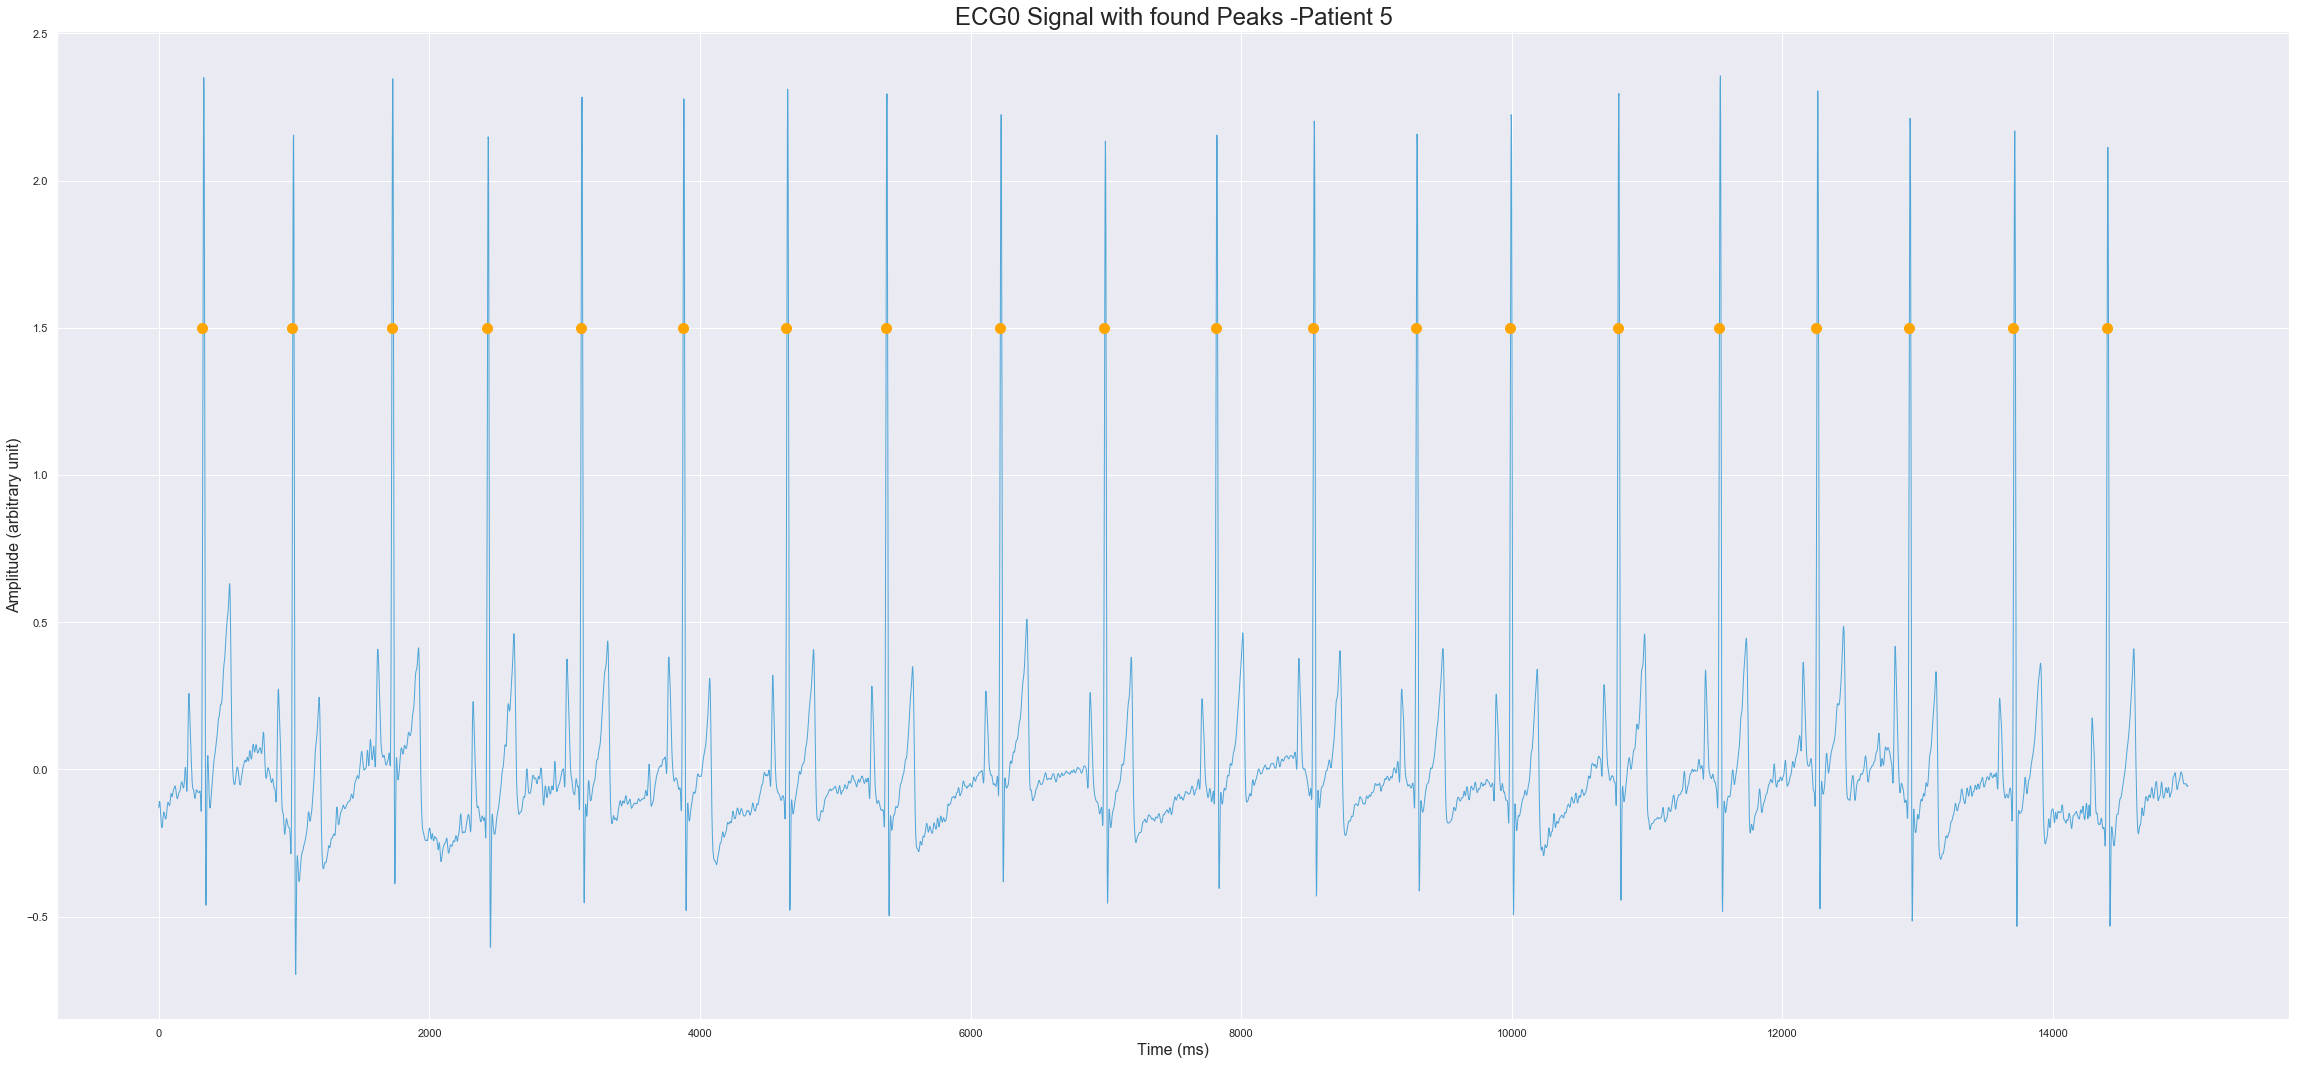

In [27]:
# Affichage du signal brut et des points detectés par l'algorithme d'Andrew Tan. 
for i in ECGs_dic :

    plt.figure(figsize=(40, 40))
    plt.subplot(211)
    plt.title("ECG0 Signal with found Peaks -Patient {}".format(i['patient :']), fontsize=24)
    plt.plot(i['ECG '].ms, i['ECG '].heartrate, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(i['r_peaks'], np.repeat(1.5, len(i['r_peaks'])), markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
    plt.xlabel("Time (ms)", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)

<a id='3'></a>

<a id='3'></a>
# Analyse de la VFC

La Variabilité de la Fréquence Cardiaque est une information très importante. La VFC correspond à la variation de temps entre chaque battement du coeur. Cette variation est contrôlée par le Système Nerveux Autonome (SNA), lui même subdivisé en deux sous catégories : le système nerveux sympathique, et le système nerveux parasympathique. C'est un excellent marqueur diagnostique et pronostique.

Le Système Nerveux Sympathique (SNS) augmente la fréquence cardiaque pour mobiliser l'organisme dans les situations d'urgence ou d'activité physique.

Le Système Nerveux Parasympathique (ou système vagal) est globalement sédatif. Il diminue le rythme cardiaque.

Ces deux parties du système nerveux sont normalement dans un équilibre sain, provoquant une variation naturelle des battements du cœur. Si cet équilibre est perturbé pour une raison quelconque, cette variance changera.

Quantifier cet variation avec la VFC permet d'évaluer le tonus du SNA. Une baisse de la VFC est corrélée aux défaillances d'organes et à la mortalité.

Il existe plusieurs méthodes pour calculer la VFC.

### Analyse temporelle statistique

<a id='3.1'></a>
#### Calcul interval RR / Periodigramme

L’analyse statistique est une analyse statistique d’une donnée, la
suite temporelle des intervalles RR.

Maintenant que nous avons les coordonnées des pics R, nous pouvons calculer les intervalles entre chaque point.

In [22]:
# Les RRi sont obtenus en faisant la différenece
for i in range(len(ECGs_dic)) :
    
    ECGs_dic[i]['rr'] = np.diff(ECGs_dic[i]['r_peaks']) 

In [12]:
print(ECGs_dic[0]['rr']) 

[588 565 552 536 498 521 521 647 598 760 626 742 671 701 610 812 643 785
 726 680 744 692]


In [13]:
print(ECGs_dic[1]['rr']) 

[696 792 646 729 705 671 756 799 662 726 732 674 756 752 704 822 684 798
 686]


In [14]:
print(ECGs_dic[2]['rr']) 

[638 704 743 739 704 691 663 663 659 794 704 684 652 638 686 684 747 719
 856 806]


In [15]:
print(ECGs_dic[3]['rr']) 

[770 746 678 652 678 718 764 767 711 804 754 802 738 834 755 821 706 750
 677 754]


In [21]:
print(ECGs_dic[4]['rr']) 

[676 618 647 640 714 678 664 654 650 658 672 781 678 767 831 713 740 710
 676 736]


In [16]:
print(ECGs_dic[5]['rr']) 

[664 734 705 693 753 767 734 844 770 825 720 759 697 795 750 720 683 773
 688]


#### Les indices

Il existe plusieurs méthodes de calcul de la VFC :

- <b>RR Moyen</b> : 
Il correspond à la moyenne de l’ensemble des intervalles RR de l’échantillon. D’un
point de vue physiologique, ce paramètre est influencé par les deux voies du SNA ; le SNP
provoque une bradycardie donc une augmentation du RR moyen alors que le SNS provoque
une tachycardie donc une diminution de RR moyen. Avec RR moyen, il est impossible de
repérer l’influence de l’un ou de l’autre car les modulations du tonus du SNP et SNS peuvent
l’augmenter ou le diminuer.


- <b>SDNN</b> :
Mathématiquement, SDNN correspond à l’écart type de l’échantillon d’intervalle RR, soit la
racine carrée de la variance. Ce paramètre renseigne sur la dispersion globale de
l’échantillon autour de sa moyenne. Plus la durée de l’échantillon sera grande, plus cela
favorise un SDNN élevé. Du point de vue physiologique, ce paramètre représente les variations globales sur la durée de l’échantillon. Il est considéré comme un marqueur de l’activité des deux voies du SNA, et donc de l’activité globale et la variance associée. Plus l’échantillon sera court, plus il nous
renseignera sur de la variabilité à court terme et nous renseignera sur l’importance su SNP.


- <b>RMSSD</b> :
Tire son nom de l’anglais Root Mean Square of sucessive differences. Il représente la
racine carrée de la moyenne des différences au carré des intervalles R-R successifs. Pour
faire plus simple, c’est la moyenne des différences entre les RR adjacents. L’utilisation de la
racine carrée et de la fonction puissance permet de travailler avec des valeurs absolues et
donc de ne pas avoir de valeurs négatives. Physiologiquement, RMSSD nous renseigne sur les variations intervenant d’un intervalle RR à son suivant. Il s’agit donc de régulation à très court terme. Ce paramètre reflète principalement l’activité du SNP.


- <b>NN50</b> :
NN50 est le nombre d’intervalles RR qui différent de plus de 50 millisecondes de leur
précédent. Cette valeur seule n’est pas très instructive, c’est pourquoi on la rapporte sur le
nombre d’intervalles de l’échantillon pour obtenir pNN50, qui correspond au pourcentage
de NN50 dans la suite analysée. Cet indice est un marqueur direct du SNP.

(source)

In [17]:
def timedomain(rr):
    results = {}
    
    hr = 60000/rr
    
    # mean RR-interval
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    
    return results

In [18]:
for i in range(len(ECGs_dic)) :
    
    print("Time domain metrics - automatically corrected RR-intervals - Patient {}:".format(i))
    
    for k, v in timedomain(ECGs_dic[i]['rr']).items():
        
            print("- %s: %.2f" % (k, v))
    
    print('-' * 80)

Time domain metrics - automatically corrected RR-intervals - Patient 0:
- Mean RR (s): 646.27
- STD RR/SDNN (ms): 90.46
- Mean HR (Kubios' style) (beats/min): 92.84
- Mean HR (beats/min): 94.71
- STD HR (beats/min): 13.48
- Min HR (beats/min): 73.89
- Max HR (beats/min): 120.48
- RMSSD (ms): 96.36
- NNxx: 12.00
- pNNxx (%): 54.55
--------------------------------------------------------------------------------
Time domain metrics - automatically corrected RR-intervals - Patient 1:
- Mean RR (s): 725.79
- STD RR/SDNN (ms): 50.27
- Mean HR (Kubios' style) (beats/min): 82.67
- Mean HR (beats/min): 83.06
- STD HR (beats/min): 5.66
- Min HR (beats/min): 72.99
- Max HR (beats/min): 92.88
- RMSSD (ms): 88.83
- NNxx: 12.00
- pNNxx (%): 63.16
--------------------------------------------------------------------------------
Time domain metrics - automatically corrected RR-intervals - Patient 2:
- Mean RR (s): 708.70
- STD RR/SDNN (ms): 56.60
- Mean HR (Kubios' style) (beats/min): 84.66
- Mean HR (

La plupart des mesures sont similaires à celles obtenues avec Kubios. Il faut cependant revoir le STD HR. 

### Analyse temporelle géométrique

In [26]:
# Effectuée sur Kubios ?

# Analyse spectrale
<a id='4'></a>

### Interpolation

Pour calculer la densité spectrale il est nécessaire d'interpoler le signal du périodogramme.

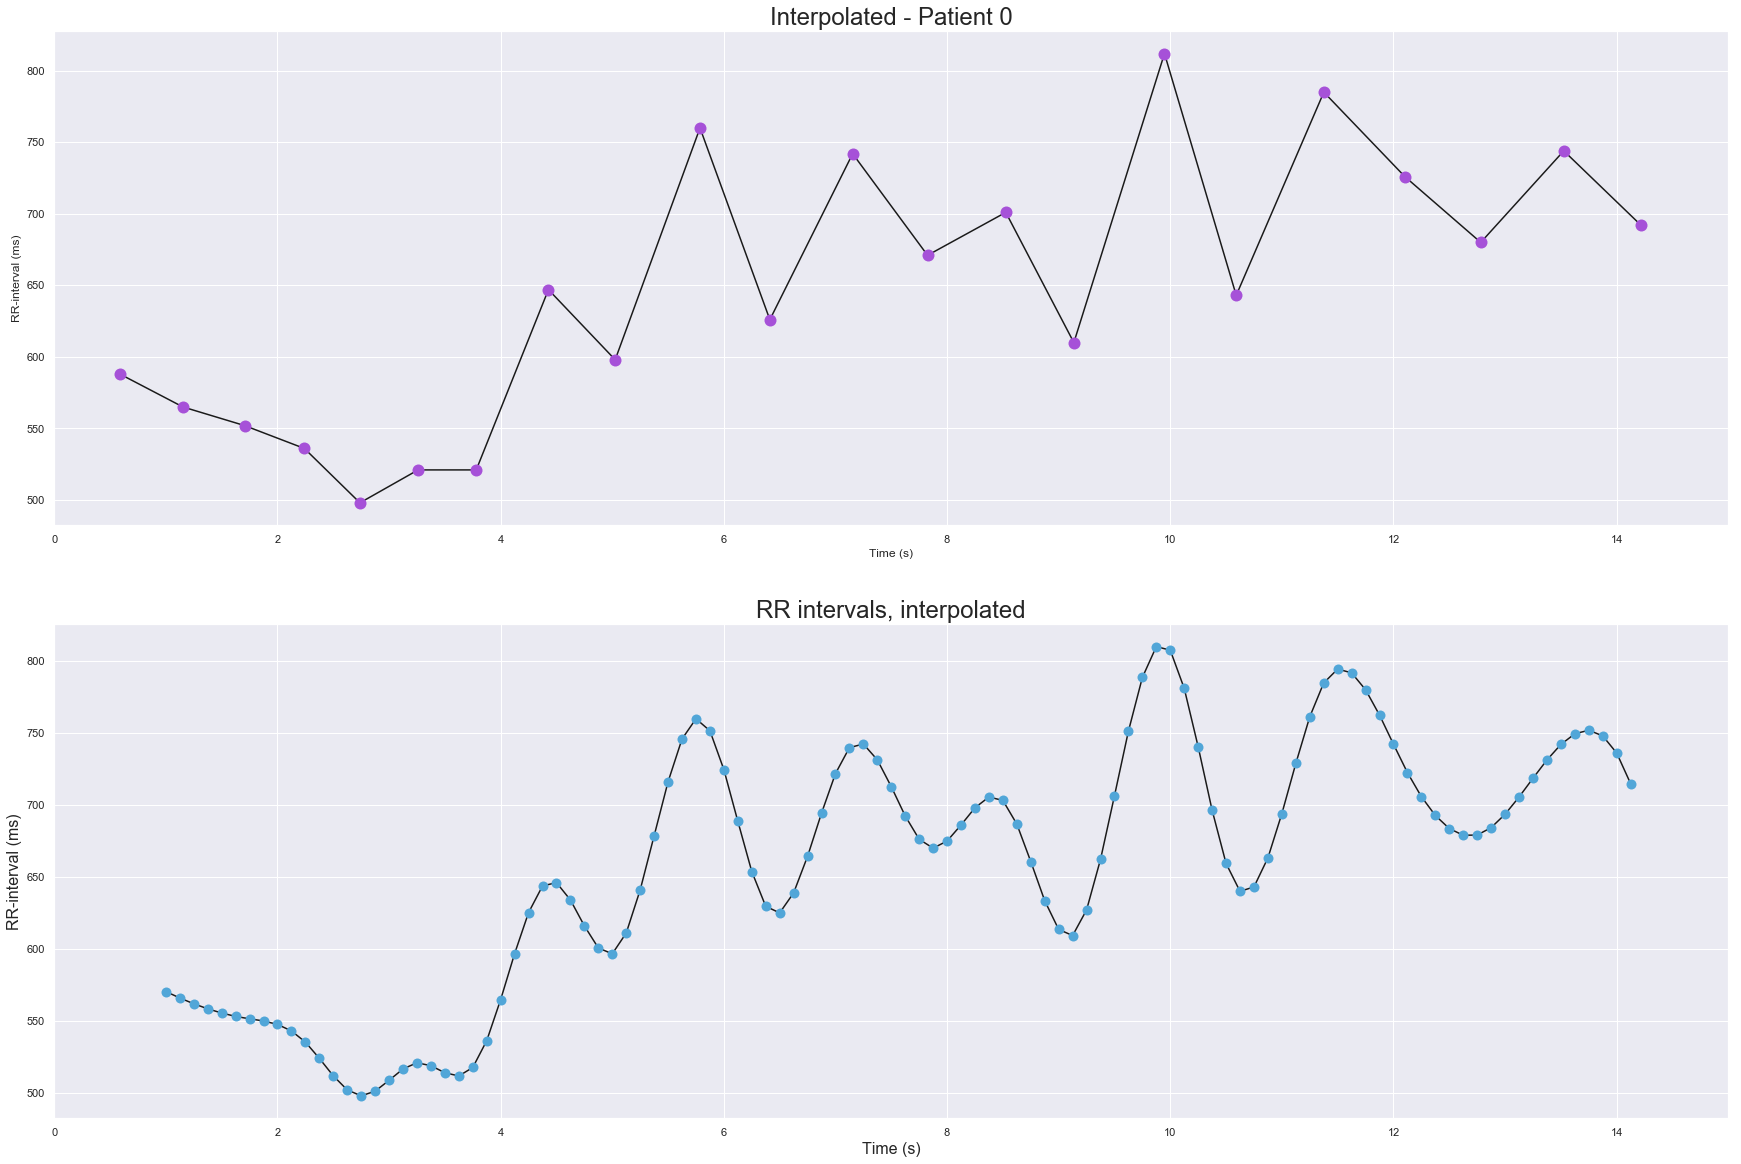

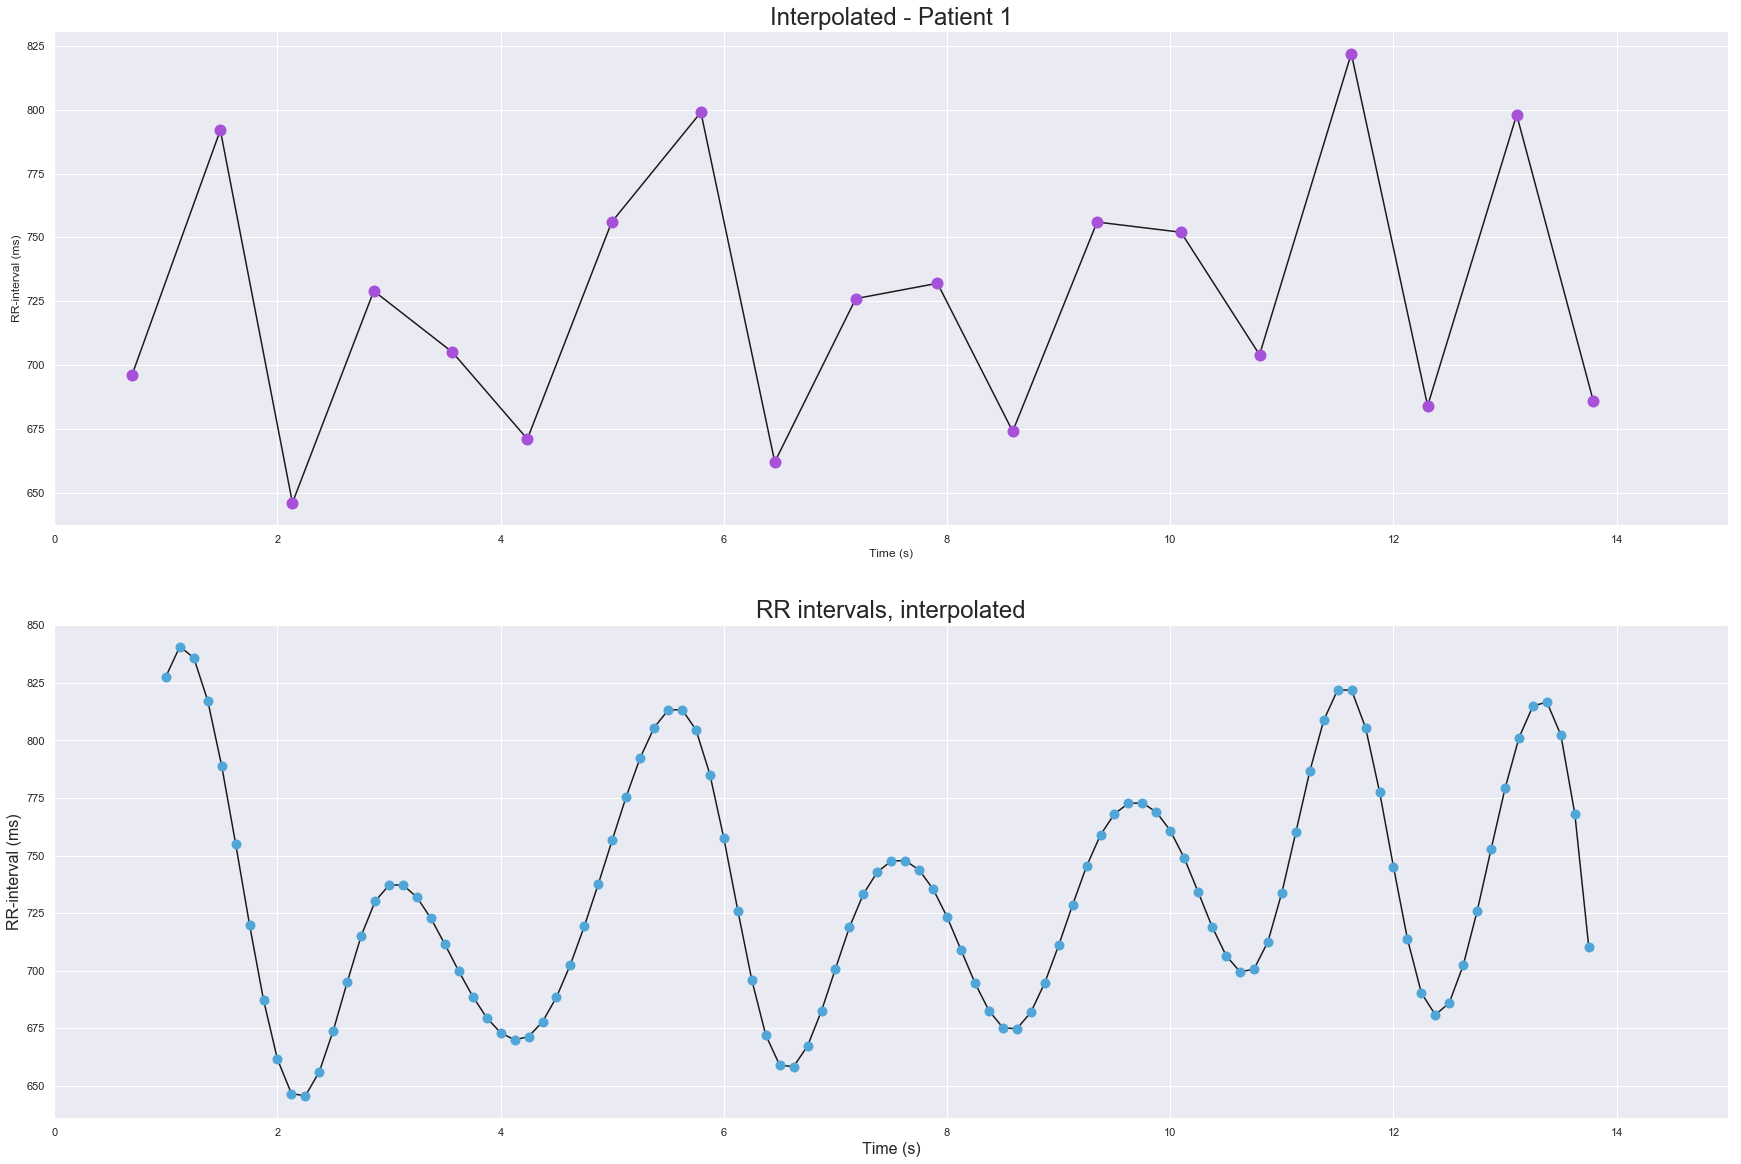

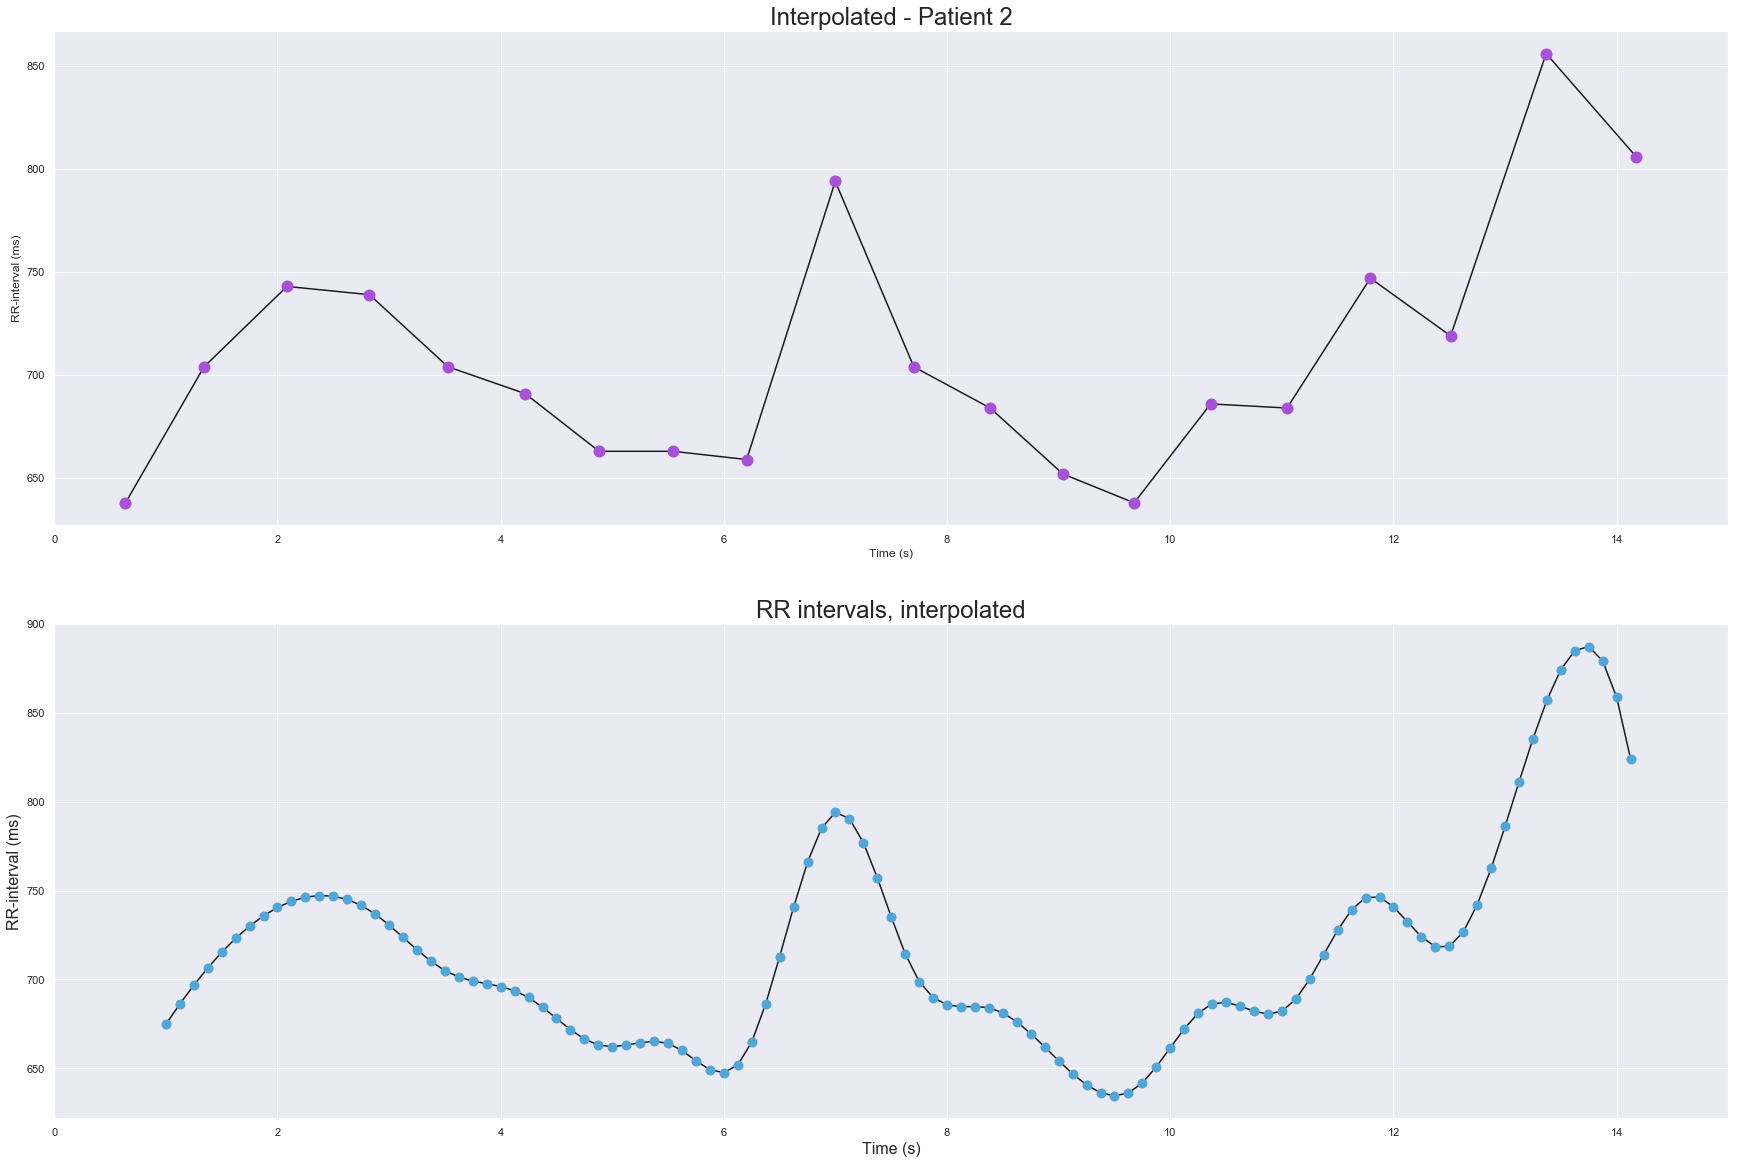

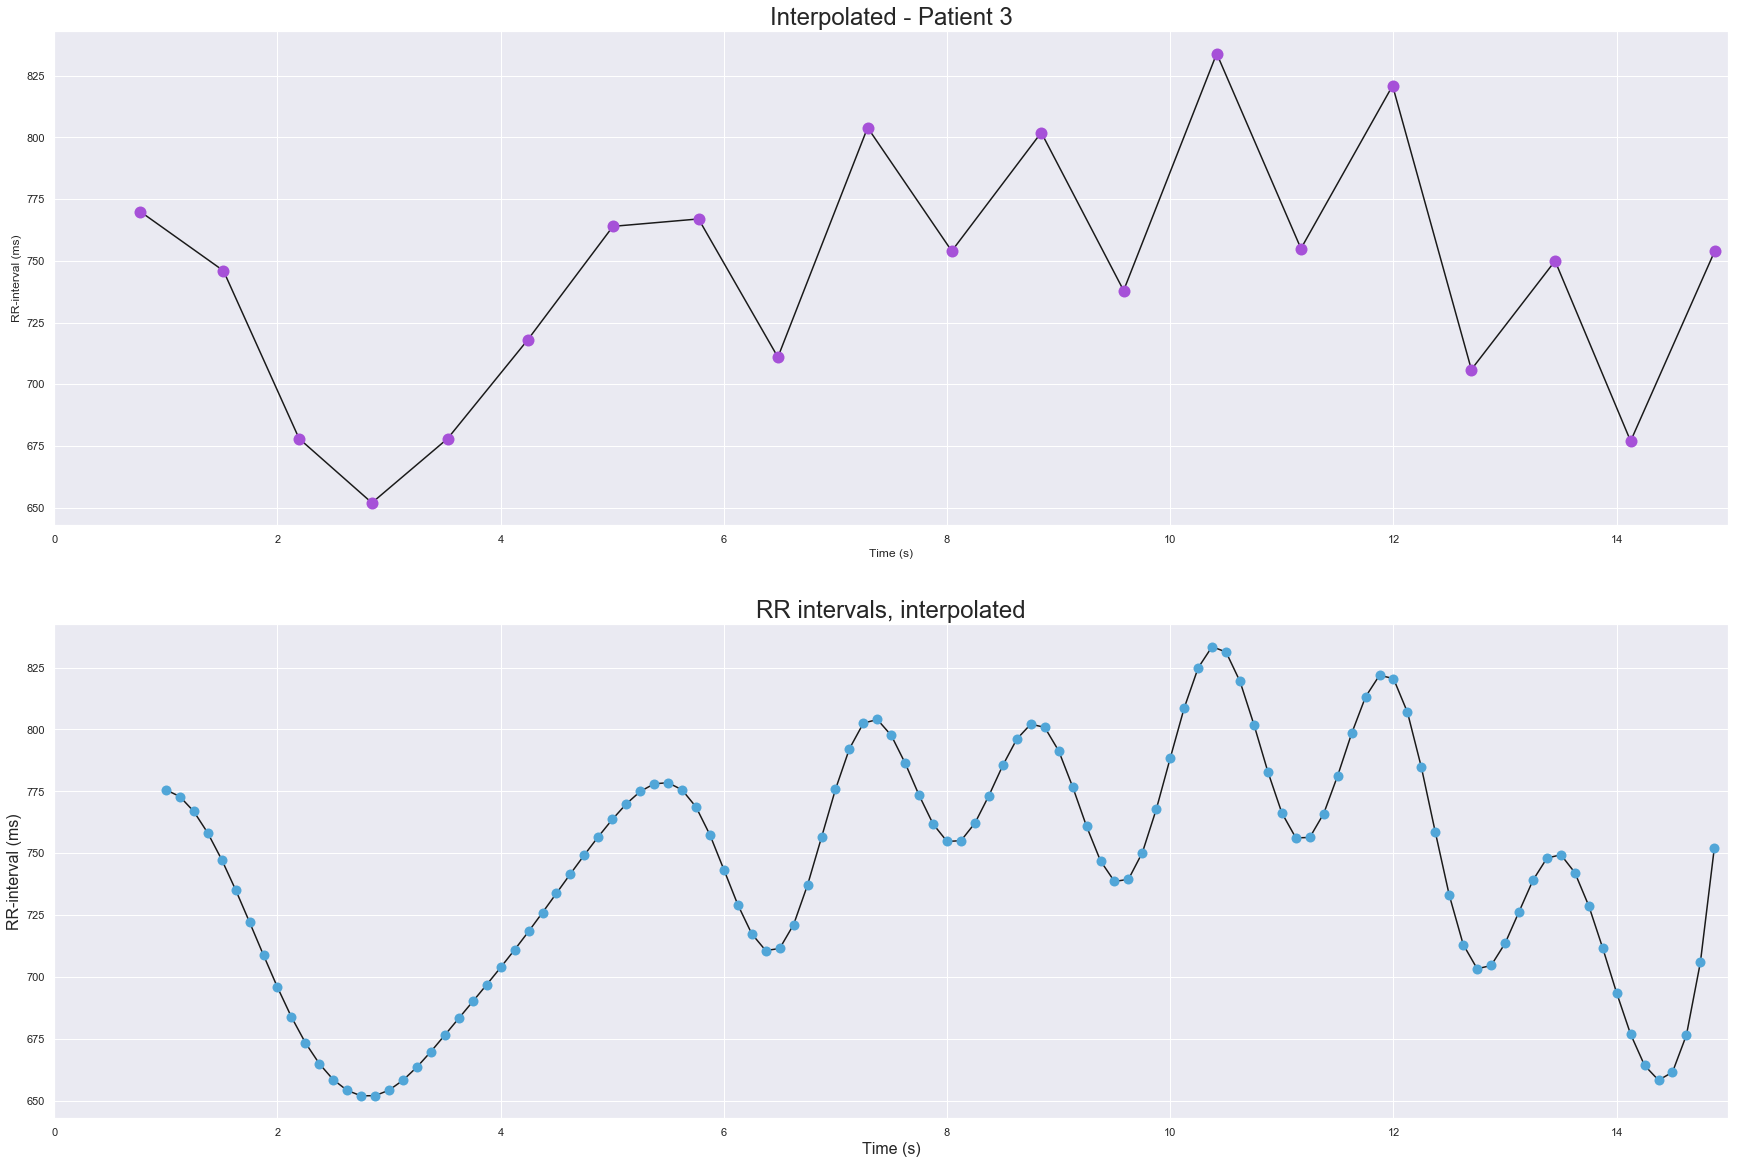

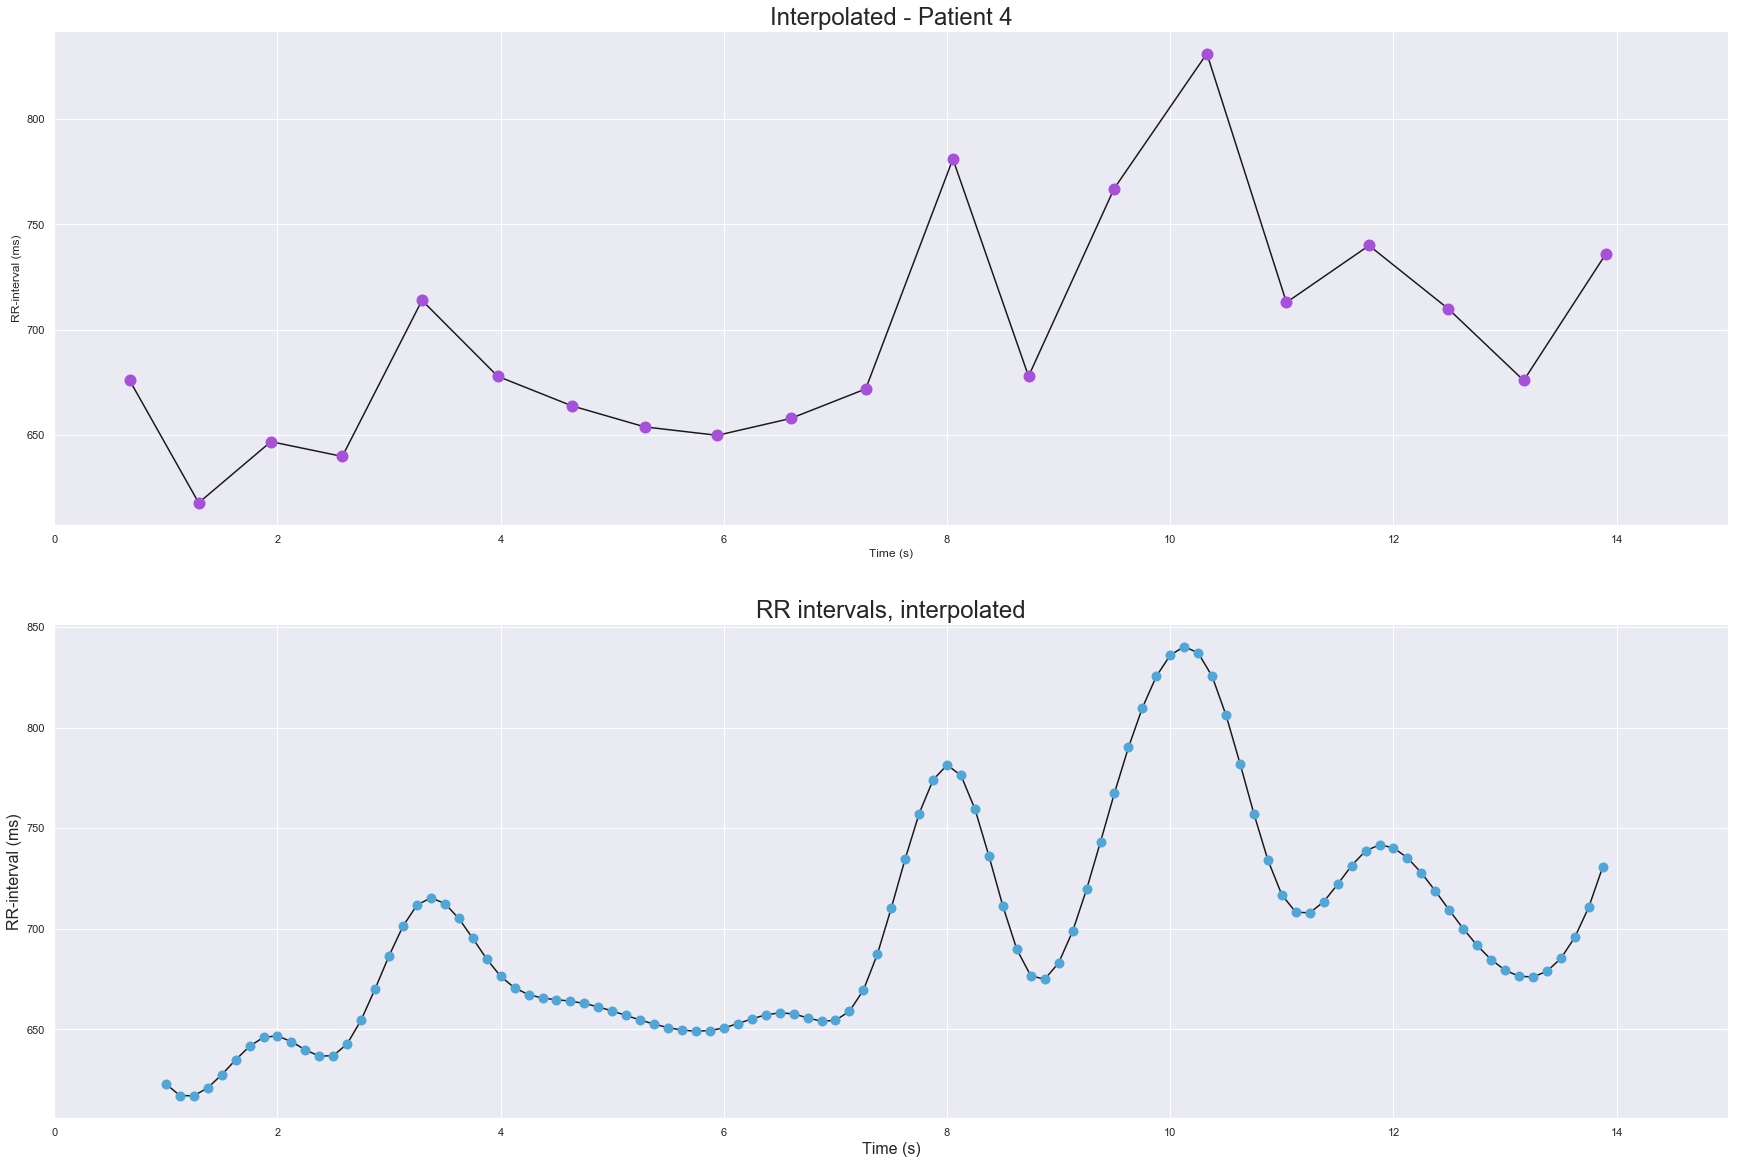

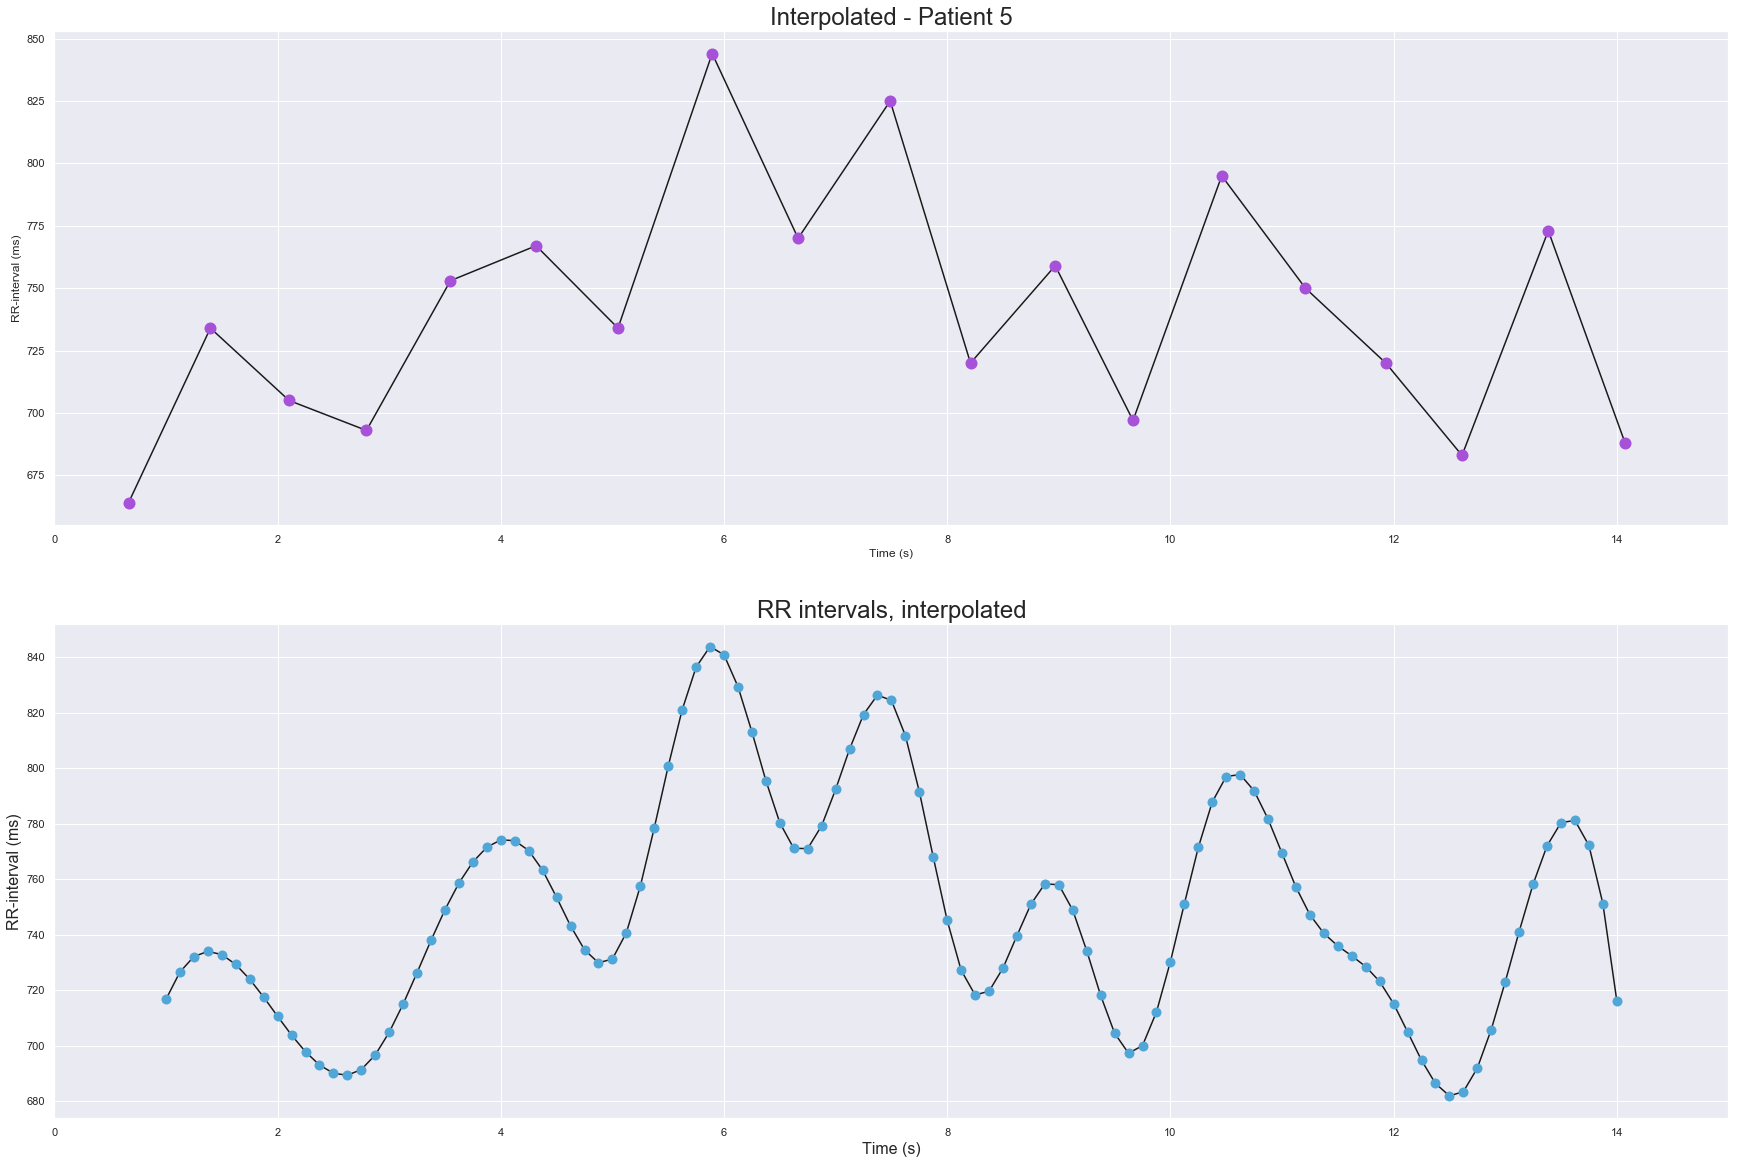

In [19]:
for i in range(len(ECGs_dic)) :

    # sample rate for interpolation
    fs = 8.0
    steps = 1 / fs

    # create interpolation function based on the rr-samples. 
    x = np.cumsum(ECGs_dic[i]['rr']) / 1000.0
    f = interp1d(x, ECGs_dic[i]['rr'], kind='cubic') 

    # now we can sample from interpolation function
    xx = np.arange(1, np.max(x), steps)
    rr_interpolated = f(xx)
    ECGs_dic[i]['rri'] = rr_interpolated
    
    #Plot
    plt.figure(figsize=(30, 20))

    plt.subplot(211)
    plt.title("RR intervals", fontsize=24)
    plt.plot(x, ECGs_dic[i]['rr'], label="RR-Intervals", color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=12) 
    plt.xlabel("Time (s)") 
    plt.ylabel("RR-interval (ms)") 
    plt.title("Interpolated - Patient {}".format(ECGs_dic[i]['patient :']), fontsize=24) 
    plt.gca().set_xlim(0, 15) 

    plt.subplot(212) 
    plt.title("RR intervals, interpolated", fontsize=24) 
    plt.plot(xx, rr_interpolated, label="RR-Intervals (interpolated)", color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=10)
    plt.gca().set_xlim(0, 15)
    plt.xlabel("Time (s)", fontsize=16) 
    plt.ylabel("RR-interval (ms)", fontsize=16)

# Mesurer VF, LF et HF - Calculer LF/HF

Pour une évaluation du SNA, on décompose généralement le spectre en différentes bandes
de fréquences.

- Les Hautes Fréquences (HF) sur une plage de 0,15 à 0,40 Hz. Du point de vue physiologique, les boucles de contrôle de cet ordre sont quasi exclusivement liées au SNP. Cette bande de fréquences situées sur la partie droite du spectre reflète donc une activité parasympathique.


- Les Basses Fréquences (BF) correspondent à la plage de 0,04 à 0,15 Hz. Physiologiquement, cette bande de spectre englobe l’activité du SNS mais également une partie de celle du SNP. Sur cette bande de fréquences, on trouve généralement un pic autour de 0,10 Hz appelé « onde de Mayer ». Les mécanismes liés à ce pic ne sont pas encore complètement élucidés mais il semble qu’il y ait un lien entre celui-ci et la régulation baroréflexe de la PA (Task Force 1996)


Pour toutes ces bandes, il est possible de quantifier la puissance correspondante. Cette
puissance est directement reliée au tonus du SNS et SNP. De plus, le repérage du pic de
fréquence, symbolisé par les lignes en pointillés sur la Figure 64 donne des indications sur la
fréquence dominante des boucles de contrôle.

La puissance des bandes HF, LF, VLF est donnée en ms². La Puissance Totale (PT)
peut être calculée comme la somme des puissances pour des fréquences supérieures à 0,04
Hz (HF + LF)

Le rapport LF / HF donne la balance sympatho-vagale. 



********************************************************************************
Frequency domain metrics - patient 0 :
- Power VLF (ms2): 708.70
- Power LF (ms2): 208.75
- Power HF (ms2): 1714.64
- Power Total (ms2): 2632.09
- LF/HF: 0.12
- Peak VLF (Hz): 0.04
- Peak LF (Hz): 0.11
- Peak HF (Hz): 0.34
- Fraction LF (nu): 10.85
- Fraction HF (nu): 89.15
********************************************************************************
Frequency domain metrics - patient 1 :
- Power VLF (ms2): 38.27
- Power LF (ms2): 156.01
- Power HF (ms2): 1391.56
- Power Total (ms2): 1585.83
- LF/HF: 0.11
- Peak VLF (Hz): 0.04
- Peak LF (Hz): 0.12
- Peak HF (Hz): 0.23
- Fraction LF (nu): 10.08
- Fraction HF (nu): 89.92
********************************************************************************
Frequency domain metrics - patient 2 :
- Power VLF (ms2): 262.13
- Power LF (ms2): 528.64
- Power HF (ms2): 660.47
- Power Total (ms2): 1451.25
- LF/HF: 0.80
- Peak VLF (Hz): 0.00
- Peak LF (Hz): 0.11
- Peak 

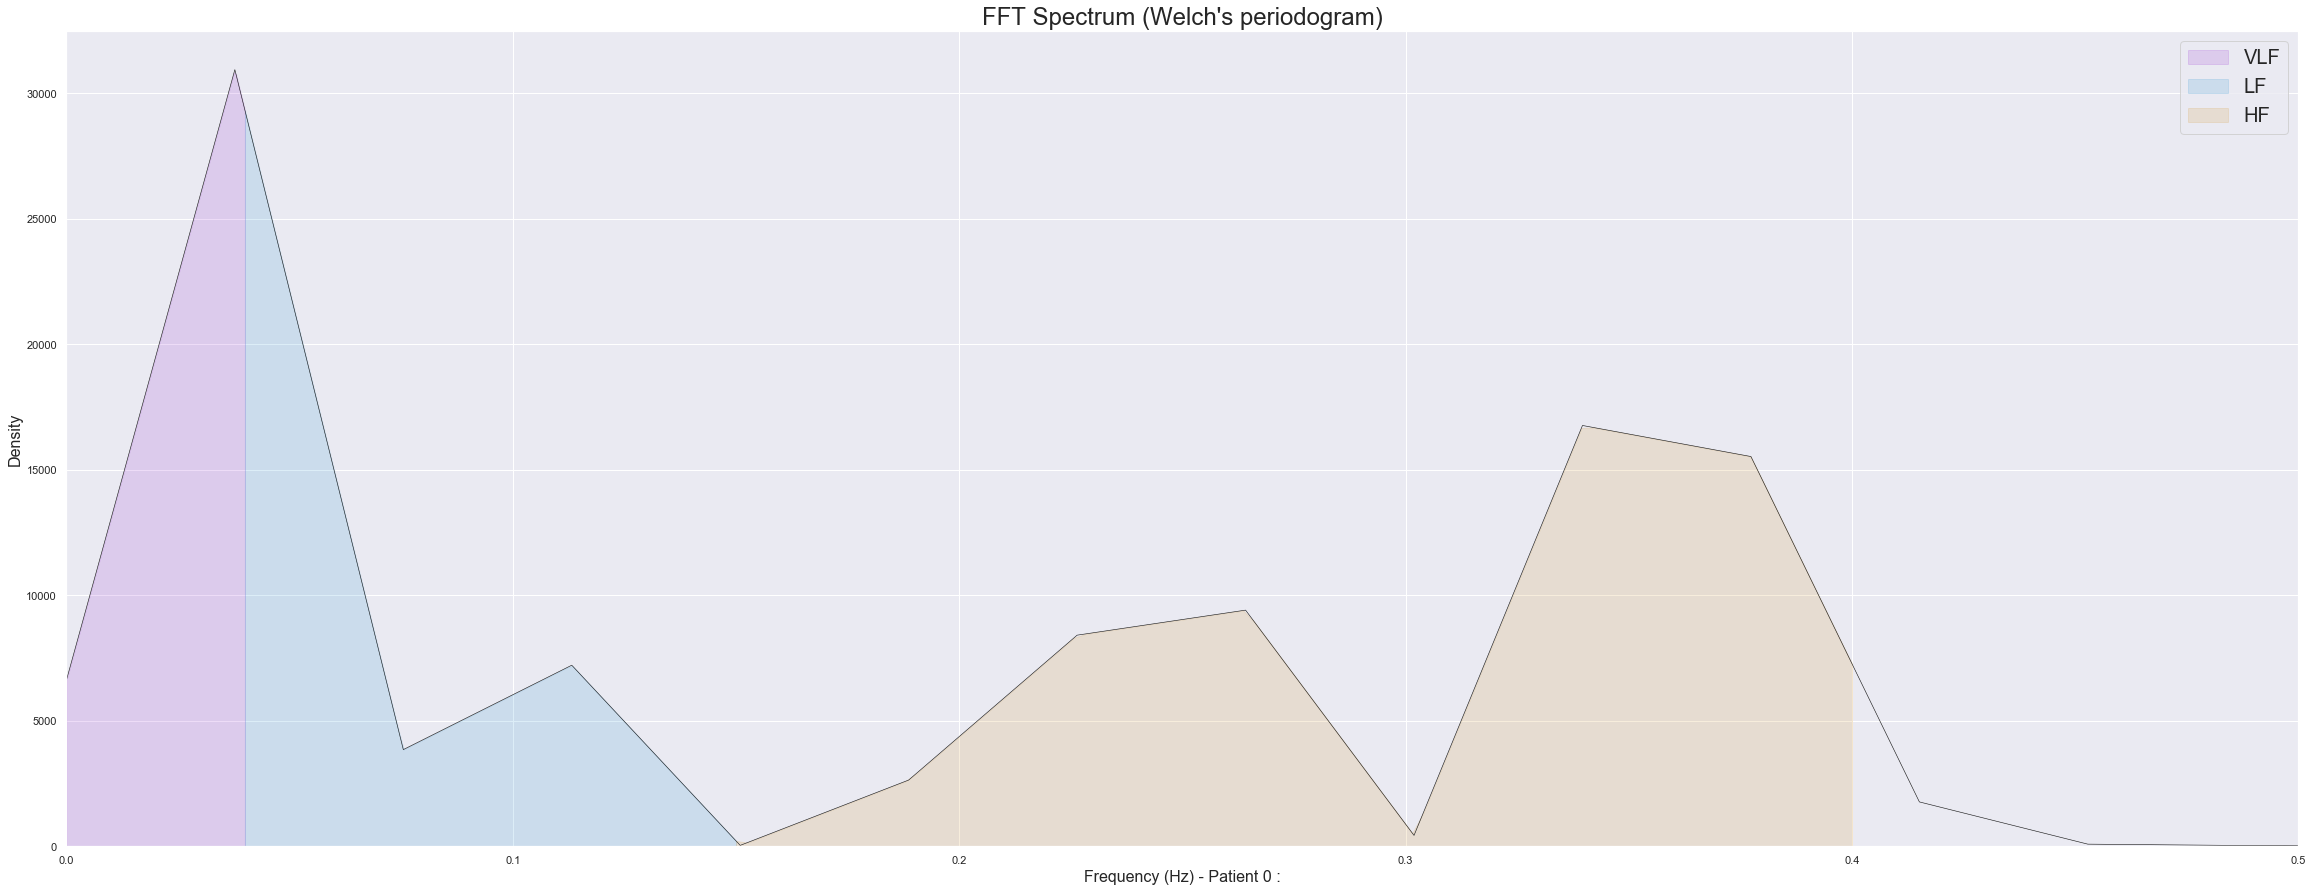

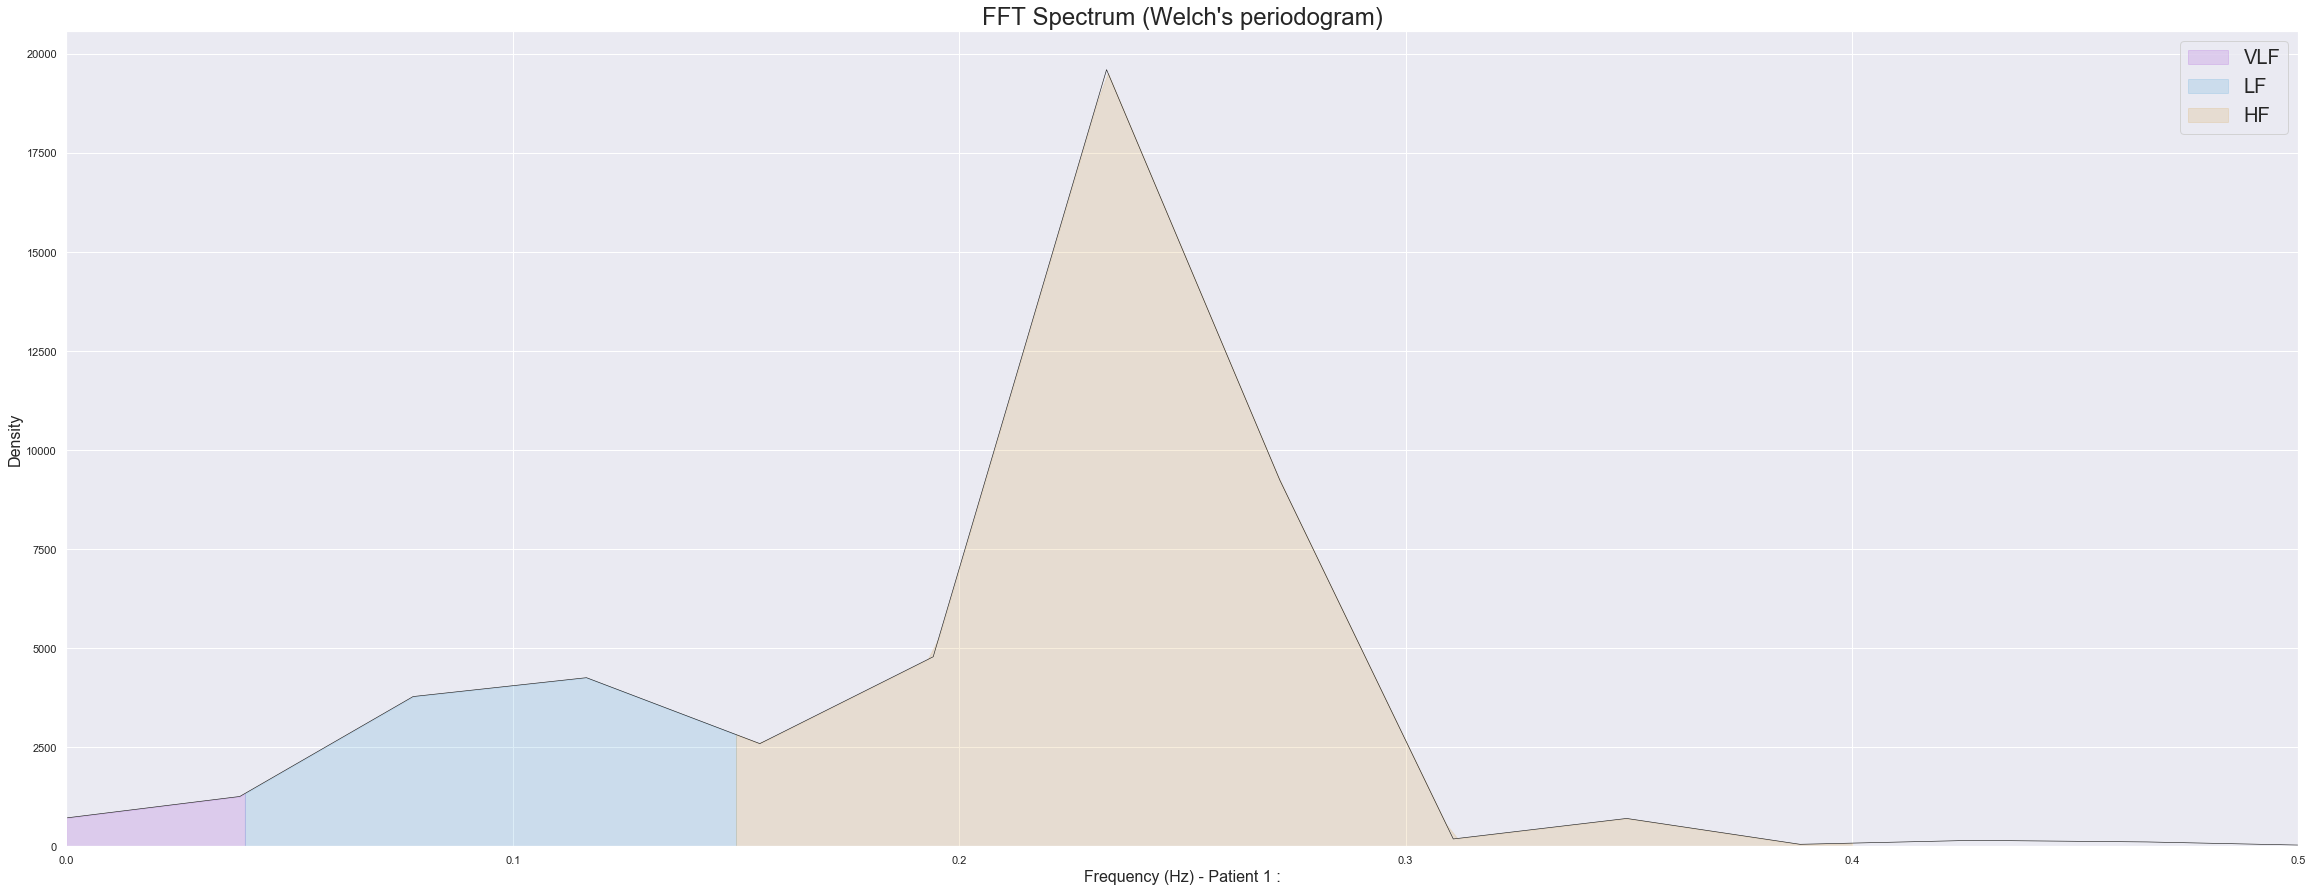

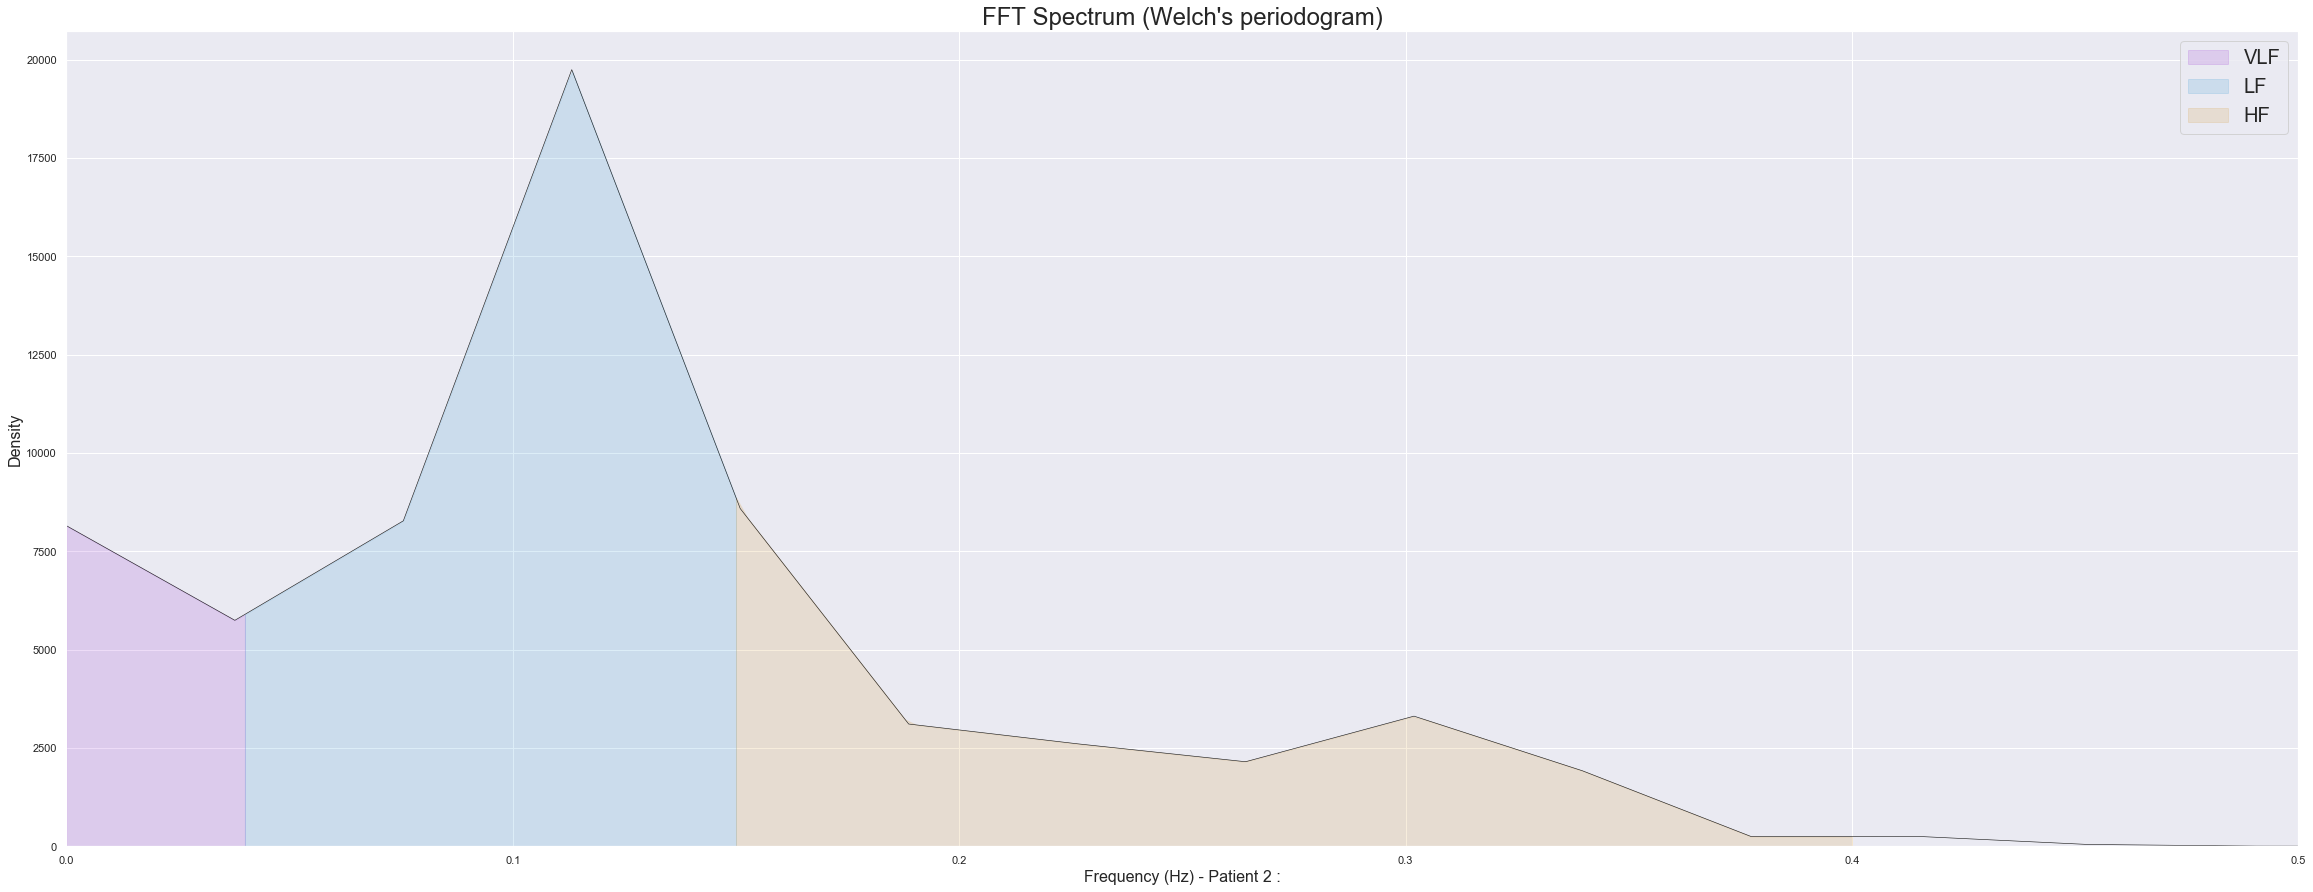

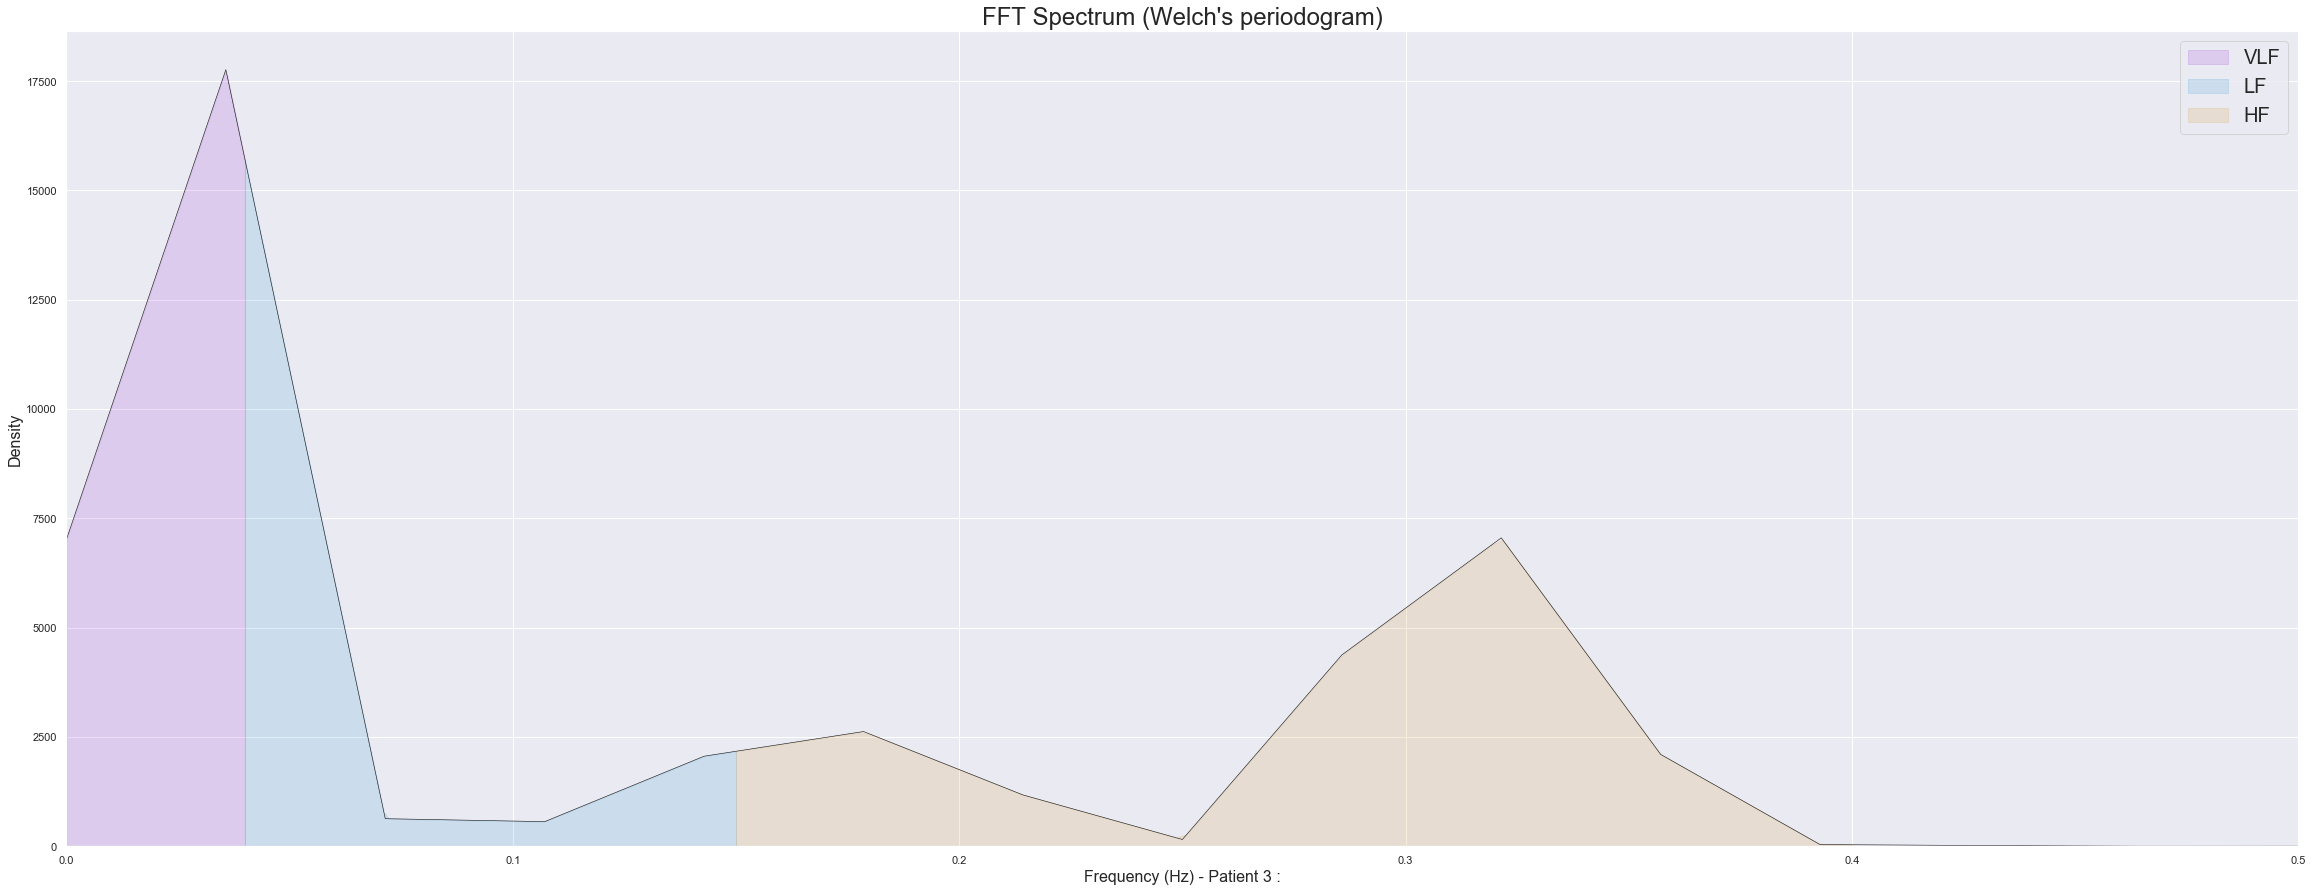

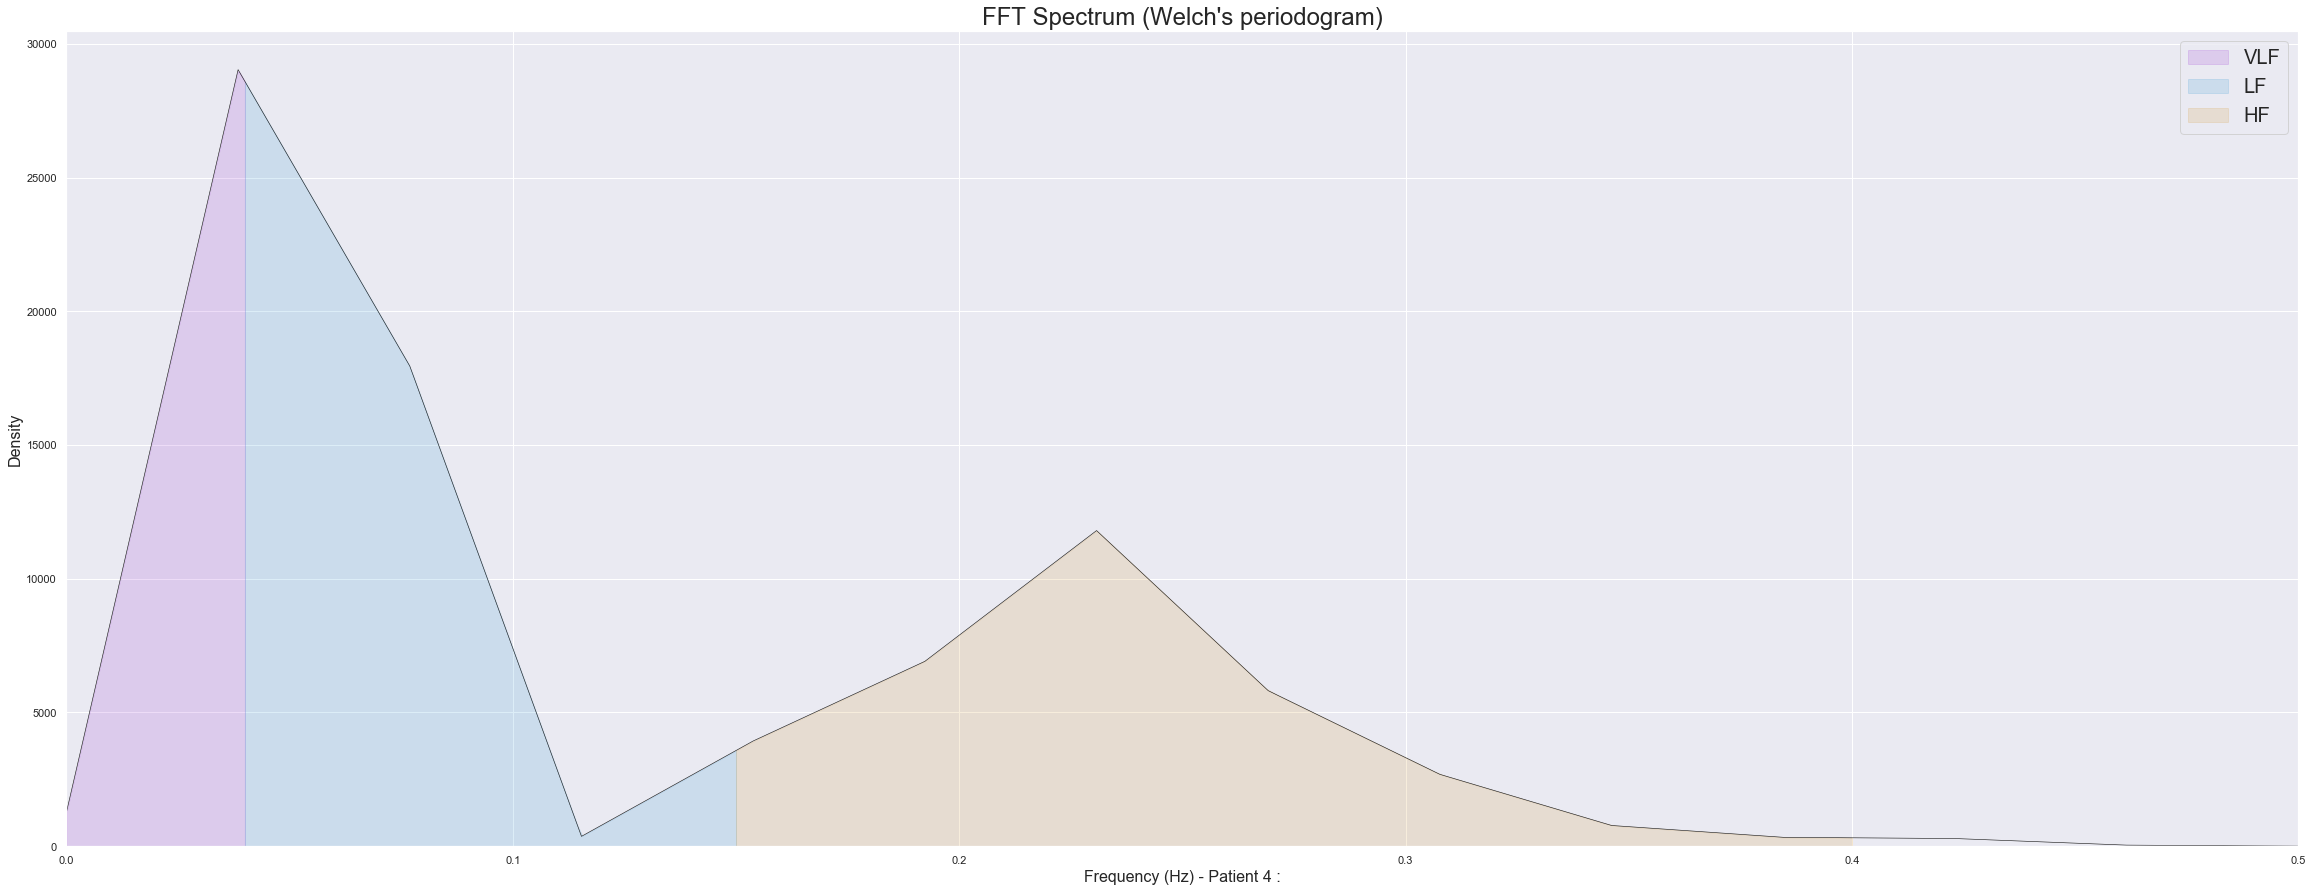

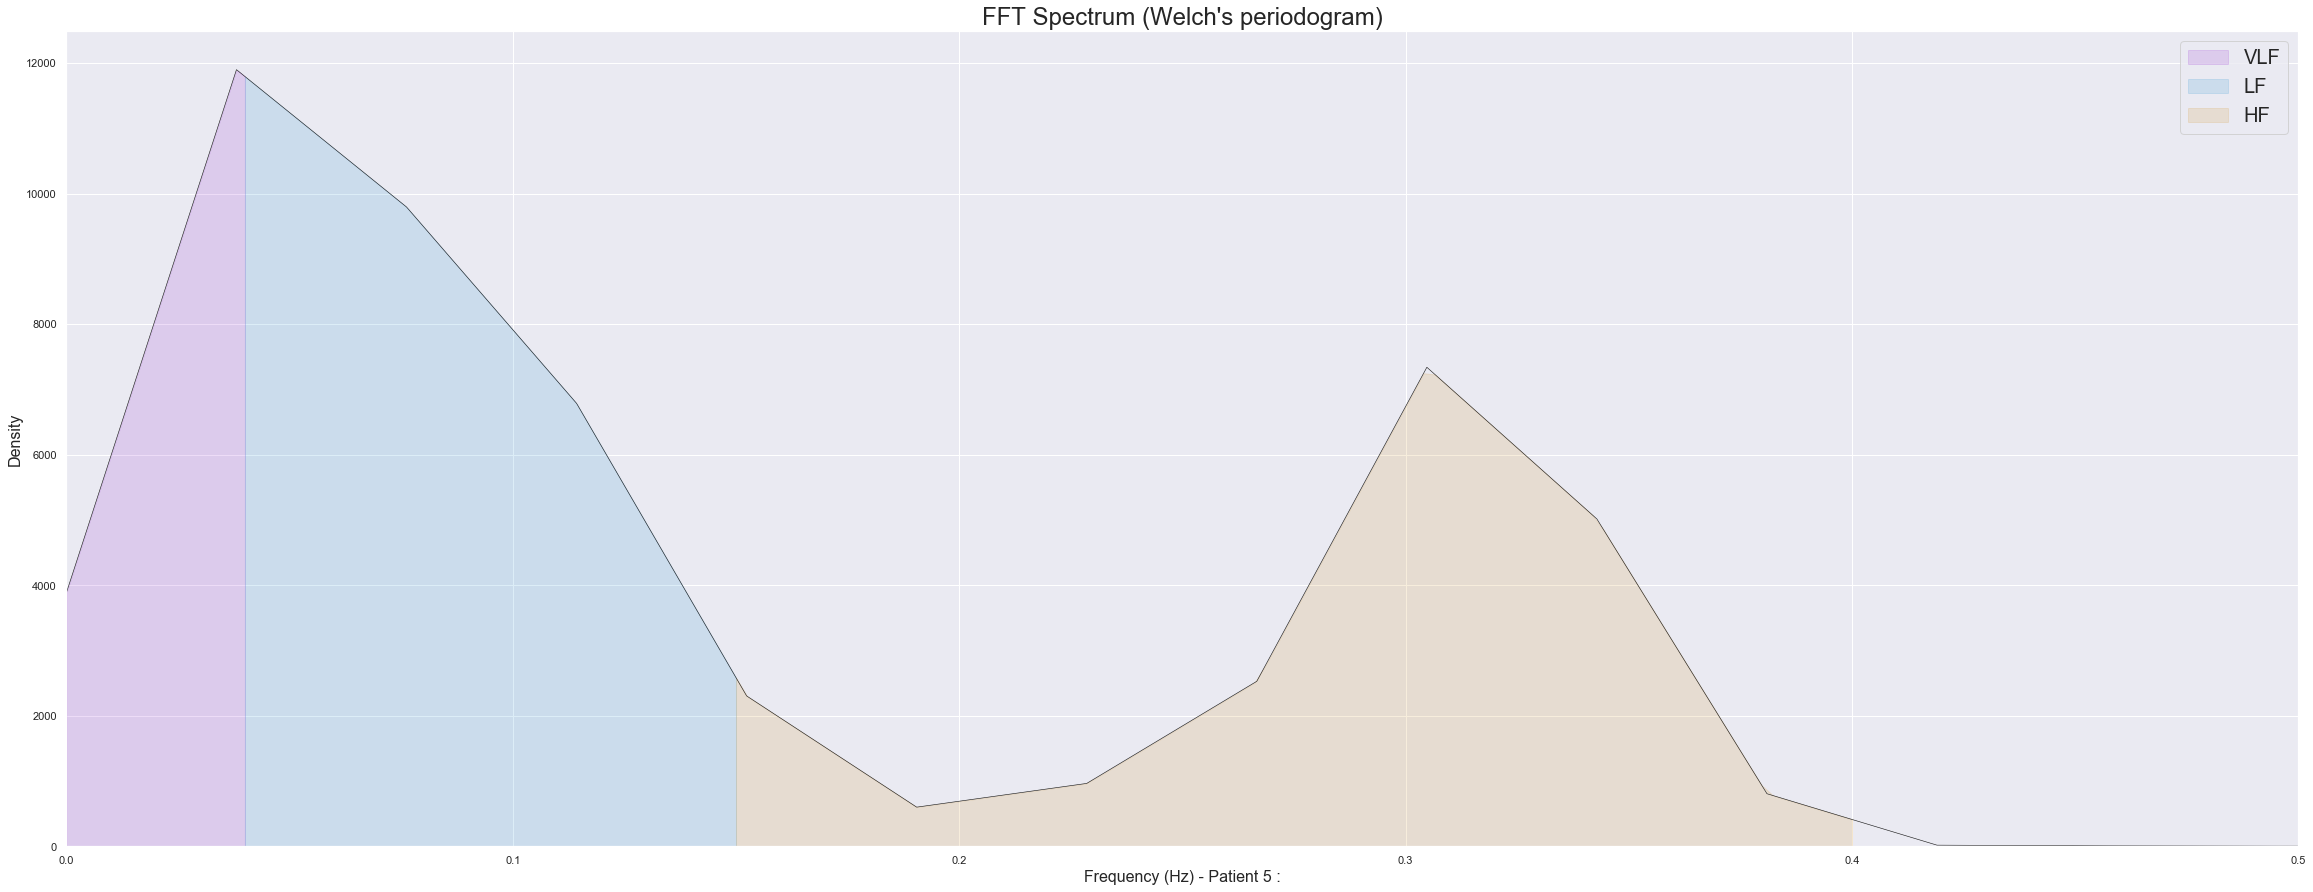

In [20]:
def frequency_domain(rri, i=None, fs=4):
    
    
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=ECGs_dic[i]['rri'], fs=fs)
    
    ''' 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    
    plt.figure(figsize=(40, 15))
    plt.plot(fxx, pxx, color="k", linewidth=0.6)
    plt.title("FFT Spectrum (Welch's periodogram)", fontsize=24)

    # create interpolation function for plotting frequency bands
    psd_f = interp1d(fxx, pxx)

    # setup frequency bands for plotting
    x_vlf = np.linspace(0, 0.04, 100)
    x_lf = np.linspace(0.04, 0.15, 100)
    x_hf = np.linspace(0.15, 0.4, 100)

    plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
    plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
    plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

    plt.gca().set_xlim(0, 0.5)
    plt.gca().set_ylim(0)
    plt.xlabel("Frequency (Hz) - Patient {} :".format(ECGs_dic[i]['patient :']), fontsize=16)
    plt.ylabel("Density", fontsize=16)
    plt.legend(fontsize=20)

    return results, fxx, pxx

for i in range(len(ECGs_dic)) :
    
    print('*' * 80)
    print("Frequency domain metrics - patient {} :".format(ECGs_dic[i]['patient :']))
    results, fxx, pxx = frequency_domain(ECGs_dic[i]['rri'], i)

    for k, v in results.items():
        print("- %s: %.2f" % (k, v)) 